# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [181]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.stats import entropy
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt
import os
import os.path as p
import glob
from PIL import Image
from pathlib import Path
from itertools import compress

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras.layers import TimeDistributed
from keras.models import Model
from ssd_encoder_decoder.ssd_output_decoder_dropout import decode_detections
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.object_detection_2d_image_boxes_validation_utils import BoxFilter

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels

from bounding_box_utils.bounding_box_utils import iou

from tqdm import tqdm_notebook as tqdm

import cv2

%matplotlib inline

In [2]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# Define parameters
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
n_boxes = 8732
N = 20 # Number of passes through the network

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)


# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'good_dropout_model/ssd300_dropout_PASCAL2012_train_+12_epoch-58_loss-3.8960_val_loss-5.0832.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W0127 14:08:28.526849 140225599813440 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0127 14:08:28.528613 140225599813440 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0127 14:08:28.546424 140225599813440 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0127 14:08:28.547755 140225599813440 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 300, 300, 3)  0           input_mean_normalization[0][0]   
__________________________________________________________________________________________________
conv1_1 (C

Or

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [6]:
ROOT_PATH = '/usr/local/data/msmith/APL/Datasets/KITTI_converted/'
# The directories that contain the images.
VOC_2012_images_dir      = p.join(ROOT_PATH,'VOC2012/JPEGImages/')

# The directories that contain the annotations.
VOC_2012_annotations_dir      = p.join(ROOT_PATH,'VOC2012/Annotations/')

# The paths to the image sets.
VOC_2012_trainval_image_set_filename = p.join(ROOT_PATH,'VOC2012/ImageSets/Main/trainval.txt')

# KITTI_classes = ['car', 'Van', 'Truck', 'Pedestrian', 'person', 'Cyclist', 'Tram','Misc', 'DontCare']
# PASCAL_classes = ['background',
#            'aeroplane', 'bicycle', 'bird', 'boat',
#            'bottle', 'bus', 'car', 'cat',
#            'chair', 'cow', 'diningtable', 'dog',
#            'horse', 'motorbike', 'person', 'pottedplant',
#            'sheep', 'sofa', 'train', 'tvmonitor']

classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset = DataGenerator(load_images_into_memory=False)
dataset.parse_xml(images_dirs=[VOC_2012_images_dir],
                  image_set_filenames=[VOC_2012_trainval_image_set_filename],
                  annotations_dirs=[VOC_2012_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False,
                  )

Processing image set 'trainval.txt': 100%|██████████| 23772/23772 [03:22<00:00, 117.21it/s]


In [7]:
# Redefine resize because default version has weird behaviour
class Resize:
    '''
    Resizes images to a specified height and width in pixels.
    '''

    def __init__(self,
                 height,
                 width,
                 interpolation_mode=cv2.INTER_LINEAR,
                 box_filter=None,
                 labels_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}):
        '''
        Arguments:
            height (int): The desired height of the output images in pixels.
            width (int): The desired width of the output images in pixels.
            interpolation_mode (int, optional): An integer that denotes a valid
                OpenCV interpolation mode. For example, integers 0 through 5 are
                valid interpolation modes.
            box_filter (BoxFilter, optional): Only relevant if ground truth bounding boxes are given.
                A `BoxFilter` object to filter out bounding boxes that don't meet the given criteria
                after the transformation. Refer to the `BoxFilter` documentation for details. If `None`,
                the validity of the bounding boxes is not checked.
            labels_format (dict, optional): A dictionary that defines which index in the last axis of the labels
                of an image contains which bounding box coordinate. The dictionary maps at least the keywords
                'xmin', 'ymin', 'xmax', and 'ymax' to their respective indices within last axis of the labels array.
        '''
        if not (isinstance(box_filter, BoxFilter) or box_filter is None):
            raise ValueError("`box_filter` must be either `None` or a `BoxFilter` object.")
        self.out_height = height
        self.out_width = width
        self.interpolation_mode = interpolation_mode
        self.box_filter = box_filter
        self.labels_format = labels_format

    def __call__(self, image, labels=None, return_inverter=False):

        img_height, img_width = image.shape[:2]

        xmin = self.labels_format['xmin']
        ymin = self.labels_format['ymin']
        xmax = self.labels_format['xmax']
        ymax = self.labels_format['ymax']

        image = cv2.resize(image,
                           dsize=(self.out_width, self.out_height),
                           interpolation=self.interpolation_mode)

        if return_inverter:
            def inverter(labels):
                labels = np.copy(labels)
                labels[:, [ymin, ymax]] = np.round(labels[:, [ymin, ymax]] * (img_height / self.out_height), decimals=0)
                labels[:, [xmin, xmax]] = np.round(labels[:, [xmin, xmax]] * (img_width / self.out_width), decimals=0)
                return labels

        if labels is None:
            if return_inverter:
                return image, inverter
            else:
                return image
        else:
            labels = np.copy(labels)
            labels[:, [ymin, ymax]] = np.round(labels[:, [ymin, ymax]] * (self.out_height / img_height), decimals=0)
            labels[:, [xmin, xmax]] = np.round(labels[:, [xmin, xmax]] * (self.out_width / img_width), decimals=0)

            if not (self.box_filter is None):
                self.box_filter.labels_format = self.labels_format
                labels = self.box_filter(labels=labels,
                                         image_height=self.out_height,
                                         image_width=self.out_width)

            if return_inverter:
                return image, labels, inverter
            else:
                return image, labels

In [187]:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height,width=img_width, labels_format={'xmin': -4, 'ymin': -3, 'xmax': -2, 'ymax': -1})

transformations = [convert_to_3_channels, resize]

batch_size = 128
generator = dataset.generate(batch_size=batch_size,
                                         shuffle=False,
                                         transformations=transformations,
                                         label_encoder=None,
                                         returns={'original_images',
                                                  'processed_images',
                                                  'image_ids',
                                                  'evaluation-neutral',
                                                  'inverse_transform',
                                                  'original_labels'},
                                         keep_images_without_gt=True,
                                         degenerate_box_handling='remove')

## 3. Make predictions

In [227]:
n_images = dataset.get_dataset_size()
#n_images = 3*batch_size
n_batches = int(np.ceil(n_images / batch_size))
#n_batches = 10

In [228]:
save_dir = '/usr/local/data/msmith/APL/dropout_time_series'
os.makedirs(save_dir, exist_ok=True)

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
# classes = ['background',
#            'aeroplane', 'bicycle', 'bird', 'boat',
#            'bottle', 'bus', 'car', 'cat',
#            'chair', 'cow', 'diningtable', 'dog',
#            'horse', 'motorbike', 'person', 'pottedplant',
#            'sheep', 'sofa', 'train', 'tvmonitor']

In [229]:
def runGPUPredictions(generator, n_batches, N):
    output = []
    for _ in tqdm(range(n_batches)):
        batch_X, batch_image_ids, batch_eval_neutral, batch_inverse_transforms, original_X, batch_orig_labels = next(generator)
    
        # After below for loop: nested list (Num passes, batch size)
        # Each element : np array (num_detections, num_class+6)
        model_out = []
        for n in range(N):
            model_out.append(decode_detections(model.predict(batch_X), confidence_thresh=0.1, 
                                               iou_threshold=0.1, top_k=200, normalize_coords=normalize_coords, 
                                               img_height=img_height, img_width=img_width))
        # Now list is an array (Num passes, batch size)
        model_out = np.array(model_out)
        
        output.append((batch_X, batch_image_ids, batch_eval_neutral, batch_inverse_transforms, original_X, batch_orig_labels, model_out))
    return output

In [230]:
def runInference(gpuOut, iou_threshold=0.95):
    results = []
    for b in tqdm(range(n_batches)):
        batch_X, batch_image_ids, batch_eval_neutral, batch_inverse_transforms, original_X, batch_orig_labels, model_out = gpuOut[b]
        bs = len(batch_X)

        # model_out is an array (Num passes, batch size)

        # Indexing : [image #][observation #]
        # Note that each image will have different numbers of observations
        # Each observation is an array with shape (num_detections, num_class+6)
        observations_per_img = []

        # Iterate over each batch image
        for i in range(bs):
            filtered = [c for c in model_out[:,i] if 0 not in c.shape]
            if len(filtered) == 0:
                concated = np.empty((0))
            else:
                concated =  np.concatenate(filtered)
            # Concated is now an array of shape (total num detections, num_class + 6)
            # Note that there will be many overlaps; we are now trying to remove them

            observations = []
            while concated.shape[0] > 0:
                # Get first bounding box
                box = concated[0, :]
                # Calculate IoU for between said first box an all others
                ious = iou(concated[:, -4:], box[-4:], coords='corners', border_pixels='half', mode='element-wise')
                # Get matches, guaranteed one match min. to itself
                keep_idx = ious >= iou_threshold
                # Add box to list of boxes
                # This way we are grouping all overlapping boxes
                observations.append(concated[keep_idx, :])
                # Remove the boxes we just found were overlapping (min. itself) and keep going
                concated = concated[np.invert(keep_idx),:]
            observations_per_img.append(observations)

        # Get label probabilities
#         observations_decoded_per_img = []
#         for i in range(bs):
#             observations_decoded = []
#             for obs in observations_per_img[i]:
#                 # in observation: index 0-class id of max, 1-confidence of said class, 2-23 inclusive: softmax values, 24-27: box coordinates
#                 means = np.mean(obs[:,2:], axis=0) # Get mean values of softmax and boxes per paper
#                 ent = entropy(means[:-4]) # Get uncertainty estimate using entropy of mean (total uncertainty)
#                 # Max entropy of 21 values slightly greater than 3
#                 # Min is 0 obviously
#                 new_class = np.argmax(means[1:-4]) + 1 # Get max class (ignoring background)
#                 new_obs = np.empty((7))
#                 new_obs[0:3] = [new_class, means[new_class] , ent]
#                 new_obs[3:7] = means[-4:]
#                 # New format: class id, associated class softmax confidence, entropy value, bounding box values
#                 observations_decoded.append(new_obs)
#             observations_decoded = np.array(observations_decoded)
#             # If not empty
#             if len(observations_decoded) > 0:
#                 observations_decoded = observations_decoded[observations_decoded[:,1].argsort()]
#             observations_decoded_per_img.append(observations_decoded)
#             # Index format: [img #][observation #]

#         # Now transformed to original bounding box coord for display
#         # Index: [img #][detection #](class id, associated class softmax confidence, entropy value, bounding box values)
#         observations_decoded_per_img = apply_inverse_transforms(observations_decoded_per_img, batch_inverse_transforms)
        
        # Save data for later processing
        results.append((observations_per_img, batch_image_ids, batch_orig_labels, batch_inverse_transforms, original_X))
        
#         if saveFigures:
#             # Disable showing plot
#             plt.ioff()
#             #plt.ion()

#             # Display the image and draw the predicted boxes onto it.
#             for i in range(bs):
#                 observations_decoded = observations_decoded_per_img[i]

#                 save_file = Path(os.path.join(save_dir, batch_image_ids[i] + '.pdf'))
#                 save_file_jpg = Path(os.path.join(save_dir, batch_image_ids[i] + '.jpg'))
#                 if not save_file.exists():
#                     plt.figure(figsize=(20,12))
#                     plt.imshow(original_X[i])
#                     plt.axis('off')

#                     current_axis = plt.gca()

#                     for observation in observations_decoded:
#                         # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
#                         xmin = observation[-4]
#                         ymin = observation[-3]
#                         xmax = observation[-2]
#                         ymax = observation[-1]
#                         color = colors[int(observation[0])]
#                         label = '{}: {:.2f} | {:.2f}'.format(classes[int(observation[0])], observation[1], observation[2])
#                         current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
#                         current_axis.text(xmin, ymin, label, size='medium', color='white', bbox={'facecolor':color, 'alpha':1.0})

#                     plt.savefig(save_file, bbox_inches='tight', pad_inches=0)
#                     plt.savefig(save_file_jpg, bbox_inches='tight', pad_inches=0)

#                     plt.close()
    return results

In [231]:
gpuOut = runGPUPredictions(generator, n_batches, N)

In [232]:
results = runInference(gpuOut, 0.65)

In [238]:
# Convert output to more usable format indexed by image number
prediction_list = []
id_list = []
gt_list = []
inv_transform_list = []
original_X_list = []
for i in results:
    prediction_list.extend(i[0])
    id_list.extend(i[1])
    gt_list.extend(i[2])
    inv_transform_list.extend(i[3])
    original_X_list.extend(i[4])

In [239]:
def runTimeSeriesAccumulation(predictionList, iou_threshold=0.5):
    numFramesTotal = len(predictionList)
    
    # Basic process: examine each frame, and compare observations against previous frame
    # 
    
    imageState = []
    imageStateAccum = []
    
    for i in tqdm(range(numFramesTotal)):
    
        oldImageState = np.array(imageState)
        imageState = []
        
        # Make sure we don't go out of bounds
        prevFramesExist = True
        if i-1 < 0:
            prevFramesExist = False
        
        # Make sure prev frames are from same sequence
        if prevFramesExist and currentID.split('-')[0] != idList[i - 1].split('-')[0]:
            prevFramesExist = False
            
        if not(prevFramesExist):
            continue
        
        currentPredictions = np.array(predictionList[i])
        previousPredictions = np.array(predictionList[i-1])
        
        for obs in currentPredictions:

            meanbbox = np.mean(obs[:, -4:], axis=0)

            prevMeanBBoxes = []

            for prevObs in previousPredictions:
                prevMeanBBoxes.append(np.mean(prevObs[:, -4:], axis=0))
            prevMeanBBoxes = np.array(prevMeanBBoxes)
            
            if len(prevMeanBBoxes) > 0:
                ious = iou(prevMeanBBoxes, meanbbox, coords='corners', border_pixels='half', mode='element-wise')
                matches = ious > iou_threshold
            else:
                matches = []

            # Check for match in current super observations
            stateMeanBoxes = []

            for sObs in oldImageState:
                stateMeanBoxes.append(np.mean(sObs['bbox'], axis=0))
            stateMeanBoxes = np.array(stateMeanBoxes)

            if len(stateMeanBoxes) > 0:
                ious = iou(prevMeanBBoxes, meanbbox, coords='corners', border_pixels='half', mode='element-wise')
                matchesS = ious > iou_threshold
            else:
                matchesS = []

            stateMatches = oldImageState[matchesS]

            # Get together all observations from current + previous frame
            if np.any(matches):
                compiledObs = np.append(obs, np.concatenate(previousPredictions[matches], axis=0), axis=0)
            else:
                compiledObs = obs
            
            softmax = compiledObs[:, 2:-4]
            # Add in data from existing super observations
            for m in stateMatches:
                softmax = np.append(softmax, m['softmax'], axis=0)
                
            # in observation: index 0-class id of max, 1-confidence of said class, 2-23 inclusive: softmax values, 24-27: box coordinates
            # Super observation bbox samples are from current frame, softmax from all
            superObservation = {'bbox': obs[:, -4:], 'softmax' : softmax}

            imageState.append(superObservation)
        
        #imageState now = complete list of observations for current image taking into account past frame(s)

        imageStateAccum.append(imageState)
        
    return imageStateAccum

In [240]:
timeSeriesAccum = runTimeSeriesAccumulation(prediction_list)

In [262]:
def saveFigures(imageStates, idList, gtList, batchTransforms, originalX):

    for idx in tqdm(range(0, len(imageStates))):
    
        imageState = imageStates[idx]
        imageId = idList[idx]
        gt = gtList[idx]
        inverters = batchTransforms[idx]
        originalImage = originalX[idx]
        
        save_file = Path(os.path.join(save_dir, imageId + '.pdf'))
        save_file_jpg = Path(os.path.join(save_dir, imageId + '.jpg'))
        
        plt.ioff()
        plt.figure(figsize=(20,12))
        plt.imshow(originalImage)
        plt.axis('off')
        current_axis = plt.gca()
        
        for state in imageState:

            mean_bbox = np.mean(state['bbox'], axis=0)

            sample_mean = np.mean(state['softmax'], axis=0)

            class_id = np.argmax(sample_mean)
            class_id_no_background = np.argmax(sample_mean[1:]) + 1
            
            max_class_softmax_value = sample_mean[class_id]
            max_class_softmax_value_no_bkg = sample_mean[class_id_no_background]

            class_entropy = entropy(sample_mean)
            sample_entropy = entropy(state['softmax'][:, class_id_no_background])

            class_entropy_no_bkg = entropy(sample_mean[1:])

            # Apply inverse transforms
            for inverter in inverters:
                if not (inverter is None):
                    mean_bbox = inverter(np.expand_dims(mean_bbox, axis=0)).squeeze()

            xmin = mean_bbox[-4]
            ymin = mean_bbox[-3]
            xmax = mean_bbox[-2]
            ymax = mean_bbox[-1]
            color = colors[int(class_id_no_background)]
            label = '{}: {:.2f} | {:.2f} | {:.2f}'.format(classes[int(class_id_no_background)], max_class_softmax_value_no_bkg, class_entropy_no_bkg, sample_entropy)
            # Background class is dominant:
            if class_id != class_id_no_background:
                current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2, linestyle='--'))  
                box_spec = {'facecolor':color, 'alpha':0.5}
            else:
                current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
                box_spec = {'facecolor':color, 'alpha':0.85}
            current_axis.text(xmin, ymin, label, size='medium', color='white', bbox=box_spec)

        # Ignore PDF save to speed up process
        #plt.savefig(save_file, bbox_inches='tight', pad_inches=0)
        plt.savefig(save_file_jpg, bbox_inches='tight', pad_inches=0, optimize=True)

        plt.close()


In [264]:
saveFigures(timeSeriesAccum, id_list, gt_list, inv_transform_list, original_X_list)

In [53]:
def runTimeSeriesProcess(predictionList, idList, gtList, batchTransforms, originalX, numFrames=2, iou_threshold=0.8, saveFigures=True):
    """
    numFrames: number of frames to process for time series ensembling. Minimum 2 frames (current frame and previous)
    """
    numFramesTotal = len(predictionList)
    
    results = []
    
    observations_decoded_per_img = []
    
    if numFrames < 2:
        raise Exception('numFrames minimum is 2')
    
    for i in tqdm(range(numFramesTotal)):
        
        observations_decoded = []
        
        currentID = idList[i]
        currentGT = gtList[i]
        
        # Make sure we don't go out of bounds
        prevFramesExist = True
        if i-numFrames < 0:
            prevFramesExist = False
        
        # Make sure prev frames are from same sequence
        if prevFramesExist and currentID.split('-')[0] != idList[i - (numFrames - 1)].split('-')[0]:
            prevFramesExist = False
        
        predictions = predictionList[i]
        numObsPerFrame = [len(predictions)]
        if prevFramesExist:
            for f in range(1, numFrames):
                predictions.extend(predictionList[i-f])
                numObsPerFrame.append(len(predictionList[i-f]))
            
        # Process each prediction
        # Need to match each observation in one frame to an observation in another
        # Might be there is a detection in current frame, and in all or some prev. frames
        # Might be there is no detection in current frame, but it exists in prev. frames
        # This is a matching problem: need to find non-overlapping set of all detections
        
        # Basic assumption we make for now: detection in one frame will have IoU 0.5 min. overlap with other frames
        
       # Run through list of observations
# Create new data structure: super observation, incl. sub observations for each image

    while len(predictions) > 0:
        currentObs = predictions[0]

        meanbbox = np.mean(currentObs[:, -4:], axis=0)

        allmeanbboxes = []
        for obs in predictions:
            allmeanbboxes.append(np.mean(obs[:, -4:], axis=0))
        allmeanbboxes = np.array(allmeanbboxes)

        ious = iou(allmeanbboxes, meanbbox, coords='corners', border_pixels='half', mode='element-wise')

        image_idx = np.repeat([range(0, numFrames)], [len(i) for i in predictions])

        
        # Need to associate observation -> observation before we calculate entropy, predictive
        for observation in currentPredictions:
        
            # Get mean of bbox so we can group observations
            meanbbox = np.mean(observation[:, -4:], axis=0)
            
            for prevFrame in prevPredictions:
                
                meanprevbboxes = []
                for prevObservation in prevFrame:
                    meanprevbboxes.append(np.mean(prevObservation[:, -4:], axis=0))
                meanprevbboxes = np.array(meanprevbboxes)

                if len(meanprevbboxes) != 0:
                    ious = iou(meanprevbboxes, meanbbox, coords='corners', border_pixels='half', mode='element-wise')
                else:
                    ious = np.zeros(())

                # No match in previous frame
                
                
                # TODO: try reducing via mean to 1 sample per image, lets us avoid horribly biasing results
                if not(np.any(ious > iou_threshold)):
                    print('No match in prev. frame for and frame %i' % (i))
                    print('IoUs: ', end='')
                    print(ious)
    #                 all_samples = observation
                    prev_samples = np.copy(observation)
                    # Set all boxes to background since that is what they are (below threshold)
                    # We leave box coords alone
                    prev_samples[:, 0:23] = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

                else:
                    # Find biggest IOU
                    best_idx = np.argmax(ious)
                    prev_samples = prevPreds[best_idx]
            
            all_samples = np.concatenate((observation, prev_samples), axis=0)

            # in observation: index 0-class id of max, 1-confidence of said class, 2-23 inclusive: softmax values, 24-27: box coordinates
            means = np.mean(all_samples[:,2:], axis=0) # Get mean values of softmax and boxes per paper
            # Note that we do not calculate entropy using background class
            ent = entropy(means[1:-4]) # Get uncertainty estimate using entropy of mean (total uncertainty)
            # Max entropy of 21 values slightly greater than 3
            # Min is 0 obviously
            new_class = np.argmax(means[1:-4]) + 1 # Get max class (ignoring background)
            new_obs = np.empty((7))
            new_obs[0:3] = [new_class, means[new_class] , ent]
            new_obs[3:7] = means[-4:]
            # New format: class id, associated class softmax confidence, entropy value, bounding box values
            observations_decoded.append(new_obs)
        
        # This is a list of all observations in 1 image
        observations_decoded = np.array(observations_decoded)

        # If not empty
        if len(observations_decoded) > 0:
            observations_decoded = observations_decoded[observations_decoded[:,1].argsort()]
        observations_decoded_per_img.append(observations_decoded)
        # Index format: [img #][observation #]

    # Now transformed to original bounding box coord for display
    # Index: [img #][detection #](class id, associated class softmax confidence, entropy value, bounding box values)
    observations_decoded_per_img = apply_inverse_transforms(observations_decoded_per_img, batchTransforms)
    
    results.append((observations_decoded_per_img, idList, gtList))
    
    if saveFigures:
        # Disable showing plot
        plt.ioff()
        #plt.ion()

        # Display the image and draw the predicted boxes onto it.
        print('Saving figures...')
        for i in tqdm(range(numFrames, numFramesTotal)):
            observations_decoded = observations_decoded_per_img[i]

            save_file = Path(os.path.join(save_dir, idList[i] + '.pdf'))
            save_file_jpg = Path(os.path.join(save_dir, idList[i] + '.jpg'))
            if not save_file.exists():
                plt.figure(figsize=(20,12))
                plt.imshow(originalX[i])
                plt.axis('off')

                current_axis = plt.gca()

                for observation in observations_decoded:
                    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
                    xmin = observation[-4]
                    ymin = observation[-3]
                    xmax = observation[-2]
                    ymax = observation[-1]
                    color = colors[int(observation[0])]
                    label = '{}: {:.2f} | {:.2f}'.format(classes[int(observation[0])], observation[1], observation[2])
                    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
                    current_axis.text(xmin, ymin, label, size='medium', color='white', bbox={'facecolor':color, 'alpha':1.0})

                # Ignore PDF save to speed up process
                #plt.savefig(save_file, bbox_inches='tight', pad_inches=0)
                plt.savefig(save_file_jpg, bbox_inches='tight', pad_inches=0, optimize=True)

                plt.close()
    
    return results


SyntaxError: invalid syntax (<ipython-input-53-adf6ebbe82e1>, line 50)

In [19]:
results2 = runTimeSeriesProcess(prediction_list, id_list, gt_list, inv_transform_list, original_X_list, 2, 0.65, True)

No match in prev. frame for and frame 2
IoUs: 0.0
No match in prev. frame for and frame 3
IoUs: [0.55252438]
No match in prev. frame for and frame 4
IoUs: [0.52906825]
No match in prev. frame for and frame 5
IoUs: [0.63608827]
No match in prev. frame for and frame 6
IoUs: [0.53173346]
No match in prev. frame for and frame 7
IoUs: [0.]
No match in prev. frame for and frame 7
IoUs: [0.]
No match in prev. frame for and frame 8
IoUs: [0.53020662 0.         0.        ]
No match in prev. frame for and frame 9
IoUs: [0.56840644 0.         0.        ]
No match in prev. frame for and frame 10
IoUs: [0.52719477 0.        ]
No match in prev. frame for and frame 10
IoUs: [0. 0.]
No match in prev. frame for and frame 10
IoUs: [0. 0.]
No match in prev. frame for and frame 11
IoUs: [0.53884337 0.         0.         0.        ]
No match in prev. frame for and frame 11
IoUs: [0.         0.45305531 0.         0.        ]
No match in prev. frame for and frame 13
IoUs: [0.         0.47639494]
No match in 

No match in prev. frame for and frame 172
IoUs: [0.         0.         0.         0.39848353]
No match in prev. frame for and frame 173
IoUs: [0.00272914 0.         0.        ]
No match in prev. frame for and frame 173
IoUs: [0.         0.         0.64938283]
No match in prev. frame for and frame 174
IoUs: [0.         0.         0.         0.40487876]
No match in prev. frame for and frame 175
IoUs: [0.59534159 0.         0.        ]
No match in prev. frame for and frame 175
IoUs: [0.22596048 0.         0.        ]
No match in prev. frame for and frame 176
IoUs: [0.13279089 0.61789338 0.         0.        ]
No match in prev. frame for and frame 176
IoUs: [0.         0.         0.         0.60915483]
No match in prev. frame for and frame 177
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 177
IoUs: [0.         0.         0.64619539 0.        ]
No match in prev. frame for and frame 177
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 178
IoUs: [0.         0.03921918 0.0

No match in prev. frame for and frame 267
IoUs: [0.         0.61828916 0.         0.        ]
No match in prev. frame for and frame 267
IoUs: [0.11574228 0.         0.12482449 0.        ]
No match in prev. frame for and frame 268
IoUs: [0.47089429 0.0478196  0.         0.05298688]
No match in prev. frame for and frame 268
IoUs: [0.        0.        0.5258552 0.       ]
No match in prev. frame for and frame 268
IoUs: [0.01697898 0.         0.         0.14902159]
No match in prev. frame for and frame 268
IoUs: [0.         0.         0.05784733 0.        ]
No match in prev. frame for and frame 268
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 269
IoUs: [0.05797284 0.         0.         0.         0.        ]
No match in prev. frame for and frame 269
IoUs: [0.         0.56909626 0.         0.         0.        ]
No match in prev. frame for and frame 269
IoUs: [0.43040871 0.         0.         0.         0.        ]
No match in prev. frame for and frame 269
IoUs: [0.         0.0

No match in prev. frame for and frame 391
IoUs: [0.         0.         0.         0.         0.64112962]
No match in prev. frame for and frame 393
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 394
IoUs: [0.64646742 0.         0.         0.         0.        ]
No match in prev. frame for and frame 394
IoUs: [0.         0.         0.         0.         0.63739983]
No match in prev. frame for and frame 394
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 394
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 395
IoUs: [0.         0.         0.         0.         0.54548371 0.
 0.        ]
No match in prev. frame for and frame 395
IoUs: [0.         0.         0.         0.         0.         0.47247183
 0.22048335]
No match in prev. frame for and frame 396
IoUs: [0.         0.         0.         0.61346915 0.10073183]
No match in prev. frame for and frame 396
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 396
IoUs: [0.        0.        0.    

No match in prev. frame for and frame 445
IoUs: [0.         0.00562104 0.         0.         0.04064302 0.        ]
No match in prev. frame for and frame 446
IoUs: [0.         0.64264286 0.         0.         0.        ]
No match in prev. frame for and frame 446
IoUs: [0.         0.         0.63132404 0.         0.        ]
No match in prev. frame for and frame 446
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 447
IoUs: [0.         0.         0.         0.         0.05569593 0.52095355]
No match in prev. frame for and frame 448
IoUs: [0.         0.         0.         0.47044063 0.05261793]
No match in prev. frame for and frame 449
IoUs: [0.         0.         0.         0.21439768]
No match in prev. frame for and frame 449
IoUs: [0.10037511 0.         0.         0.        ]
No match in prev. frame for and frame 450
IoUs: [0.         0.         0.63911152 0.         0.        ]
No match in prev. frame for and frame 450
IoUs: [0.         0.         0.         0.15841331 0.

No match in prev. frame for and frame 590
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 591
IoUs: [0.         0.         0.         0.         0.56535911 0.        ]
No match in prev. frame for and frame 591
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 591
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 592
IoUs: [0.62819699 0.         0.         0.         0.         0.
 0.00090402 0.        ]
No match in prev. frame for and frame 593
IoUs: [0.21238159 0.13479494 0.         0.         0.        ]
No match in prev. frame for and frame 593
IoUs: [0.         0.         0.         0.         0.52594767]
No match in prev. frame for and frame 594
IoUs: [0.         0.         0.         0.19647303 0.        ]
No match in prev. frame for and frame 594
IoUs: [0.        0.        0.        0.        0.5581878]
No match in prev. frame for and frame 595
IoUs: [0.62697064 0.         0.09558992 0.         0.         0.        ]
No match in prev. fra

No match in prev. frame for and frame 679
IoUs: [0.38084226 0.         0.         0.         0.29578284]
No match in prev. frame for and frame 680
IoUs: [1.35859188e-04 0.00000000e+00 5.80917950e-01 0.00000000e+00
 0.00000000e+00]
No match in prev. frame for and frame 680
IoUs: [0.         0.         0.01100586 0.         0.        ]
No match in prev. frame for and frame 680
IoUs: [0.53331566 0.         0.0044936  0.         0.19209516]
No match in prev. frame for and frame 681
IoUs: [0.         0.         0.59774078 0.         0.         0.        ]
No match in prev. frame for and frame 682
IoUs: [0.42704911 0.         0.         0.        ]
No match in prev. frame for and frame 682
IoUs: [0.         0.         0.56667799 0.        ]
No match in prev. frame for and frame 682
IoUs: [0.         0.05829474 0.         0.16122166]
No match in prev. frame for and frame 683
IoUs: [0.         0.03385445 0.         0.         0.62387753 0.20581021]
No match in prev. frame for and frame 683
IoU

No match in prev. frame for and frame 803
IoUs: [0.11342192 0.00569062 0.        ]
No match in prev. frame for and frame 804
IoUs: [0.         0.50754735 0.         0.         0.        ]
No match in prev. frame for and frame 805
IoUs: [0.         0.58207942 0.        ]
No match in prev. frame for and frame 806
IoUs: [0.         0.         0.         0.00679516]
No match in prev. frame for and frame 806
IoUs: [0.         0.55426791 0.         0.        ]
No match in prev. frame for and frame 807
IoUs: [0.        0.        0.5776651 0.        0.       ]
No match in prev. frame for and frame 807
IoUs: [0.18791764 0.27084781 0.         0.         0.18548044]
No match in prev. frame for and frame 807
IoUs: [0.46570905 0.         0.         0.         0.40724414]
No match in prev. frame for and frame 808
IoUs: [0.50666601 0.         0.         0.        ]
No match in prev. frame for and frame 809
IoUs: [0. 0.]
No match in prev. frame for and frame 811
IoUs: [0.         0.10179207]
No match 

No match in prev. frame for and frame 934
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 935
IoUs: [0.06713053 0.61707516 0.         0.         0.         0.        ]
No match in prev. frame for and frame 936
IoUs: [0.         0.         0.64751586 0.         0.        ]
No match in prev. frame for and frame 937
IoUs: [0.         0.         0.49921651 0.         0.        ]
No match in prev. frame for and frame 937
IoUs: [0.        0.        0.        0.        0.4824429]
No match in prev. frame for and frame 938
IoUs: [0.        0.        0.        0.        0.5239709]
No match in prev. frame for and frame 939
IoUs: [0.         0.         0.48235457 0.        ]
No match in prev. frame for and frame 940
IoUs: [0.         0.60974926 0.         0.         0.        ]
No match in prev. frame for and frame 942
IoUs: [0.00450453 0.         0.         0.         0.        ]
No match in prev. frame for and frame 944
IoUs: [0.         0.         0.59822194]
No match in prev. f

No match in prev. frame for and frame 1041
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 1042
IoUs: [0.         0.37051588 0.01602361 0.        ]
No match in prev. frame for and frame 1042
IoUs: [0.         0.         0.         0.32724695]
No match in prev. frame for and frame 1044
IoUs: [0.         0.12995862]
No match in prev. frame for and frame 1044
IoUs: [0.         0.42163344]
No match in prev. frame for and frame 1045
IoUs: [0.         0.02816821 0.         0.00425122]
No match in prev. frame for and frame 1049
IoUs: [0.         0.01345394]
No match in prev. frame for and frame 1049
IoUs: [0. 0.]
No match in prev. frame for and frame 1058
IoUs: [0.05017205 0.        ]
No match in prev. frame for and frame 1059
IoUs: [0. 0.]
No match in prev. frame for and frame 1064
IoUs: [0.]
No match in prev. frame for and frame 1068
IoUs: [0.]
No match in prev. frame for and frame 1072
IoUs: 0.0
No match in prev. frame for and frame 1074
IoUs: 0.0
No match in prev. frame for a

No match in prev. frame for and frame 1330
IoUs: [0.64556959 0.         0.11359778 0.03214648 0.        ]
No match in prev. frame for and frame 1331
IoUs: [0.01516882 0.         0.         0.        ]
No match in prev. frame for and frame 1333
IoUs: [0.04356844 0.         0.        ]
No match in prev. frame for and frame 1333
IoUs: [0.         0.55274681 0.        ]
No match in prev. frame for and frame 1333
IoUs: [0.14379174 0.         0.        ]
No match in prev. frame for and frame 1333
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1333
IoUs: [0.12782395 0.         0.        ]
No match in prev. frame for and frame 1334
IoUs: [0.16640362 0.         0.         0.36130597 0.         0.
 0.58263251]
No match in prev. frame for and frame 1336
IoUs: [0.14398323 0.34660755 0.        ]
No match in prev. frame for and frame 1336
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1336
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1337
IoUs: [0.         0.         0.3928

No match in prev. frame for and frame 1430
IoUs: [0.         0.18075264 0.         0.        ]
No match in prev. frame for and frame 1431
IoUs: [0.         0.         0.12596889]
No match in prev. frame for and frame 1431
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1432
IoUs: [0.62317818 0.         0.         0.        ]
No match in prev. frame for and frame 1434
IoUs: [0.         0.         0.64829784]
No match in prev. frame for and frame 1435
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1436
IoUs: [0.         0.35252683 0.         0.        ]
No match in prev. frame for and frame 1437
IoUs: [0.         0.52792135]
No match in prev. frame for and frame 1438
IoUs: [0. 0.]
No match in prev. frame for and frame 1439
IoUs: [0.         0.         0.43080115]
No match in prev. frame for and frame 1442
IoUs: [0.]
No match in prev. frame for and frame 1442
IoUs: [0.]
No match in prev. frame for and frame 1443
IoUs: [0.         0.60173434 0.        ]
No match in prev. fra

No match in prev. frame for and frame 1557
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 1558
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 1559
IoUs: [0.         0.         0.         0.         0.         0.05509761]
No match in prev. frame for and frame 1560
IoUs: [0.         0.         0.06826242 0.         0.14923599]
No match in prev. frame for and frame 1561
IoUs: [0.         0.         0.         0.17395515]
No match in prev. frame for and frame 1562
IoUs: [0.         0.32650842 0.         0.        ]
No match in prev. frame for and frame 1563
IoUs: [0.06233565 0.         0.         0.        ]
No match in prev. frame for and frame 1564
IoUs: [0.06719604 0.09318967 0.         0.        ]
No match in prev. frame for and frame 1565
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 1566
IoUs: [0.22436722 0.         0.29037903]
No match in prev. frame for and frame 1567
IoUs: [0. 0.]
No match in prev. frame for and frame 1567
IoUs: [0. 0.]
No matc

No match in prev. frame for and frame 1654
IoUs: [0.15702671 0.         0.         0.17232039 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 1654
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 1654
IoUs: [0.02069097 0.         0.14891314 0.11111601 0.         0.00347705
 0.         0.12074171]
No match in prev. frame for and frame 1655
IoUs: [0.        0.        0.4676673 0.        0.        0.       ]
No match in prev. frame for and frame 1655
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 1656
IoUs: [0.         0.04994333 0.         0.09282329 0.        ]
No match in prev. frame for and frame 1656
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 1656
IoUs: [0.         0.22126386 0.         0.         0.        ]
No match in prev. frame for and frame 1656
IoUs: [0.         0.         0.43970516 0.03514575 0.        ]
No match in prev. frame for and frame 1656
IoUs: [0.         0.         0.         0.    

No match in prev. frame for and frame 1699
IoUs: [0.         0.10659079 0.         0.         0.0455361  0.
 0.5059227  0.         0.         0.29205976 0.06919927 0.13786336
 0.        ]
No match in prev. frame for and frame 1699
IoUs: [0.         0.         0.         0.         0.19498596 0.
 0.         0.         0.28355272 0.00186738 0.         0.02750404
 0.        ]
No match in prev. frame for and frame 1699
IoUs: [0.         0.3293225  0.         0.         0.         0.
 0.         0.         0.         0.02053651 0.53897707 0.15462499
 0.        ]
No match in prev. frame for and frame 1700
IoUs: [0.         0.         0.14053102 0.         0.         0.
 0.         0.62443313 0.         0.         0.         0.27523187
 0.        ]
No match in prev. frame for and frame 1700
IoUs: [0.         0.         0.14583731 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.40967198]
No match in prev. frame for and frame 1700
IoUs: [0.         0.     

IoUs: [0.         0.         0.28730245 0.        ]
No match in prev. frame for and frame 1811
IoUs: [0.         0.         0.21397077 0.49791417]
No match in prev. frame for and frame 1812
IoUs: [0.         0.41785626 0.         0.        ]
No match in prev. frame for and frame 1812
IoUs: [0.         0.         0.20413702 0.35373182]
No match in prev. frame for and frame 1813
IoUs: [0.         0.         0.27757963]
No match in prev. frame for and frame 1813
IoUs: [0.039777 0.       0.      ]
No match in prev. frame for and frame 1814
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 1814
IoUs: [0.09396953 0.         0.         0.47426364]
No match in prev. frame for and frame 1815
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1816
IoUs: [0.         0.24160584]
No match in prev. frame for and frame 1816
IoUs: [0.05884538 0.        ]
No match in prev. frame for and frame 1817
IoUs: [0.        0.1995369 0.       ]
No match in prev. frame for and frame 1817
IoUs: [0.    

No match in prev. frame for and frame 1901
IoUs: [0.         0.20840324]
No match in prev. frame for and frame 1904
IoUs: [0.         0.21636884]
No match in prev. frame for and frame 1907
IoUs: [0.         0.21757898]
No match in prev. frame for and frame 1909
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1917
IoUs: [0.         0.21439202]
No match in prev. frame for and frame 1923
IoUs: [0.         0.20371542]
No match in prev. frame for and frame 1927
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 1929
IoUs: [0.         0.         0.40118673 0.        ]
No match in prev. frame for and frame 1931
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 1933
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 1933
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 1934
IoUs: [0.         0.         0.         0.         0.39291532 0.        ]
No match in prev. frame for and frame 1935
IoUs: [0.         0.         0.20213141 0.        ]
No match in prev. f

 0.        ]
No match in prev. frame for and frame 2164
IoUs: [0.      0.56578 0.      0.      0.      0.      0.     ]
No match in prev. frame for and frame 2164
IoUs: [0.19122084 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 2164
IoUs: [0.         0.         0.         0.         0.         0.
 0.57978595]
No match in prev. frame for and frame 2164
IoUs: [0.0042302 0.        0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 2165
IoUs: [0.10619544 0.59060853 0.         0.         0.         0.02808071
 0.         0.         0.15299608]
No match in prev. frame for and frame 2165
IoUs: [0.         0.1714912  0.         0.         0.         0.58541461
 0.         0.         0.        ]
No match in prev. frame for and frame 2165
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 2166
IoUs: [0.63202599 0.         0.0008755  0.         0.        ]
No match in prev. frame for and

No match in prev. frame for and frame 2227
IoUs: [0.         0.63671703 0.         0.00625114 0.         0.11698375
 0.19947414 0.        ]
No match in prev. frame for and frame 2227
IoUs: [0.64342085 0.         0.         0.         0.         0.
 0.         0.0772334 ]
No match in prev. frame for and frame 2227
IoUs: [0.16643838 0.         0.10374035 0.         0.00994333 0.
 0.         0.10973897]
No match in prev. frame for and frame 2228
IoUs: [0.61626439 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 2228
IoUs: [0.         0.56627163 0.         0.         0.         0.10997503]
No match in prev. frame for and frame 2228
IoUs: [0.         0.         0.         0.59236355 0.         0.11499767]
No match in prev. frame for and frame 2228
IoUs: [0.         0.24941593 0.         0.         0.38310099 0.04418436]
No match in prev. frame for and frame 2228
IoUs: [0.         0.         0.         0.20536769 0.         0.10162661]
No match in

No match in prev. frame for and frame 2279
IoUs: [0.         0.         0.59889857 0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 2279
IoUs: [0.         0.         0.         0.         0.08576886 0.42934494
 0.17562197 0.         0.        ]
No match in prev. frame for and frame 2279
IoUs: [0.         0.         0.         0.         0.02418531 0.
 0.33029622 0.         0.        ]
No match in prev. frame for and frame 2280
IoUs: [0.         0.         0.         0.63447902 0.         0.        ]
No match in prev. frame for and frame 2280
IoUs: [0.         0.         0.         0.         0.54170318 0.18494488]
No match in prev. frame for and frame 2280
IoUs: [0.         0.         0.         0.         0.34944353 0.33134301]
No match in prev. frame for and frame 2281
IoUs: [0.         0.         0.         0.         0.17272794 0.14121464]
No match in prev. frame for and frame 2281
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame fo

IoUs: [0.60289127 0.         0.         0.06911572 0.         0.
 0.        ]
No match in prev. frame for and frame 2355
IoUs: [0.         0.         0.         0.         0.         0.37624207
 0.        ]
No match in prev. frame for and frame 2355
IoUs: [0.         0.         0.         0.         0.22843925 0.
 0.        ]
No match in prev. frame for and frame 2355
IoUs: [0.         0.         0.57889858 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 2355
IoUs: [0.07928854 0.         0.         0.5478619  0.         0.
 0.        ]
No match in prev. frame for and frame 2355
IoUs: [0.         0.         0.         0.         0.28335048 0.
 0.        ]
No match in prev. frame for and frame 2356
IoUs: [0.61932594 0.         0.         0.         0.         0.06164765
 0.        ]
No match in prev. frame for and frame 2356
IoUs: [0.09116098 0.         0.         0.         0.         0.6173158
 0.        ]
No match in prev. frame for and frame 2356
IoUs: [0.

No match in prev. frame for and frame 2420
IoUs: [0.12220625 0.         0.         0.32083549 0.         0.07048495
 0.24995433]
No match in prev. frame for and frame 2420
IoUs: [0.         0.         0.         0.35502028 0.         0.
 0.32222086]
No match in prev. frame for and frame 2421
IoUs: [0.         0.10870022 0.54268399 0.06243287 0.042798   0.        ]
No match in prev. frame for and frame 2421
IoUs: [0.         0.61786638 0.         0.         0.         0.        ]
No match in prev. frame for and frame 2421
IoUs: [0.         0.         0.         0.         0.30877381 0.40914744]
No match in prev. frame for and frame 2421
IoUs: [0.01303496 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 2422
IoUs: [0.         0.48594722 0.13779105 0.         0.03347481 0.        ]
No match in prev. frame for and frame 2422
IoUs: [0.         0.         0.55050188 0.         0.         0.        ]
No match in prev. frame for and frame 2422
IoUs:

No match in prev. frame for and frame 2485
IoUs: [0.14563702 0.         0.         0.        ]
No match in prev. frame for and frame 2485
IoUs: [0.08592371 0.         0.         0.        ]
No match in prev. frame for and frame 2485
IoUs: [0.05067983 0.         0.         0.        ]
No match in prev. frame for and frame 2485
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 2486
IoUs: [0.08737891 0.         0.59812135 0.07406689 0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 2487
IoUs: [0.24291663 0.         0.39625651 0.        ]
No match in prev. frame for and frame 2487
IoUs: [0.00943505 0.         0.0231394  0.        ]
No match in prev. frame for and frame 2487
IoUs: [0.         0.         0.         0.15190129]
No match in prev. frame for and frame 2488
IoUs: [0.12460965 0.         0.         0.63667236 0.        ]
No match in prev. frame for and frame 2488
IoUs: [0.021948 0.       0.       0.       0.      ]
No match in prev. fram

No match in prev. frame for and frame 2607
IoUs: [0.47290082 0.         0.11886689]
No match in prev. frame for and frame 2607
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 2607
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 2607
IoUs: [0.06362566 0.         0.03332648]
No match in prev. frame for and frame 2608
IoUs: [0.         0.         0.         0.29152379 0.         0.        ]
No match in prev. frame for and frame 2608
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 2608
IoUs: [0.18188265 0.0913151  0.         0.         0.         0.0239713 ]
No match in prev. frame for and frame 2608
IoUs: [0.         0.45478097 0.         0.         0.         0.21386958]
No match in prev. frame for and frame 2609
IoUs: [0.         0.         0.         0.         0.         0.40509967]
No match in prev. frame for and frame 2610
IoUs: [0.         0.47908752 0.         0.         0.        ]
No match in prev. frame for and frame 2610
IoUs: [0.         0.      

No match in prev. frame for and frame 2700
IoUs: [0.         0.         0.         0.56525272 0.        ]
No match in prev. frame for and frame 2700
IoUs: [0.04709341 0.         0.         0.         0.35515286]
No match in prev. frame for and frame 2701
IoUs: [0.24002077 0.22128688 0.         0.53082747 0.        ]
No match in prev. frame for and frame 2701
IoUs: [0.        0.        0.5795475 0.        0.       ]
No match in prev. frame for and frame 2701
IoUs: [0.03968403 0.         0.         0.         0.46771178]
No match in prev. frame for and frame 2702
IoUs: [0.64449463 0.29332104 0.         0.         0.        ]
No match in prev. frame for and frame 2702
IoUs: [0.04789264 0.41540038 0.         0.         0.34211784]
No match in prev. frame for and frame 2702
IoUs: [0.         0.         0.50432902 0.         0.        ]
No match in prev. frame for and frame 2702
IoUs: [0.         0.         0.10201183 0.         0.        ]
No match in prev. frame for and frame 2702
IoUs: [0

No match in prev. frame for and frame 2759
IoUs: [0.         0.         0.         0.49394571 0.         0.
 0.        ]
No match in prev. frame for and frame 2760
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 2760
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 2760
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 2761
IoUs: [0.         0.         0.00460105 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 2762
IoUs: [0.01470121 0.         0.         0.49580106 0.         0.46308341
 0.        ]
No match in prev. frame for and frame 2763
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 2763
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 2765
IoUs: [0.         0.         0.57626379 0.         0.         0.        ]
No match in prev. frame for and frame 2766
IoUs: [0.         0.         0.         0.         0.         0.07674375
 0.        ]
No match in prev. frame for and fram

No match in prev. frame for and frame 2855
IoUs: [0.         0.         0.62179696 0.        ]
No match in prev. frame for and frame 2855
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 2856
IoUs: [0.         0.         0.         0.61071993 0.        ]
No match in prev. frame for and frame 2858
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 2858
IoUs: [0.         0.         0.29196963 0.42557137]
No match in prev. frame for and frame 2859
IoUs: [0.         0.         0.58120223 0.         0.48734623]
No match in prev. frame for and frame 2859
IoUs: [0.10635689 0.         0.         0.         0.        ]
No match in prev. frame for and frame 2860
IoUs: [0.63982165 0.         0.         0.         0.        ]
No match in prev. frame for and frame 2860
IoUs: [0.        0.        0.        0.4137265 0.       ]
No match in prev. frame for and frame 2860
IoUs: [0.04867611 0.         0.         0.         0.        ]
No match in prev. frame for and frame 2860
IoUs: [0.0

No match in prev. frame for and frame 2947
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 2948
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 2948
IoUs: [0.         0.         0.54954183]
No match in prev. frame for and frame 2949
IoUs: [0.         0.         0.56235027 0.         0.        ]
No match in prev. frame for and frame 2952
IoUs: [0.         0.         0.21656062]
No match in prev. frame for and frame 2954
IoUs: [0. 0.]
No match in prev. frame for and frame 2954
IoUs: [0.51336211 0.        ]
No match in prev. frame for and frame 2955
IoUs: [0.         0.06971569 0.         0.        ]
No match in prev. frame for and frame 2955
IoUs: [0.54160594 0.         0.         0.40745497]
No match in prev. frame for and frame 2955
IoUs: [0.         0.06991288 0.         0.        ]
No match in prev. frame for and frame 2955
IoUs: [0.         0.04293066 0.         0.        ]
No match in prev. frame for and frame 2957
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and f

 0.        ]
No match in prev. frame for and frame 3061
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 3061
IoUs: [0.         0.08894097 0.         0.        ]
No match in prev. frame for and frame 3061
IoUs: [0.         0.58285477 0.         0.00854147]
No match in prev. frame for and frame 3062
IoUs: [0.         0.         0.54704582 0.         0.        ]
No match in prev. frame for and frame 3062
IoUs: [0.         0.         0.         0.03161626 0.        ]
No match in prev. frame for and frame 3062
IoUs: [0.         0.         0.         0.09411353 0.56057075]
No match in prev. frame for and frame 3064
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 3065
IoUs: [0.         0.         0.         0.01713737]
No match in prev. frame for and frame 3065
IoUs: [0.         0.         0.62483408 0.        ]
No match in prev. frame for and frame 3066
IoUs: [0.         0.50953848 0.         0.         0.03648909]
No match in prev. frame for and frame 3066
IoUs: [0.        

No match in prev. frame for and frame 3131
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 3131
IoUs: [0.         0.08262816 0.         0.62449371 0.         0.
 0.37311062]
No match in prev. frame for and frame 3131
IoUs: [0.         0.         0.         0.         0.56666009 0.02695417
 0.        ]
No match in prev. frame for and frame 3132
IoUs: [0.         0.64391083 0.17850384 0.         0.         0.02677597
 0.         0.02422916]
No match in prev. frame for and frame 3132
IoUs: [0.         0.         0.64109116 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 3134
IoUs: [0.         0.64232505 0.18103924 0.0026392  0.         0.00807625]
No match in prev. frame for and frame 3134
IoUs: [0.         0.09087061 0.         0.60265455 0.         0.53899493]
No match in prev. frame for and frame 3134
IoUs: [0.         0.         0.27200846 0.         0.         0.        ]
No match in prev. frame for and frame 3134
IoUs: [0. 0.

No match in prev. frame for and frame 3199
IoUs: [0.         0.08503959 0.         0.         0.53098195 0.        ]
No match in prev. frame for and frame 3200
IoUs: [0.00711556 0.         0.         0.61937038 0.        ]
No match in prev. frame for and frame 3200
IoUs: [0.         0.03444136 0.01959471 0.         0.03698485]
No match in prev. frame for and frame 3201
IoUs: [0.64407236 0.         0.         0.         0.        ]
No match in prev. frame for and frame 3201
IoUs: [0.         0.         0.63101789 0.         0.        ]
No match in prev. frame for and frame 3202
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 3203
IoUs: [0.         0.         0.         0.62331356 0.        ]
No match in prev. frame for and frame 3204
IoUs: [0.         0.         0.05283915]
No match in prev. frame for and frame 3204
IoUs: [0.        0.        0.6396024]
No match in prev. frame for and frame 3204
IoUs: [0.         0.04835814 0.        ]
No match in prev. frame for and frame 320

No match in prev. frame for and frame 3249
IoUs: [0.38299951 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 3249
IoUs: [0.         0.         0.         0.         0.00169712 0.
 0.        ]
No match in prev. frame for and frame 3249
IoUs: [0.         0.03914663 0.         0.         0.         0.55654096
 0.        ]
No match in prev. frame for and frame 3249
IoUs: [0.         0.         0.         0.11919195 0.         0.
 0.15556137]
No match in prev. frame for and frame 3249
IoUs: [0.        0.        0.        0.1161331 0.        0.        0.1454991]
No match in prev. frame for and frame 3250
IoUs: [1.67075649e-02 0.00000000e+00 3.71652131e-01 6.05457698e-02
 3.71640436e-01 2.37823862e-04 0.00000000e+00 0.00000000e+00
 1.71102304e-02 2.04818549e-02]
No match in prev. frame for and frame 3250
IoUs: [0.        0.        0.        0.        0.        0.        0.4286504
 0.        0.        0.       ]
No match in prev. frame for and 

No match in prev. frame for and frame 3295
IoUs: [0.10311337 0.         0.19180707 0.47968591]
No match in prev. frame for and frame 3295
IoUs: [0.         0.         0.08663361 0.        ]
No match in prev. frame for and frame 3295
IoUs: [0.         0.13711312 0.         0.        ]
No match in prev. frame for and frame 3296
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 3296
IoUs: [0.         0.09233175 0.         0.         0.         0.        ]
No match in prev. frame for and frame 3297
IoUs: [0.         0.         0.         0.57211717 0.         0.
 0.        ]
No match in prev. frame for and frame 3297
IoUs: [0.         0.11159927 0.         0.         0.62885752 0.
 0.        ]
No match in prev. frame for and frame 3297
IoUs: [0.12353391 0.         0.         0.         0.         0.
 0.46651336]
No match in prev. frame for and frame 3297
IoUs: [0.08083622 0.         0.         0.         0.         0.
 0.15189379]
No match in prev. frame for and frame 3298
Io

No match in prev. frame for and frame 3709
IoUs: [0.         0.30202724]
No match in prev. frame for and frame 3710
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 3710
IoUs: [0.         0.         0.41607204 0.02458234]
No match in prev. frame for and frame 3711
IoUs: [0.01233567 0.         0.41575387]
No match in prev. frame for and frame 3711
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 3718
IoUs: [0.]
No match in prev. frame for and frame 3721
IoUs: [0.62605129 0.        ]
No match in prev. frame for and frame 3723
IoUs: [0.]
No match in prev. frame for and frame 3725
IoUs: [0.]
No match in prev. frame for and frame 3728
IoUs: [0.]
No match in prev. frame for and frame 3729
IoUs: [0. 0.]
No match in prev. frame for and frame 3730
IoUs: [0. 0.]
No match in prev. frame for and frame 3730
IoUs: [0.03638902 0.        ]
No match in prev. frame for and frame 3732
IoUs: [0.40267527 0.         0.        ]
No match in prev. frame for and frame 3734
IoUs: [0.]
No match in

No match in prev. frame for and frame 3929
IoUs: [0. 0.]
No match in prev. frame for and frame 3930
IoUs: [0. 0.]
No match in prev. frame for and frame 3931
IoUs: [0.         0.56089623]
No match in prev. frame for and frame 3933
IoUs: [0.]
No match in prev. frame for and frame 3933
IoUs: [0.]
No match in prev. frame for and frame 3934
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 3934
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 3935
IoUs: [0.         0.         0.         0.38902613]
No match in prev. frame for and frame 3935
IoUs: [0.         0.56894457 0.         0.        ]
No match in prev. frame for and frame 3935
IoUs: [0.        0.        0.        0.5481169]
No match in prev. frame for and frame 3936
IoUs: [0.44841018 0.         0.         0.64057875]
No match in prev. frame for and frame 3937
IoUs: [0.         0.         0.46801732]
No match in prev. frame for and frame 3940
IoUs: [0.62837501 0.        ]
No match in prev. frame for and frame 3942
IoUs: [0.

No match in prev. frame for and frame 4123
IoUs: [0.         0.13081955 0.06085166 0.27936576]
No match in prev. frame for and frame 4124
IoUs: [0.         0.37970657 0.06562085]
No match in prev. frame for and frame 4124
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4124
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4124
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4125
IoUs: [0.         0.25758024 0.         0.        ]
No match in prev. frame for and frame 4125
IoUs: [0.         0.         0.43081225 0.17194902]
No match in prev. frame for and frame 4126
IoUs: [0.        0.4628283 0.        0.       ]
No match in prev. frame for and frame 4126
IoUs: [0.         0.         0.41707632 0.19216647]
No match in prev. frame for and frame 4126
IoUs: [0.         0.         0.35387901 0.64570923]
No match in prev. frame for and frame 4126
IoUs: [0.49842347 0.         0.         0.        ]
No match in prev. frame for and frame 4126
IoUs: [0.         0.31128205 0. 

No match in prev. frame for and frame 4278
IoUs: [0.         0.         0.         0.         0.49458219 0.        ]
No match in prev. frame for and frame 4279
IoUs: [0.57848252 0.03215033 0.         0.         0.         0.        ]
No match in prev. frame for and frame 4279
IoUs: [0.         0.56098871 0.         0.         0.         0.        ]
No match in prev. frame for and frame 4280
IoUs: [0.         0.         0.02820984 0.         0.63481226 0.        ]
No match in prev. frame for and frame 4280
IoUs: [0.         0.52306554 0.         0.         0.         0.        ]
No match in prev. frame for and frame 4280
IoUs: [0.         0.         0.         0.         0.         0.62590082]
No match in prev. frame for and frame 4280
IoUs: [0.         0.         0.         0.23810703 0.         0.        ]
No match in prev. frame for and frame 4281
IoUs: [0.         0.59240466 0.         0.         0.         0.        ]
No match in prev. frame for and frame 4281
IoUs: [0.         0. 

No match in prev. frame for and frame 4379
IoUs: [0.49489628 0.         0.        ]
No match in prev. frame for and frame 4380
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4381
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4381
IoUs: [0.60915671 0.         0.        ]
No match in prev. frame for and frame 4382
IoUs: [0.         0.         0.62755947 0.        ]
No match in prev. frame for and frame 4382
IoUs: [0.        0.6456794 0.        0.       ]
No match in prev. frame for and frame 4383
IoUs: [0.         0.         0.61956489 0.        ]
No match in prev. frame for and frame 4384
IoUs: [0.63518617 0.         0.        ]
No match in prev. frame for and frame 4384
IoUs: [0.         0.         0.48706087]
No match in prev. frame for and frame 4385
IoUs: [0.61109254 0.         0.        ]
No match in prev. frame for and frame 4385
IoUs: [0.         0.         0.50825477]
No match in prev. frame for and frame 4385
IoUs: [0. 0. 0.]
No match in prev. frame for and fra

No match in prev. frame for and frame 4554
IoUs: [0. 0.]
No match in prev. frame for and frame 4555
IoUs: [0.         0.27438933 0.        ]
No match in prev. frame for and frame 4556
IoUs: [0.06770962 0.         0.        ]
No match in prev. frame for and frame 4561
IoUs: [0.02758201 0.        ]
No match in prev. frame for and frame 4562
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4563
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4564
IoUs: [0.         0.         0.         0.46433518]
No match in prev. frame for and frame 4564
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 4564
IoUs: [0.         0.46138821 0.01764245 0.        ]
No match in prev. frame for and frame 4565
IoUs: [0.         0.         0.15984795 0.         0.        ]
No match in prev. frame for and frame 4566
IoUs: [0.         0.         0.04906165]
No match in prev. frame for and frame 4567
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4567
IoUs: [0. 0. 0.]
No match in prev. f

No match in prev. frame for and frame 4685
IoUs: [0.         0.         0.         0.54021415 0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 4686
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 4686
IoUs: [0.         0.10335566 0.         0.04144397]
No match in prev. frame for and frame 4686
IoUs: [0.        0.4475683 0.        0.       ]
No match in prev. frame for and frame 4686
IoUs: [0.        0.0513116 0.        0.       ]
No match in prev. frame for and frame 4686
IoUs: [0.41107117 0.         0.63449548 0.        ]
No match in prev. frame for and frame 4688
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4688
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4690
IoUs: [0.01172006 0.0414394  0.        ]
No match in prev. frame for and frame 4690
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 4692
IoUs: [0. 0.]
No match in prev. frame for and frame 4692
IoUs: [0. 0.]
No match in prev. frame for and frame 4692
I

No match in prev. frame for and frame 4739
IoUs: [0.         0.         0.         0.         0.55766044]
No match in prev. frame for and frame 4739
IoUs: [0.        0.        0.        0.3418284 0.       ]
No match in prev. frame for and frame 4740
IoUs: [0.43338387 0.         0.         0.         0.        ]
No match in prev. frame for and frame 4740
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4740
IoUs: [0.         0.         0.         0.10170604 0.        ]
No match in prev. frame for and frame 4741
IoUs: [0.62538359 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 4741
IoUs: [0.         0.         0.         0.         0.23706716 0.        ]
No match in prev. frame for and frame 4741
IoUs: [0.       0.       0.       0.       0.       0.330526]
No match in prev. frame for and frame 4741
IoUs: [0.         0.08904427 0.         0.         0.         0.        ]
No match in prev. frame for and frame 4742
IoUs: [0.3507252

No match in prev. frame for and frame 4820
IoUs: [0.        0.        0.        0.2722509]
No match in prev. frame for and frame 4820
IoUs: [0.14644033 0.         0.         0.        ]
No match in prev. frame for and frame 4820
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 4821
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4821
IoUs: [0.        0.        0.0626495 0.        0.        0.        0.       ]
No match in prev. frame for and frame 4821
IoUs: [0.06767948 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 4822
IoUs: [0.         0.         0.         0.         0.12064346 0.        ]
No match in prev. frame for and frame 4822
IoUs: [0.         0.         0.21738131 0.         0.         0.        ]
No match in prev. frame for and frame 4822
IoUs: [0.11921712 0.         0.06889276 0.         0.         0.05616291]
No match in prev. frame for and frame 4822
IoUs: [0.1198811  0.         0.         0. 

No match in prev. frame for and frame 4871
IoUs: [0.         0.06324293 0.         0.         0.         0.
 0.63529982]
No match in prev. frame for and frame 4871
IoUs: [0.         0.         0.         0.14945673 0.         0.
 0.        ]
No match in prev. frame for and frame 4872
IoUs: [0.         0.03760709 0.         0.         0.         0.00342294]
No match in prev. frame for and frame 4872
IoUs: [0.         0.         0.         0.         0.         0.22194515]
No match in prev. frame for and frame 4873
IoUs: [0.         0.06817389 0.         0.         0.00305706 0.
 0.01853785]
No match in prev. frame for and frame 4873
IoUs: [0.         0.42655871 0.         0.         0.02540355 0.
 0.20324463]
No match in prev. frame for and frame 4873
IoUs: [0.         0.36122795 0.         0.         0.42977137 0.
 0.19568947]
No match in prev. frame for and frame 4874
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4874
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame

IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4920
IoUs: [0.         0.33427934 0.17834939 0.         0.         0.
 0.         0.         0.         0.21646613]
No match in prev. frame for and frame 4921
IoUs: [0.         0.07841687 0.50335964 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 4921
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4921
IoUs: [0.         0.02827236 0.09504582 0.         0.         0.
 0.         0.         0.         0.2671275  0.         0.06095642]
No match in prev. frame for and frame 4921
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4921
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.12369947 0.         0.         0.        ]
No match in prev. frame for and frame 4921
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. f

No match in prev. frame for and frame 4944
IoUs: [0.         0.         0.         0.         0.61317842 0.
 0.         0.         0.         0.         0.         0.01297195]
No match in prev. frame for and frame 4944
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.07990372]
No match in prev. frame for and frame 4945
IoUs: [0.         0.         0.63318038 0.         0.        ]
No match in prev. frame for and frame 4945
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4945
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4945
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4945
IoUs: [0.         0.         0.10209573 0.5947091  0.        ]
No match in prev. frame for and frame 4945
IoUs: [0.         0.         0.01397276 0.01059768 0.08606841]
No match in prev. frame for and frame 4945
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4947
IoUs: [0.         0.   

No match in prev. frame for and frame 4982
IoUs: [0.10998665 0.         0.         0.         0.53680758 0.
 0.         0.         0.         0.0368671  0.18399741]
No match in prev. frame for and frame 4982
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.09749973 0.        ]
No match in prev. frame for and frame 4982
IoUs: [0.6471555  0.         0.         0.         0.0287754  0.
 0.         0.         0.15213367 0.14071245 0.05879528]
No match in prev. frame for and frame 4983
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4983
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4983
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 4983
IoUs: [0.         0.         0.17071177 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 4983
IoUs: [0.         0.         0.         0.         0.         0.25202274
 0.        ]
No match in prev. frame for and frame 4

No match in prev. frame for and frame 5007
IoUs: [0.         0.49228455 0.         0.         0.         0.
 0.07217198 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5007
IoUs: [0.         0.09034122 0.         0.         0.         0.37119276
 0.04227774 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5007
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.39819704 0.        ]
No match in prev. frame for and frame 5007
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5007
IoUs: [0.         0.63819252 0.         0.         0.         0.00155503
 0.11207451 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5007
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5007
IoUs: [0.         0.23690435 0.         0.         0.         0.1933129
 0.01232915 0.         0.         0.     

No match in prev. frame for and frame 5026
IoUs: [0.         0.         0.         0.         0.         0.
 0.51057997 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5026
IoUs: [0.00135698 0.         0.         0.         0.596951   0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5026
IoUs: [0.         0.00712249 0.         0.         0.04764802 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5027
IoUs: [0.0311284  0.         0.         0.         0.         0.59111041
 0.         0.06900185 0.         0.         0.        ]
No match in prev. frame for and frame 5027
IoUs: [0.         0.         0.         0.         0.         0.13523306
 0.06647646 0.         0.         0.   

No match in prev. frame for and frame 5047
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5047
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5047
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5047
IoUs: [0.         0.         0.         0.         0.0718658  0.57786954
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 5048
IoUs: [0.63620134 0.         0.         0.         0.         0.
 0.00349266 0.         0.         0.         0.         0.01585487
 0.         0.         0.27526123 0.        ]
No match in prev. frame for and frame 5048
IoUs: [0.         0.         0.         0.64701768 0.02690976 0.
 0.         0.         0.         0.         0.         0.
 0.         0.18064011 0.         0.48887789]
No match in prev. frame for and frame 5048
IoUs: [0.         0.         0.         0.   

No match in prev. frame for and frame 5070
IoUs: [0.         0.64253591 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.44578672]
No match in prev. frame for and frame 5070
IoUs: [0.         0.         0.         0.         0.         0.
 0.62712009 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5070
IoUs: [0.         0.         0.         0.         0.         0.
 0.07004316 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5071
IoUs: [0.         0.46668079 0.         0.         0.         0.
 0.         0.         0.         0.153609   0.         0.
 0.        ]
No match in prev. frame for and frame 5071
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5071
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
N

No match in prev. frame for and frame 5096
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.56996277 0.         0.         0.        ]
No match in prev. frame for and frame 5096
IoUs: [0.         0.16388311 0.         0.29786338 0.         0.
 0.11877111 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5096
IoUs: [0.         0.         0.40182773 0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5097
IoUs: [0.        0.        0.        0.        0.        0.        0.
 0.        0.0218982 0.        0.        0.        0.       ]
No match in prev. frame for and frame 5097
IoUs: [0.         0.5756735  0.         0.         0.         0.23247271
 0.         0.         0.         0.         0.         0.
 0.43769267]
No match in prev. frame for and frame 5097
IoUs: [0.         0.         0.         0.         0.         0.17518723
 0.         0.         0. 

No match in prev. frame for and frame 5131
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.60687396 0.         0.         0.        ]
No match in prev. frame for and frame 5131
IoUs: [0.         0.         0.08050926 0.         0.36041639 0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5131
IoUs: [0.         0.         0.         0.         0.         0.03389609
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5131
IoUs: [0.         0.         0.         0.         0.         0.10595345
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5131
IoUs: [0.         0.         0.         0.         0.         0.07360123
 0.         0.         0.         0.00806934 0.        ]
No match in prev. frame for and frame 5132
IoUs: [0.         0.         0.         0.0364432  0.         0.
 0.         0.63177985 0.         0.0782985

No match in prev. frame for and frame 5167
IoUs: [0.0996403  0.         0.         0.         0.         0.
 0.         0.30776573 0.         0.         0.12795401]
No match in prev. frame for and frame 5168
IoUs: [0.01690749 0.         0.         0.61111778 0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5168
IoUs: [0.14746663 0.         0.         0.192458   0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5168
IoUs: [0.         0.         0.         0.         0.11222264 0.
 0.25172999 0.         0.07855518 0.17203489 0.         0.        ]
No match in prev. frame for and frame 5168
IoUs: [0.         0.12894435 0.         0.         0.         0.
 0.02338499 0.         0.         0.07487984 0.         0.        ]
No match in prev. frame for and frame 5169
IoUs: [0.         0.         0.         0.         0.27204058 0.
 0.         0.         

No match in prev. frame for and frame 5201
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5201
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5201
IoUs: [0.         0.         0.         0.         0.04302935 0.        ]
No match in prev. frame for and frame 5201
IoUs: [0.05833646 0.         0.         0.         0.         0.05381312]
No match in prev. frame for and frame 5201
IoUs: [0.         0.         0.         0.39070839 0.         0.        ]
No match in prev. frame for and frame 5202
IoUs: [0.         0.         0.         0.         0.         0.
 0.31874022 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 5202
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.22047734 0.55345698 0.
 0.        ]
No match in prev. frame for and frame 5202
IoUs: [0.         0.         0.49747586 0.         0.         0.
 0.         0.22002271 0.         0.       

No match in prev. frame for and frame 5245
IoUs: [0.        0.        0.        0.        0.        0.        0.
 0.        0.5794561]
No match in prev. frame for and frame 5245
IoUs: [0.         0.05369788 0.         0.         0.         0.
 0.00413063 0.         0.        ]
No match in prev. frame for and frame 5245
IoUs: [0.01461188 0.         0.         0.         0.         0.20759802
 0.05414738 0.         0.        ]
No match in prev. frame for and frame 5246
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5246
IoUs: [0.         0.         0.         0.         0.         0.58053927
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5246
IoUs: [0.         0.         0.         0.         0.         0.04653792
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5246
IoUs: [0.         0.         0.         0.         0.         0.
 0.36206067 0.35836984 0.         0.01715999]
No match in 

No match in prev. frame for and frame 5292
IoUs: [0.         0.         0.08620096 0.         0.         0.
 0.         0.27286553]
No match in prev. frame for and frame 5292
IoUs: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0698095e-05
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
No match in prev. frame for and frame 5292
IoUs: [0.         0.14824021 0.         0.35127154 0.         0.
 0.06746401 0.        ]
No match in prev. frame for and frame 5292
IoUs: [0.         0.         0.06214247 0.         0.         0.
 0.         0.23730241]
No match in prev. frame for and frame 5293
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5293
IoUs: [0.         0.         0.35292402 0.         0.         0.        ]
No match in prev. frame for and frame 5294
IoUs: [0.         0.04046119 0.         0.        ]
No match in prev. frame for and frame 5294
IoUs: [0.         0.01212641 0.         0.        ]
No match in prev. frame for and frame 5294
IoUs: [0.        0.01

No match in prev. frame for and frame 5326
IoUs: [0.03415383 0.         0.         0.         0.44058893 0.
 0.         0.02082347 0.        ]
No match in prev. frame for and frame 5326
IoUs: [0.         0.07533385 0.         0.         0.         0.54552888
 0.         0.         0.0075444 ]
No match in prev. frame for and frame 5327
IoUs: [0.48022286 0.         0.         0.16144948 0.         0.        ]
No match in prev. frame for and frame 5327
IoUs: [0.         0.56536104 0.         0.         0.1317162  0.        ]
No match in prev. frame for and frame 5327
IoUs: [0.06009111 0.         0.         0.47370917 0.         0.        ]
No match in prev. frame for and frame 5327
IoUs: [0.44434729 0.         0.         0.1534086  0.         0.        ]
No match in prev. frame for and frame 5327
IoUs: [0.         0.09427471 0.         0.         0.45609966 0.        ]
No match in prev. frame for and frame 5327
IoUs: [0.10844809 0.         0.         0.0878767  0.         0.        ]
No m

IoUs: [0.         0.10988642 0.         0.05852448 0.30395811]
No match in prev. frame for and frame 5361
IoUs: [0.49641345 0.         0.         0.         0.01894586 0.        ]
No match in prev. frame for and frame 5361
IoUs: [0.55621343 0.         0.         0.         0.0172739  0.        ]
No match in prev. frame for and frame 5361
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5361
IoUs: [0.         0.         0.         0.         0.01299808 0.        ]
No match in prev. frame for and frame 5362
IoUs: [0.         0.         0.         0.         0.         0.01755096
 0.         0.00650719]
No match in prev. frame for and frame 5362
IoUs: [0.         0.         0.         0.         0.         0.
 0.33353473 0.00744414]
No match in prev. frame for and frame 5362
IoUs: [0.24521556 0.         0.         0.29004584 0.         0.
 0.         0.00871001]
No match in prev. frame for and frame 5362
IoUs: [0.         0.         0.16550827 0.         0.         0.348137

No match in prev. frame for and frame 5402
IoUs: [0.         0.         0.21205218 0.14075606 0.         0.
 0.        ]
No match in prev. frame for and frame 5402
IoUs: [0.         0.         0.         0.         0.         0.02224337
 0.        ]
No match in prev. frame for and frame 5402
IoUs: [0.         0.54710008 0.         0.         0.1881596  0.
 0.        ]
No match in prev. frame for and frame 5402
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5402
IoUs: [0.         0.104056   0.         0.         0.09657075 0.00612138
 0.        ]
No match in prev. frame for and frame 5403
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.06267878]
No match in prev. frame for and frame 5403
IoUs: [0.01917462 0.01295914 0.         0.         0.02357731 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 5404
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.02013621]

 0.         0.         0.01697048]
No match in prev. frame for and frame 5440
IoUs: [0.         0.         0.16692966 0.         0.         0.
 0.03715225 0.11290616 0.        ]
No match in prev. frame for and frame 5440
IoUs: [0.         0.37222352 0.         0.         0.         0.
 0.01778815 0.02575744 0.        ]
No match in prev. frame for and frame 5440
IoUs: [0.23225952 0.         0.         0.         0.         0.
 0.         0.         0.03921143]
No match in prev. frame for and frame 5441
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5441
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5441
IoUs: [0.         0.00643088 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5441
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5442
IoUs: [0.         0.         0.         0.         0.         0.
 0.37805059

No match in prev. frame for and frame 5477
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5478
IoUs: [0.         0.19731878 0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 5478
IoUs: [0.         0.         0.06557241 0.48174581 0.         0.
 0.         0.03858744]
No match in prev. frame for and frame 5478
IoUs: [0.         0.         0.07921557 0.07630672 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 5479
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5479
IoUs: [0.         0.         0.         0.         0.         0.64489425
 0.         0.         0.        ]
No match in prev. frame for and frame 5479
IoUs: [0.         0.08114748 0.         0.         0.         0.
 0.2411708  0.59675653 0.00312651]
No match in prev. frame for and frame 5481
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.25445813]
No match in prev. frame for and

No match in prev. frame for and frame 5537
IoUs: [0.         0.         0.54189275 0.         0.         0.        ]
No match in prev. frame for and frame 5538
IoUs: [0.07832847 0.57396363 0.         0.         0.        ]
No match in prev. frame for and frame 5538
IoUs: [0.06399275 0.         0.         0.34830706 0.04255621]
No match in prev. frame for and frame 5538
IoUs: [0.02331317 0.         0.         0.12331983 0.        ]
No match in prev. frame for and frame 5538
IoUs: [0.01877598 0.         0.         0.18594904 0.0951644 ]
No match in prev. frame for and frame 5538
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5539
IoUs: [0.6261681 0.        0.        0.        0.        0.        0.
 0.       ]
No match in prev. frame for and frame 5539
IoUs: [0.         0.49219052 0.         0.         0.08153853 0.
 0.         0.        ]
No match in prev. frame for and frame 5539
IoUs: [0.         0.         0.39449132 0.         0.06396274 0.23386924
 0.0597412  0.      

No match in prev. frame for and frame 5573
IoUs: [0.27687047 0.         0.         0.         0.08200826 0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5573
IoUs: [0.         0.         0.         0.20306623 0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5573
IoUs: [0.00759699 0.         0.         0.10425802 0.01415453 0.
 0.         0.02753799 0.         0.        ]
No match in prev. frame for and frame 5574
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5574
IoUs: [0.         0.         0.45752982 0.14014892 0.         0.
 0.03284011 0.         0.         0.02705588 0.10362429]
No match in prev. frame for and frame 5574
IoUs: [0.48416879 0.         0.         0.         0.23848002 0.
 0.24613725 0.         0.         0.         0.00588025]
No match in prev. frame for and frame 5574
IoUs: [0.35695044 0.         0.         0.03958674 0.18248687 0.
 0.4510115  0.  

No match in prev. frame for and frame 5629
IoUs: [0.05934836 0.         0.         0.         0.         0.
 0.         0.         0.49567641 0.         0.        ]
No match in prev. frame for and frame 5629
IoUs: [0.         0.01857836 0.         0.08143826 0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 5630
IoUs: [0.23484819 0.         0.12579731 0.         0.         0.07308093]
No match in prev. frame for and frame 5630
IoUs: [0.         0.         0.         0.00620331 0.         0.        ]
No match in prev. frame for and frame 5630
IoUs: [0.         0.         0.         0.         0.         0.02173377]
No match in prev. frame for and frame 5630
IoUs: [0.         0.18720729 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5630
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5630
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5630
IoUs: [0.         0. 

No match in prev. frame for and frame 5682
IoUs: [0.02520054 0.05813182 0.         0.         0.        ]
No match in prev. frame for and frame 5682
IoUs: [0.11547393 0.36055531 0.         0.         0.19897869]
No match in prev. frame for and frame 5683
IoUs: [0.42229142 0.07392021 0.04962433 0.00797397 0.14809726 0.
 0.         0.         0.         0.18528424 0.11609027]
No match in prev. frame for and frame 5683
IoUs: [0.08406549 0.         0.42825998 0.         0.         0.
 0.         0.         0.01227729 0.03123018 0.11477916]
No match in prev. frame for and frame 5683
IoUs: [0.         0.         0.         0.         0.06534781 0.
 0.         0.         0.34510513 0.03337853 0.30108255]
No match in prev. frame for and frame 5683
IoUs: [0.         0.         0.         0.         0.         0.36884983
 0.13314358 0.         0.         0.         0.        ]
No match in prev. frame for and frame 5683
IoUs: [0.         0.         0.         0.         0.19675669 0.
 0.         

No match in prev. frame for and frame 5716
IoUs: [0.         0.         0.         0.         0.00097992 0.        ]
No match in prev. frame for and frame 5716
IoUs: [0.32124423 0.         0.19904208 0.         0.2706668  0.32185833]
No match in prev. frame for and frame 5718
IoUs: [0.         0.         0.37755322 0.         0.         0.        ]
No match in prev. frame for and frame 5718
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5720
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5720
IoUs: [0.         0.         0.         0.04931253 0.        ]
No match in prev. frame for and frame 5721
IoUs: [0.        0.0089321 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 5721
IoUs: [0.         0.         0.02490334 0.06054429 0.         0.07190719
 0.        ]
No match in prev. frame for and frame 5723
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 5723
IoUs: [0.         0.         0.50898448 0.    

No match in prev. frame for and frame 5821
IoUs: [0.05411877 0.         0.41130184 0.         0.         0.03760813]
No match in prev. frame for and frame 5822
IoUs: [0.59941539 0.         0.         0.02917434 0.05698396 0.03669052]
No match in prev. frame for and frame 5824
IoUs: [0.03616038 0.06088719 0.05059146]
No match in prev. frame for and frame 5824
IoUs: [0.00396974 0.15710519 0.        ]
No match in prev. frame for and frame 5825
IoUs: [0.08406592 0.         0.05435901 0.56140681 0.00533633]
No match in prev. frame for and frame 5829
IoUs: [0.11872225 0.         0.02371905]
No match in prev. frame for and frame 5832
IoUs: [0.05825772 0.         0.03133879]
No match in prev. frame for and frame 5833
IoUs: [0.04947721 0.         0.04027605 0.64447614]
No match in prev. frame for and frame 5835
IoUs: [0.         0.         0.03336966]
No match in prev. frame for and frame 5838
IoUs: [0.09570923 0.         0.01574131]
No match in prev. frame for and frame 5839
IoUs: [0.         

No match in prev. frame for and frame 5916
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 5917
IoUs: [0.         0.58896518 0.        ]
No match in prev. frame for and frame 5917
IoUs: [0.63437712 0.         0.        ]
No match in prev. frame for and frame 5918
IoUs: [0.58453016 0.         0.        ]
No match in prev. frame for and frame 5918
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 5919
IoUs: [0.55748951 0.         0.        ]
No match in prev. frame for and frame 5921
IoUs: [0.43931965 0.        ]
No match in prev. frame for and frame 5921
IoUs: [0.01728961 0.        ]
No match in prev. frame for and frame 5922
IoUs: [0.52089787 0.         0.        ]
No match in prev. frame for and frame 5923
IoUs: [0.6144706 0.        0.       ]
No match in prev. frame for and frame 5923
IoUs: [0.00623418 0.         0.28776127]
No match in prev. frame for and frame 5924
IoUs: [0.63865758 0.        ]
No match in prev. frame for and frame 5924
IoUs: [0.         0.58608534]
No 

No match in prev. frame for and frame 6056
IoUs: [0.18798059 0.        ]
No match in prev. frame for and frame 6056
IoUs: [0. 0.]
No match in prev. frame for and frame 6057
IoUs: [0.50068061 0.         0.         0.        ]
No match in prev. frame for and frame 6057
IoUs: [0.08079146 0.         0.58869305 0.        ]
No match in prev. frame for and frame 6058
IoUs: [0.44014002 0.         0.        ]
No match in prev. frame for and frame 6058
IoUs: [0.06950335 0.         0.48476259]
No match in prev. frame for and frame 6059
IoUs: [0.         0.40320253 0.        ]
No match in prev. frame for and frame 6059
IoUs: [0.         0.56266411 0.        ]
No match in prev. frame for and frame 6060
IoUs: [0.41466243 0.         0.         0.19299349]
No match in prev. frame for and frame 6060
IoUs: [0.         0.         0.44882034 0.        ]
No match in prev. frame for and frame 6061
IoUs: [0.36984936 0.         0.        ]
No match in prev. frame for and frame 6061
IoUs: [0.         0.6026604

No match in prev. frame for and frame 6185
IoUs: [0. 0.]
No match in prev. frame for and frame 6185
IoUs: [0. 0.]
No match in prev. frame for and frame 6185
IoUs: [0. 0.]
No match in prev. frame for and frame 6188
IoUs: [0.         0.         0.         0.         0.         0.29588951]
No match in prev. frame for and frame 6189
IoUs: [0.04982571 0.         0.53208272 0.         0.         0.        ]
No match in prev. frame for and frame 6189
IoUs: [0.         0.         0.15366358 0.         0.64535425 0.        ]
No match in prev. frame for and frame 6189
IoUs: [0.        0.        0.        0.1546674 0.        0.       ]
No match in prev. frame for and frame 6191
IoUs: [0.         0.         0.         0.63167533 0.         0.
 0.        ]
No match in prev. frame for and frame 6191
IoUs: [0.         0.         0.         0.         0.31310901 0.
 0.        ]
No match in prev. frame for and frame 6192
IoUs: [0.         0.         0.         0.         0.31560708 0.
 0.         0.   

No match in prev. frame for and frame 6287
IoUs: [0.59338404 0.03056287 0.         0.         0.        ]
No match in prev. frame for and frame 6289
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 6289
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 6290
IoUs: [0.050678 0.       0.       0.       0.      ]
No match in prev. frame for and frame 6291
IoUs: [0.01266587 0.         0.         0.09665752 0.        ]
No match in prev. frame for and frame 6292
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 6293
IoUs: [0.00398545 0.         0.01778883 0.01607905 0.         0.        ]
No match in prev. frame for and frame 6296
IoUs: [0.         0.         0.04813423 0.         0.        ]
No match in prev. frame for and frame 6298
IoUs: [0.         0.06309378 0.         0.         0.         0.32337226]
No match in prev. frame for and frame 6303
IoUs: [0.        0.0614343 0.        0.        0.3210574 0.       ]
No match in prev. frame for and frame 6304
IoU

No match in prev. frame for and frame 6378
IoUs: [0.         0.         0.01825249 0.         0.         0.        ]
No match in prev. frame for and frame 6378
IoUs: [0.         0.         0.         0.         0.         0.53121364]
No match in prev. frame for and frame 6378
IoUs: [0.       0.       0.       0.       0.       0.543326]
No match in prev. frame for and frame 6378
IoUs: [0.         0.         0.         0.         0.01008616 0.        ]
No match in prev. frame for and frame 6380
IoUs: [0.         0.         0.         0.         0.         0.61359033
 0.40645251]
No match in prev. frame for and frame 6380
IoUs: [0.         0.         0.         0.         0.61484526 0.
 0.        ]
No match in prev. frame for and frame 6381
IoUs: [0.         0.59799401 0.         0.         0.         0.        ]
No match in prev. frame for and frame 6381
IoUs: [0.         0.         0.         0.01019584 0.         0.        ]
No match in prev. frame for and frame 6383
IoUs: [0.13469735

No match in prev. frame for and frame 6448
IoUs: [0.         0.         0.64218838 0.         0.         0.        ]
No match in prev. frame for and frame 6451
IoUs: [0.02511579 0.         0.         0.        ]
No match in prev. frame for and frame 6452
IoUs: [0.04280284 0.         0.         0.41146454]
No match in prev. frame for and frame 6452
IoUs: [0.         0.48694927 0.         0.        ]
No match in prev. frame for and frame 6452
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 6453
IoUs: [0.         0.         0.         0.52670735 0.         0.        ]
No match in prev. frame for and frame 6453
IoUs: [0.         0.         0.         0.04390061 0.         0.        ]
No match in prev. frame for and frame 6454
IoUs: [0.         0.         0.         0.34166186 0.02637953 0.
 0.        ]
No match in prev. frame for and frame 6454
IoUs: [0.         0.59494449 0.         0.01433701 0.15132134 0.
 0.        ]
No match in prev. frame for and frame 6455
IoUs: [0.       

No match in prev. frame for and frame 6573
IoUs: [0.         0.01081147 0.         0.57517205 0.         0.02436848]
No match in prev. frame for and frame 6574
IoUs: [0.62382704 0.         0.         0.         0.        ]
No match in prev. frame for and frame 6576
IoUs: [0.         0.04680948 0.         0.        ]
No match in prev. frame for and frame 6577
IoUs: [0.         0.         0.59489437 0.         0.1347676 ]
No match in prev. frame for and frame 6577
IoUs: [0.04565886 0.         0.25202154 0.         0.44883961]
No match in prev. frame for and frame 6577
IoUs: [0.         0.         0.55089118 0.         0.        ]
No match in prev. frame for and frame 6579
IoUs: [0.         0.         0.         0.31725762 0.41343837]
No match in prev. frame for and frame 6580
IoUs: [0.         0.         0.1938486  0.         0.28655592]
No match in prev. frame for and frame 6580
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 6581
IoUs: [0.         0.         0.62178695 0. 

No match in prev. frame for and frame 6635
IoUs: [0.61277911 0.02510084 0.10565246 0.        ]
No match in prev. frame for and frame 6635
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 6635
IoUs: [0.00732438 0.39051526 0.33480524 0.        ]
No match in prev. frame for and frame 6635
IoUs: [0.05538189 0.         0.         0.14455624]
No match in prev. frame for and frame 6636
IoUs: [0.01650625 0.         0.40299856 0.         0.        ]
No match in prev. frame for and frame 6637
IoUs: [0.02300143 0.57872653 0.         0.        ]
No match in prev. frame for and frame 6637
IoUs: [0.         0.04894247 0.         0.        ]
No match in prev. frame for and frame 6638
IoUs: [0.         0.         0.62485038 0.        ]
No match in prev. frame for and frame 6639
IoUs: [0.01804612 0.42109416 0.         0.        ]
No match in prev. frame for and frame 6639
IoUs: [0.00917252 0.27011291 0.         0.        ]
No match in prev. frame for and frame 6639
IoUs: [0.5426479 0.        0

No match in prev. frame for and frame 6690
IoUs: [0.        0.        0.        0.        0.4283403]
No match in prev. frame for and frame 6690
IoUs: [0.51676125 0.         0.         0.         0.        ]
No match in prev. frame for and frame 6691
IoUs: [0.55045684 0.         0.12655021 0.06994225 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 6691
IoUs: [0.         0.11033882 0.         0.         0.37242739 0.26756249
 0.11401364 0.        ]
No match in prev. frame for and frame 6691
IoUs: [0.         0.41570473 0.         0.         0.         0.
 0.64179911 0.        ]
No match in prev. frame for and frame 6691
IoUs: [0.         0.08194495 0.         0.         0.         0.
 0.1452545  0.        ]
No match in prev. frame for and frame 6691
IoUs: [0.         0.24705829 0.         0.         0.         0.
 0.15008925 0.        ]
No match in prev. frame for and frame 6692
IoUs: [0.51803584 0.         0.0664896  0.         0.12284488 0.
 0.        ]
No m

No match in prev. frame for and frame 6753
IoUs: [0.         0.02006779 0.60886889 0.03316772 0.         0.00328564
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 6753
IoUs: [0.         0.         0.         0.16649236 0.         0.
 0.26012908 0.2022794  0.         0.        ]
No match in prev. frame for and frame 6753
IoUs: [0.         0.         0.         0.         0.06380269 0.
 0.         0.18615592 0.09004913 0.        ]
No match in prev. frame for and frame 6753
IoUs: [0.         0.         0.         0.04096194 0.09446904 0.
 0.13505084 0.49413174 0.11918615 0.        ]
No match in prev. frame for and frame 6754
IoUs: [0.         0.         0.32218146 0.         0.         0.14723102
 0.         0.         0.05079506 0.00437013]
No match in prev. frame for and frame 6755
IoUs: [0.         0.11731669 0.09985936 0.         0.         0.
 0.20607237 0.         0.24631502]
No match in prev. frame for and frame 6756
IoUs: [0. 0. 0. 0. 0. 0. 0.]

No match in prev. frame for and frame 6884
IoUs: [0.]
No match in prev. frame for and frame 6887
IoUs: [0.]
No match in prev. frame for and frame 6890
IoUs: [0.]
No match in prev. frame for and frame 6892
IoUs: [0.]
No match in prev. frame for and frame 6893
IoUs: [0. 0.]
No match in prev. frame for and frame 6895
IoUs: [0. 0.]
No match in prev. frame for and frame 6898
IoUs: [0. 0.]
No match in prev. frame for and frame 6899
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 6900
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 6902
IoUs: [0.         0.         0.29097695]
No match in prev. frame for and frame 6903
IoUs: [0.         0.55105625 0.         0.        ]
No match in prev. frame for and frame 6904
IoUs: [0.         0.01040225 0.        ]
No match in prev. frame for and frame 6907
IoUs: [0.         0.56380068 0.        ]
No match in prev. frame for and frame 6907
IoUs: [0.00702123 0.         0.60860964]
No match in prev. frame for and frame 6907
IoUs: [0.         0

No match in prev. frame for and frame 7190
IoUs: [0.         0.00550511 0.07335123]
No match in prev. frame for and frame 7191
IoUs: [0.         0.         0.57210653 0.20831218]
No match in prev. frame for and frame 7192
IoUs: [0.         0.         0.59119012]
No match in prev. frame for and frame 7193
IoUs: [0.         0.01214341 0.17018132]
No match in prev. frame for and frame 7193
IoUs: [0.         0.42676397 0.        ]
No match in prev. frame for and frame 7196
IoUs: [0.18204372 0.03995932 0.         0.        ]
No match in prev. frame for and frame 7197
IoUs: [0.         0.         0.12367843 0.        ]
No match in prev. frame for and frame 7198
IoUs: [0.         0.         0.35394603 0.37441882]
No match in prev. frame for and frame 7199
IoUs: [0.         0.57382729 0.        ]
No match in prev. frame for and frame 7199
IoUs: [0.09347566 0.20669955 0.        ]
No match in prev. frame for and frame 7199
IoUs: [0.08258718 0.07220103 0.        ]
No match in prev. frame for and 

No match in prev. frame for and frame 7339
IoUs: [0.42206877 0.         0.         0.         0.        ]
No match in prev. frame for and frame 7341
IoUs: [0.         0.07752661 0.57766408 0.        ]
No match in prev. frame for and frame 7342
IoUs: [0.49553697 0.         0.         0.        ]
No match in prev. frame for and frame 7342
IoUs: [0.         0.07824869 0.61214968 0.        ]
No match in prev. frame for and frame 7343
IoUs: [0.         0.08488274 0.         0.         0.39042733]
No match in prev. frame for and frame 7345
IoUs: [0.51483402 0.         0.03240144 0.        ]
No match in prev. frame for and frame 7346
IoUs: [0.01341969 0.         0.         0.        ]
No match in prev. frame for and frame 7346
IoUs: [0.07711779 0.         0.         0.        ]
No match in prev. frame for and frame 7346
IoUs: [0.08970503 0.         0.         0.        ]
No match in prev. frame for and frame 7347
IoUs: [0.05882291 0.         0.         0.         0.37071619 0.08642764
 0.    

No match in prev. frame for and frame 7419
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7419
IoUs: [0.06110306 0.         0.         0.32938615 0.        ]
No match in prev. frame for and frame 7419
IoUs: [0.03342521 0.         0.         0.         0.        ]
No match in prev. frame for and frame 7420
IoUs: [0.         0.16064448 0.         0.         0.         0.        ]
No match in prev. frame for and frame 7420
IoUs: [0.         0.53284567 0.         0.         0.         0.        ]
No match in prev. frame for and frame 7420
IoUs: [0.         0.         0.         0.38393574 0.         0.        ]
No match in prev. frame for and frame 7420
IoUs: [0.        0.        0.        0.1009146 0.        0.       ]
No match in prev. frame for and frame 7421
IoUs: [0.         0.56280505 0.         0.         0.         0.27901084]
No match in prev. frame for and frame 7421
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7421
IoUs: [0.         0.00677347 0.

No match in prev. frame for and frame 7587
IoUs: [0.01067843 0.         0.         0.        ]
No match in prev. frame for and frame 7587
IoUs: [0.         0.         0.         0.07883707]
No match in prev. frame for and frame 7588
IoUs: [0.43940536 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 7588
IoUs: [0.26842098 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 7588
IoUs: [0.         0.44569796 0.         0.         0.         0.05971125]
No match in prev. frame for and frame 7588
IoUs: [0.         0.16291151 0.         0.         0.         0.        ]
No match in prev. frame for and frame 7589
IoUs: [0.         0.         0.07619009 0.15095988 0.51867944 0.        ]
No match in prev. frame for and frame 7589
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7589
IoUs: [0.         0.         0.57939738 0.         0.17163706 0.05743138]
No match in prev. frame for and frame 7

No match in prev. frame for and frame 7648
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7648
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7648
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7648
IoUs: [0.         0.         0.         0.         0.         0.44502838
 0.         0.        ]
No match in prev. frame for and frame 7649
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7649
IoUs: [0.         0.13086896 0.         0.1858504  0.         0.
 0.         0.        ]
No match in prev. frame for and frame 7649
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7649
IoUs: [0.         0.16293764 0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 7649
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7649
IoUs: [0.         0.         0.         0.         0.         0.
 0.06303875 0.0165782 ]
No match in pr

No match in prev. frame for and frame 7682
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7682
IoUs: [0.50445565 0.         0.         0.         0.         0.
 0.41802856 0.        ]
No match in prev. frame for and frame 7682
IoUs: [0.34045733 0.         0.         0.         0.         0.
 0.31621912 0.        ]
No match in prev. frame for and frame 7682
IoUs: [0.39329322 0.         0.         0.         0.         0.
 0.31235354 0.        ]
No match in prev. frame for and frame 7683
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7683
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7683
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7683
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7683
IoUs: [0.         0.04281309 0.02777005 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 7684
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7684
IoUs:

No match in prev. frame for and frame 7728
IoUs: [0.         0.         0.33809294 0.         0.        ]
No match in prev. frame for and frame 7728
IoUs: [0.018915   0.         0.00242077 0.         0.32739634]
No match in prev. frame for and frame 7729
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7729
IoUs: [0.         0.         0.         0.         0.43226352 0.42287582]
No match in prev. frame for and frame 7729
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7730
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7730
IoUs: [0.         0.         0.         0.01027181 0.        ]
No match in prev. frame for and frame 7730
IoUs: [0.         0.         0.         0.64267334 0.        ]
No match in prev. frame for and frame 7731
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7731
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7731
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7731
IoUs: [0.     

No match in prev. frame for and frame 7795
IoUs: [0.         0.         0.         0.03877076 0.15179384 0.
 0.         0.06846989 0.        ]
No match in prev. frame for and frame 7796
IoUs: [0.         0.         0.         0.02328657 0.        ]
No match in prev. frame for and frame 7796
IoUs: [0.        0.0037012 0.        0.        0.       ]
No match in prev. frame for and frame 7796
IoUs: [0.         0.03930173 0.         0.         0.        ]
No match in prev. frame for and frame 7796
IoUs: [0.         0.         0.08027326 0.05532132 0.63628859]
No match in prev. frame for and frame 7797
IoUs: [0.         0.         0.         0.         0.01617767 0.
 0.        ]
No match in prev. frame for and frame 7797
IoUs: [0.         0.3863729  0.         0.         0.00144769 0.
 0.        ]
No match in prev. frame for and frame 7797
IoUs: [0.         0.         0.         0.         0.         0.51430487
 0.        ]
No match in prev. frame for and frame 7798
IoUs: [0.         0.    

No match in prev. frame for and frame 7852
IoUs: [0.43956674 0.         0.         0.         0.         0.4039794
 0.30192136 0.27748324 0.         0.        ]
No match in prev. frame for and frame 7852
IoUs: [0.         0.21098531 0.         0.         0.         0.
 0.         0.         0.         0.55301828]
No match in prev. frame for and frame 7852
IoUs: [0.01657923 0.         0.48896519 0.         0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 7852
IoUs: [0.19948968 0.         0.         0.         0.         0.
 0.         0.14409731 0.         0.        ]
No match in prev. frame for and frame 7852
IoUs: [0.         0.07035605 0.         0.         0.         0.
 0.         0.         0.1046088  0.07888116]
No match in prev. frame for and frame 7852
IoUs: [0.         0.21153148 0.         0.         0.         0.
 0.         0.         0.         0.1655663 ]
No match in prev. frame for and frame 7852
IoUs: [0.         0.167974

No match in prev. frame for and frame 7921
IoUs: [0.        0.1867356 0.        0.       ]
No match in prev. frame for and frame 7921
IoUs: [0.         0.         0.18436148 0.        ]
No match in prev. frame for and frame 7922
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 7922
IoUs: [0.         0.33137135 0.         0.         0.        ]
No match in prev. frame for and frame 7923
IoUs: [0.         0.01803125 0.22356237]
No match in prev. frame for and frame 7923
IoUs: [0.3130997 0.        0.       ]
No match in prev. frame for and frame 7923
IoUs: [0.         0.35463435 0.        ]
No match in prev. frame for and frame 7923
IoUs: [0.         0.         0.53731584]
No match in prev. frame for and frame 7923
IoUs: [0.         0.10198934 0.        ]
No match in prev. frame for and frame 7923
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 7923
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 7923
IoUs: [0.45188002 0.         0.        ]
No match in prev. fra

No match in prev. frame for and frame 8098
IoUs: [0.         0.         0.         0.40487876]
No match in prev. frame for and frame 8099
IoUs: [0.59534159 0.         0.        ]
No match in prev. frame for and frame 8099
IoUs: [0.22596048 0.         0.        ]
No match in prev. frame for and frame 8100
IoUs: [0.13279089 0.61789338 0.         0.        ]
No match in prev. frame for and frame 8100
IoUs: [0.         0.         0.         0.60915483]
No match in prev. frame for and frame 8101
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 8101
IoUs: [0.         0.         0.64619539 0.        ]
No match in prev. frame for and frame 8101
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 8102
IoUs: [0.         0.03877399 0.05756234 0.         0.01275385]
No match in prev. frame for and frame 8103
IoUs: [0.         0.         0.19447106 0.        ]
No match in prev. frame for and frame 8103
IoUs: [0.         0.         0.         0.00557223]
No match in prev. frame for an

No match in prev. frame for and frame 8198
IoUs: [0.34214044 0.         0.         0.02568764]
No match in prev. frame for and frame 8198
IoUs: [0.         0.         0.60960485 0.        ]
No match in prev. frame for and frame 8199
IoUs: [0.43514159 0.        ]
No match in prev. frame for and frame 8200
IoUs: [0.         0.60336805]
No match in prev. frame for and frame 8200
IoUs: [0.57490884 0.        ]
No match in prev. frame for and frame 8200
IoUs: [0.03477547 0.        ]
No match in prev. frame for and frame 8201
IoUs: [0.         0.01616228 0.58903611]
No match in prev. frame for and frame 8201
IoUs: [0.53760637 0.         0.        ]
No match in prev. frame for and frame 8202
IoUs: [0.59871323 0.        ]
No match in prev. frame for and frame 8202
IoUs: [0.         0.56375368]
No match in prev. frame for and frame 8202
IoUs: [0. 0.]
No match in prev. frame for and frame 8203
IoUs: [0.         0.42329249 0.        ]
No match in prev. frame for and frame 8203
IoUs: [0.63551953 0.

No match in prev. frame for and frame 8332
IoUs: [0.00471186 0.         0.         0.05164483 0.06861143 0.
 0.19436597 0.        ]
No match in prev. frame for and frame 8333
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 8333
IoUs: [0.01250533 0.         0.         0.         0.00458448 0.37038388
 0.         0.         0.02443713]
No match in prev. frame for and frame 8334
IoUs: [0.         0.         0.16713093 0.         0.         0.
 0.01867191]
No match in prev. frame for and frame 8334
IoUs: [0.51329859 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 8334
IoUs: [0.09868716 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 8335
IoUs: [0.        0.5485352 0.        0.        0.        0.       ]
No match in prev. frame for and frame 8335
IoUs: [0.         0.06812126 0.         0.         0.05157215 0.        ]
No match in prev. frame for and frame 8335
IoUs:

No match in prev. frame for and frame 8406
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 8406
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 8407
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 8409
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 8409
IoUs: [0.         0.57451718 0.        ]
No match in prev. frame for and frame 8410
IoUs: [0.         0.         0.59773265 0.        ]
No match in prev. frame for and frame 8411
IoUs: [0.         0.58735594 0.        ]
No match in prev. frame for and frame 8417
IoUs: [0.         0.13666853]
No match in prev. frame for and frame 8422
IoUs: [0.24164324 0.        ]
No match in prev. frame for and frame 8424
IoUs: [0.06511872 0.        ]
No match in prev. frame for and frame 8424
IoUs: [0.01816366 0.        ]
No match in prev. frame for and frame 8425
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 8425
IoUs: [0.0601736  0.         0.49422621 0.        ]
No match in prev. frame for and frame 8427
I

No match in prev. frame for and frame 8546
IoUs: [0.         0.         0.57740708 0.        ]
No match in prev. frame for and frame 8548
IoUs: [0.29321615 0.         0.         0.         0.        ]
No match in prev. frame for and frame 8549
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 8551
IoUs: [0. 0.]
No match in prev. frame for and frame 8552
IoUs: [0.58981371 0.         0.        ]
No match in prev. frame for and frame 8552
IoUs: [0.24179925 0.         0.        ]
No match in prev. frame for and frame 8553
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 8554
IoUs: [0.         0.07860578]
No match in prev. frame for and frame 8555
IoUs: [0.09328749]
No match in prev. frame for and frame 8557
IoUs: [0.]
No match in prev. frame for and frame 8557
IoUs: [0.]
No match in prev. frame for and frame 8557
IoUs: [0.]
No match in prev. frame for and frame 8558
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 8558
IoUs: [0. 0. 0.]
No match in prev. frame for and frame

No match in prev. frame for and frame 8632
IoUs: [0.         0.42500251 0.         0.        ]
No match in prev. frame for and frame 8633
IoUs: [0.         0.05516408 0.08112885]
No match in prev. frame for and frame 8634
IoUs: [0.00520931 0.         0.        ]
No match in prev. frame for and frame 8634
IoUs: [0.01255315 0.50774233 0.01853885]
No match in prev. frame for and frame 8635
IoUs: [0.         0.         0.27940225 0.44335458 0.22320823]
No match in prev. frame for and frame 8635
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 8636
IoUs: [0.04585721 0.12884547 0.57956343 0.01696949 0.        ]
No match in prev. frame for and frame 8639
IoUs: [0.         0.0483709  0.55618647 0.         0.        ]
No match in prev. frame for and frame 8639
IoUs: [0.         0.62753498 0.         0.         0.        ]
No match in prev. frame for and frame 8640
IoUs: [0.60252101 0.         0.         0.        ]
No match in prev. frame for and frame 8640
IoUs: [0.53043546 0.01615

No match in prev. frame for and frame 8796
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 8796
IoUs: [0.         0.33792033 0.60014416 0.        ]
No match in prev. frame for and frame 8797
IoUs: [0.54048324 0.         0.         0.        ]
No match in prev. frame for and frame 8797
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 8797
IoUs: [0.         0.19213545 0.         0.        ]
No match in prev. frame for and frame 8800
IoUs: [0.19154042 0.        ]
No match in prev. frame for and frame 8800
IoUs: [0. 0.]
No match in prev. frame for and frame 8800
IoUs: [0.30884495 0.        ]
No match in prev. frame for and frame 8801
IoUs: [0.58277604 0.         0.         0.         0.        ]
No match in prev. frame for and frame 8801
IoUs: [0.         0.63759445 0.         0.         0.27096303]
No match in prev. frame for and frame 8801
IoUs: [0.21061014 0.         0.         0.         0.        ]
No match in prev. frame for and frame 8802
IoUs: [0.22668213 0.     

No match in prev. frame for and frame 8906
IoUs: [0.         0.         0.61303235 0.         0.         0.        ]
No match in prev. frame for and frame 8906
IoUs: [0.         0.         0.11718776 0.         0.50794334 0.        ]
No match in prev. frame for and frame 8908
IoUs: [0.59538221 0.         0.         0.         0.        ]
No match in prev. frame for and frame 8908
IoUs: [0.         0.         0.60173251 0.         0.        ]
No match in prev. frame for and frame 8909
IoUs: [0.44705269 0.         0.         0.         0.        ]
No match in prev. frame for and frame 8909
IoUs: [0.         0.02395117 0.64497134 0.         0.        ]
No match in prev. frame for and frame 8909
IoUs: [0.37351513 0.         0.         0.         0.        ]
No match in prev. frame for and frame 8909
IoUs: [0.         0.         0.         0.         0.48303649]
No match in prev. frame for and frame 8909
IoUs: [0.60411625 0.         0.         0.         0.        ]
No match in prev. frame 

No match in prev. frame for and frame 9144
IoUs: [0.42125786]
No match in prev. frame for and frame 9145
IoUs: [0.41251886]
No match in prev. frame for and frame 9146
IoUs: [0.37033545]
No match in prev. frame for and frame 9147
IoUs: [0.37250495]
No match in prev. frame for and frame 9149
IoUs: 0.0
No match in prev. frame for and frame 9150
IoUs: [0.47110175]
No match in prev. frame for and frame 9150
IoUs: [0.]
No match in prev. frame for and frame 9151
IoUs: [0.         0.30919329]
No match in prev. frame for and frame 9152
IoUs: [0.30368502]
No match in prev. frame for and frame 9153
IoUs: [0.315878]
No match in prev. frame for and frame 9153
IoUs: [0.]
No match in prev. frame for and frame 9153
IoUs: [0.31138449]
No match in prev. frame for and frame 9154
IoUs: [0.24045862 0.         0.51589196]
No match in prev. frame for and frame 9154
IoUs: [0.32817183 0.         0.20814094]
No match in prev. frame for and frame 9155
IoUs: [0.         0.60267212 0.        ]
No match in prev. fr

No match in prev. frame for and frame 9302
IoUs: [0.07448722 0.         0.61808117 0.        ]
No match in prev. frame for and frame 9302
IoUs: [0.         0.02129071 0.02316291 0.        ]
No match in prev. frame for and frame 9303
IoUs: [0.         0.17319736 0.         0.         0.        ]
No match in prev. frame for and frame 9303
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 9304
IoUs: [0.37060135 0.         0.64786018 0.         0.        ]
No match in prev. frame for and frame 9305
IoUs: [0.63131923 0.         0.        ]
No match in prev. frame for and frame 9305
IoUs: [0.         0.56934738 0.        ]
No match in prev. frame for and frame 9310
IoUs: [0.        0.5094879 0.       ]
No match in prev. frame for and frame 9311
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 9313
IoUs: [0.         0.         0.08052734 0.        ]
No match in prev. frame for and frame 9313
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 9314
IoUs: [0.         0.  

No match in prev. frame for and frame 9446
IoUs: [0.13612196 0.         0.         0.102814   0.        ]
No match in prev. frame for and frame 9446
IoUs: [0.33660896 0.         0.         0.21214761 0.        ]
No match in prev. frame for and frame 9449
IoUs: [0.]
No match in prev. frame for and frame 9451
IoUs: [0.]
No match in prev. frame for and frame 9456
IoUs: [0.56137984 0.64034259]
No match in prev. frame for and frame 9457
IoUs: [0.27582946 0.53786501]
No match in prev. frame for and frame 9458
IoUs: [0.27868029]
No match in prev. frame for and frame 9459
IoUs: [0.]
No match in prev. frame for and frame 9459
IoUs: [0.]
No match in prev. frame for and frame 9459
IoUs: [0.]
No match in prev. frame for and frame 9459
IoUs: [0.]
No match in prev. frame for and frame 9459
IoUs: [0.]
No match in prev. frame for and frame 9459
IoUs: [0.]
No match in prev. frame for and frame 9459
IoUs: [0.]
No match in prev. frame for and frame 9459
IoUs: [0.05378664]
No match in prev. frame for and 

No match in prev. frame for and frame 9545
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 9545
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 9547
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 9547
IoUs: [0.         0.         0.         0.35616862]
No match in prev. frame for and frame 9547
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 9547
IoUs: [0.         0.         0.06505264 0.        ]
No match in prev. frame for and frame 9548
IoUs: [0.         0.         0.         0.35451839 0.         0.
 0.        ]
No match in prev. frame for and frame 9549
IoUs: [0.         0.         0.22524502 0.         0.         0.        ]
No match in prev. frame for and frame 9549
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 9549
IoUs: [0.         0.         0.26863425 0.         0.         0.        ]
No match in prev. frame for and frame 9550
IoUs: [0.         0.24785526 0.         0.         0.         0.64989074
 0.         

No match in prev. frame for and frame 9610
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 9610
IoUs: [0.        0.        0.        0.3512415 0.        0.       ]
No match in prev. frame for and frame 9610
IoUs: [0.         0.38209463 0.         0.         0.         0.        ]
No match in prev. frame for and frame 9611
IoUs: [0.         0.         0.         0.         0.         0.49892021
 0.         0.06374162]
No match in prev. frame for and frame 9612
IoUs: [0.         0.         0.         0.         0.07946587 0.        ]
No match in prev. frame for and frame 9612
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 9612
IoUs: [0.         0.07446477 0.         0.         0.         0.06755085]
No match in prev. frame for and frame 9613
IoUs: [0.09055072 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 9613
IoUs: [0.         0.12480761 0.         0.         0.         0.
 0.16754407]
No match in prev. 

No match in prev. frame for and frame 9647
IoUs: [0.         0.         0.         0.         0.         0.58576577]
No match in prev. frame for and frame 9648
IoUs: [0.         0.         0.50980515 0.27444501 0.23237743 0.
 0.         0.        ]
No match in prev. frame for and frame 9648
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 9649
IoUs: [0.        0.6221162 0.        0.        0.       ]
No match in prev. frame for and frame 9649
IoUs: [0.        0.        0.        0.5307358 0.       ]
No match in prev. frame for and frame 9651
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 9651
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 9654
IoUs: [0. 0.]
No match in prev. frame for and frame 9655
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 9658
IoUs: [0.         0.00300471 0.        ]
No match in prev. frame for and frame 9660
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 9661
IoUs: [0. 0. 0. 0.]
No match in prev. frame for an

No match in prev. frame for and frame 9773
IoUs: [0.39949717 0.         0.         0.         0.         0.326247
 0.         0.         0.09759598]
No match in prev. frame for and frame 9774
IoUs: [0.         0.         0.05546517 0.         0.52640504 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 9774
IoUs: [0.         0.10860545 0.         0.         0.         0.
 0.         0.         0.01771324]
No match in prev. frame for and frame 9775
IoUs: [0.         0.         0.58948354 0.         0.13198734 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 9776
IoUs: [0.6041921 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 9776
IoUs: [0.50811844 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 9777
IoUs: [0.60292208 0.         0.         0.         0.37498778 0.
 0.38488631]
No match in prev. frame for and frame 9777
IoUs: [0.37564001 0.         0

No match in prev. frame for and frame 10077
IoUs: [1.44331874e-04 5.66458172e-01 0.00000000e+00 0.00000000e+00
 1.43572182e-02]
No match in prev. frame for and frame 10078
IoUs: [0.56685866 0.         0.         0.         0.02022098]
No match in prev. frame for and frame 10078
IoUs: [0.10601109 0.         0.04056775 0.60959509 0.02315852]
No match in prev. frame for and frame 10078
IoUs: [0.         0.08031957 0.         0.         0.        ]
No match in prev. frame for and frame 10078
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10079
IoUs: [0.08613307 0.         0.6063614  0.02139728 0.         0.        ]
No match in prev. frame for and frame 10079
IoUs: [0.0587567 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 10080
IoUs: [0.         0.09302145 0.64297692 0.00224805 0.         0.11441874]
No match in prev. frame for and frame 10080
IoUs: [0.         0.10976325 0.47852458 0.01056619 0.         0.04032285]
No match in prev. 

No match in prev. frame for and frame 10136
IoUs: [0.18018167 0.         0.41992986 0.5506916  0.        ]
No match in prev. frame for and frame 10136
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10137
IoUs: [0.61888242 0.         0.04266542 0.         0.         0.0254228 ]
No match in prev. frame for and frame 10137
IoUs: [0.16849255 0.         0.56346266 0.         0.         0.37521405]
No match in prev. frame for and frame 10137
IoUs: [0.         0.         0.         0.43543337 0.06455108 0.        ]
No match in prev. frame for and frame 10138
IoUs: [0.63328857 0.         0.02701555 0.        ]
No match in prev. frame for and frame 10138
IoUs: [0.         0.12117485 0.         0.05734672]
No match in prev. frame for and frame 10139
IoUs: [0.11091261 0.         0.         0.         0.        ]
No match in prev. frame for and frame 10139
IoUs: [0.1299775  0.         0.49768433 0.         0.        ]
No match in prev. frame for and frame 10139
IoUs: [0.         0.  

No match in prev. frame for and frame 10191
IoUs: [0.         0.         0.45962386 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 10192
IoUs: [0.         0.57144699 0.00751134 0.         0.30251947 0.07375989
 0.         0.20192664]
No match in prev. frame for and frame 10192
IoUs: [0.01439697 0.         0.         0.52333788 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 10192
IoUs: [0.         0.11537948 0.         0.         0.         0.30414604
 0.         0.        ]
No match in prev. frame for and frame 10193
IoUs: [0.16915213 0.         0.62832842 0.         0.         0.        ]
No match in prev. frame for and frame 10193
IoUs: [0.         0.04320423 0.         0.57630432 0.         0.11933068]
No match in prev. frame for and frame 10193
IoUs: [0.         0.14470531 0.         0.         0.         0.        ]
No match in prev. frame for and frame 10193
IoUs: [0.         0.09767275 0.         0.         0.         0.2

 0.        ]
No match in prev. frame for and frame 10264
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10265
IoUs: [0.        0.        0.3424924 0.        0.        0.       ]
No match in prev. frame for and frame 10265
IoUs: [0.         0.         0.         0.30303634 0.         0.        ]
No match in prev. frame for and frame 10265
IoUs: [0.04612536 0.05959607 0.         0.         0.44960642 0.        ]
No match in prev. frame for and frame 10265
IoUs: [0.        0.        0.        0.        0.        0.1485311]
No match in prev. frame for and frame 10265
IoUs: [0.         0.         0.         0.17088123 0.         0.        ]
No match in prev. frame for and frame 10266
IoUs: [0.04208743 0.55295265 0.         0.         0.15906366 0.
 0.        ]
No match in prev. frame for and frame 10266
IoUs: [0.         0.         0.37543066 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 10266
IoUs: [0.         0.         0.         0.      

No match in prev. frame for and frame 10309
IoUs: [0.07155901 0.         0.         0.         0.        ]
No match in prev. frame for and frame 10309
IoUs: [0.07484505 0.         0.         0.         0.        ]
No match in prev. frame for and frame 10310
IoUs: [0.         0.         0.59649196 0.         0.         0.        ]
No match in prev. frame for and frame 10310
IoUs: [0.         0.08703578 0.         0.         0.         0.        ]
No match in prev. frame for and frame 10310
IoUs: [0.04761481 0.         0.         0.         0.60259261 0.        ]
No match in prev. frame for and frame 10311
IoUs: [0.53236284 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 10313
IoUs: [0.         0.61035949 0.         0.        ]
No match in prev. frame for and frame 10314
IoUs: [0.20410676 0.         0.08710365]
No match in prev. frame for and frame 10314
IoUs: [0.06849111 0.         0.        ]
No match in prev. frame for and frame 10314
IoUs

No match in prev. frame for and frame 10367
IoUs: [0.         0.         0.45743419 0.00798381 0.05518654 0.
 0.33782134]
No match in prev. frame for and frame 10367
IoUs: [0.         0.         0.20245519 0.41508427 0.         0.
 0.        ]
No match in prev. frame for and frame 10367
IoUs: [0.         0.         0.26572649 0.30335273 0.         0.
 0.        ]
No match in prev. frame for and frame 10368
IoUs: [0.         0.         0.02794803 0.         0.        ]
No match in prev. frame for and frame 10368
IoUs: [0.        0.        0.0241154 0.        0.       ]
No match in prev. frame for and frame 10369
IoUs: [0.         0.12529409 0.64283255 0.         0.         0.        ]
No match in prev. frame for and frame 10369
IoUs: [0.         0.         0.19841872 0.         0.         0.        ]
No match in prev. frame for and frame 10370
IoUs: [0.         0.01019428 0.         0.         0.        ]
No match in prev. frame for and frame 10371
IoUs: [0.         0.62607333 0.1924959

No match in prev. frame for and frame 10470
IoUs: [0.54472791 0.        ]
No match in prev. frame for and frame 10473
IoUs: [0.]
No match in prev. frame for and frame 10475
IoUs: [0.]
No match in prev. frame for and frame 10479
IoUs: [0.]
No match in prev. frame for and frame 10481
IoUs: [0.]
No match in prev. frame for and frame 10491
IoUs: [0.]
No match in prev. frame for and frame 10491
IoUs: [0.]
No match in prev. frame for and frame 10491
IoUs: [0.1337379]
No match in prev. frame for and frame 10491
IoUs: [0.]
No match in prev. frame for and frame 10491
IoUs: [0.]
No match in prev. frame for and frame 10491
IoUs: [0.]
No match in prev. frame for and frame 10491
IoUs: [0.32709401]
No match in prev. frame for and frame 10491
IoUs: [0.]
No match in prev. frame for and frame 10492
IoUs: [0.         0.         0.61669394 0.         0.         0.
 0.26738521 0.        ]
No match in prev. frame for and frame 10493
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10493
IoUs

No match in prev. frame for and frame 10576
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 10576
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 10579
IoUs: [0.         0.24215483 0.5883938  0.        ]
No match in prev. frame for and frame 10579
IoUs: [0.07198108 0.         0.         0.        ]
No match in prev. frame for and frame 10579
IoUs: [0.         0.         0.         0.54242011]
No match in prev. frame for and frame 10580
IoUs: [0.         0.62565521 0.         0.         0.        ]
No match in prev. frame for and frame 10580
IoUs: [0.         0.         0.55881567 0.         0.53519033]
No match in prev. frame for and frame 10580
IoUs: [0.07421575 0.         0.         0.59327329 0.        ]
No match in prev. frame for and frame 10581
IoUs: [0.         0.41009388 0.         0.         0.        ]
No match in prev. frame for and frame 10581
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10582
IoUs: [0.         0.03133943 0.         0.         

No match in prev. frame for and frame 10656
IoUs: [0.28339486 0.         0.18130175 0.         0.04931586 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 10657
IoUs: [0.         0.59135957 0.         0.         0.25287729 0.03000844
 0.         0.01094693]
No match in prev. frame for and frame 10657
IoUs: [0.         0.         0.         0.24218148 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 10657
IoUs: [0.         0.         0.05523468 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 10657
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10657
IoUs: [0.         0.         0.         0.         0.         0.
 0.59749226 0.        ]
No match in prev. frame for and frame 10657
IoUs: [0.         0.10702077 0.         0.         0.         0.51368189
 0.         0.60869717]
No match in prev. frame for and frame 10658
IoUs: [0.00230996 0.         0.11002338 0.59307653 0.  

No match in prev. frame for and frame 10760
IoUs: [0.         0.         0.53528794]
No match in prev. frame for and frame 10760
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 10760
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 10761
IoUs: [0.         0.         0.         0.37874211 0.        ]
No match in prev. frame for and frame 10761
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10762
IoUs: [0.         0.         0.         0.47563593 0.        ]
No match in prev. frame for and frame 10763
IoUs: [0.         0.         0.         0.60694802 0.        ]
No match in prev. frame for and frame 10763
IoUs: [0.         0.         0.         0.         0.33046949]
No match in prev. frame for and frame 10764
IoUs: [0.         0.63888628 0.         0.02050029 0.        ]
No match in prev. frame for and frame 10764
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10765
IoUs: [0.         0.33472699 0.53266828 0.         0.        ]
No match in prev.

No match in prev. frame for and frame 10844
IoUs: [0.2708816 0.       ]
No match in prev. frame for and frame 10845
IoUs: [0.         0.19594245 0.         0.         0.55395646]
No match in prev. frame for and frame 10846
IoUs: [0.62027132 0.         0.         0.34147969]
No match in prev. frame for and frame 10847
IoUs: [0. 0.]
No match in prev. frame for and frame 10848
IoUs: [0. 0.]
No match in prev. frame for and frame 10848
IoUs: [0. 0.]
No match in prev. frame for and frame 10849
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 10850
IoUs: [0. 0.]
No match in prev. frame for and frame 10852
IoUs: [0. 0.]
No match in prev. frame for and frame 10856
IoUs: [0.         0.49794286]
No match in prev. frame for and frame 10858
IoUs: [0.283614   0.20364238]
No match in prev. frame for and frame 10859
IoUs: [0.30402885]
No match in prev. frame for and frame 10860
IoUs: [0.]
No match in prev. frame for and frame 10861
IoUs: [0.]
No match in prev. frame for and frame 10864
IoUs: 0.0

No match in prev. frame for and frame 10981
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10982
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10983
IoUs: [0.         0.         0.64549465 0.         0.        ]
No match in prev. frame for and frame 10983
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 10983
IoUs: [0.18055264 0.         0.         0.         0.        ]
No match in prev. frame for and frame 10983
IoUs: [0.         0.         0.         0.39966603 0.        ]
No match in prev. frame for and frame 10984
IoUs: [0.035638   0.         0.12868158 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 10984
IoUs: [0.29968086 0.         0.         0.         0.19031827 0.
 0.        ]
No match in prev. frame for and frame 10985
IoUs: [0.         0.00885568 0.28678819]
No match in prev. frame for and frame 10985
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 10985
IoUs: [0.         0.08894097 0.        ]
No 

No match in prev. frame for and frame 11056
IoUs: [0.         0.64407522 0.18370793 0.         0.         0.02580615
 0.         0.00592375]
No match in prev. frame for and frame 11056
IoUs: [0.         0.         0.62170159 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 11058
IoUs: [0.64378571 0.         0.17862921 0.00249855 0.         0.00787875]
No match in prev. frame for and frame 11058
IoUs: [0.08647458 0.         0.         0.61093321 0.         0.54781665]
No match in prev. frame for and frame 11058
IoUs: [0.         0.         0.27248476 0.         0.         0.        ]
No match in prev. frame for and frame 11058
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 11059
IoUs: [0.         0.         0.         0.         0.         0.45151159]
No match in prev. frame for and frame 11060
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 11060
IoUs: [0.         0.         0.09775911 0.        ]
No match in prev. frame 

No match in prev. frame for and frame 11131
IoUs: [0.         0.         0.02640203]
No match in prev. frame for and frame 11131
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 11133
IoUs: [0.02424574 0.         0.         0.        ]
No match in prev. frame for and frame 11134
IoUs: [0.         0.02792844 0.         0.55984593 0.01721852]
No match in prev. frame for and frame 11135
IoUs: [0.1649826  0.         0.04551362 0.10334486]
No match in prev. frame for and frame 11135
IoUs: [0.02408471 0.         0.         0.        ]
No match in prev. frame for and frame 11136
IoUs: [0.16656253 0.         0.62139194 0.05370102 0.06348805 0.        ]
No match in prev. frame for and frame 11136
IoUs: [0.02627214 0.         0.         0.         0.29632282 0.        ]
No match in prev. frame for and frame 11137
IoUs: [0.         0.00193452 0.19417309 0.         0.01778353 0.40107942]
No match in prev. frame for and frame 11137
IoUs: [0.09072399 0.         0.         0.         0.        

No match in prev. frame for and frame 11183
IoUs: [0.         0.         0.         0.         0.         0.63255476
 0.        ]
No match in prev. frame for and frame 11183
IoUs: [0.         0.         0.         0.02032294 0.55514408 0.
 0.        ]
No match in prev. frame for and frame 11184
IoUs: [0.59679975 0.         0.11006792 0.         0.         0.
 0.         0.47791906 0.39071853]
No match in prev. frame for and frame 11184
IoUs: [0.         0.09231302 0.         0.         0.         0.0174158
 0.         0.         0.        ]
No match in prev. frame for and frame 11184
IoUs: [0.22625526 0.         0.02943037 0.01306457 0.         0.
 0.         0.14649016 0.        ]
No match in prev. frame for and frame 11184
IoUs: [0.56958074 0.         0.05899528 0.         0.         0.
 0.         0.55030142 0.31106933]
No match in prev. frame for and frame 11185
IoUs: [0.53193193 0.         0.22977595 0.         0.         0.
 0.         0.05667055 0.42180021]
No match in prev. fra

No match in prev. frame for and frame 11223
IoUs: [0.         0.         0.09439056 0.         0.         0.45411288
 0.        ]
No match in prev. frame for and frame 11223
IoUs: [0.         0.01387451 0.         0.         0.36103125 0.
 0.        ]
No match in prev. frame for and frame 11223
IoUs: [0.         0.         0.64116197 0.         0.         0.13059146
 0.        ]
No match in prev. frame for and frame 11223
IoUs: [0.         0.         0.10255484 0.         0.         0.16835713
 0.        ]
No match in prev. frame for and frame 11224
IoUs: [0.         0.19102926 0.         0.         0.37255671 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 11225
IoUs: [0.         0.1666764  0.         0.         0.04442662 0.10508791
 0.        ]
No match in prev. frame for and frame 11225
IoUs: [0.         0.         0.12588915 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 11226
IoUs: [0.         0.11277632 0.         0.      

No match in prev. frame for and frame 11622
IoUs: [0.62758019]
No match in prev. frame for and frame 11624
IoUs: [0.62259154]
No match in prev. frame for and frame 11629
IoUs: [0.51885491]
No match in prev. frame for and frame 11630
IoUs: [0.]
No match in prev. frame for and frame 11630
IoUs: [0.57665317]
No match in prev. frame for and frame 11632
IoUs: [0.2256342  0.04311352]
No match in prev. frame for and frame 11633
IoUs: [0. 0.]
No match in prev. frame for and frame 11633
IoUs: [0. 0.]
No match in prev. frame for and frame 11633
IoUs: [0.02136589 0.        ]
No match in prev. frame for and frame 11633
IoUs: [0.32408499 0.        ]
No match in prev. frame for and frame 11634
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 11635
IoUs: [0.01204109 0.         0.19824452 0.40332697]
No match in prev. frame for and frame 11635
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 11642
IoUs: [0.]
No match in prev. frame for and frame 11645
IoUs: [0.62605129]
No match i

No match in prev. frame for and frame 11849
IoUs: [0.         0.60735423]
No match in prev. frame for and frame 11850
IoUs: [0.         0.40614343]
No match in prev. frame for and frame 11851
IoUs: [0.         0.17641451]
No match in prev. frame for and frame 11853
IoUs: [0. 0.]
No match in prev. frame for and frame 11854
IoUs: [0. 0.]
No match in prev. frame for and frame 11855
IoUs: [0.         0.56089623]
No match in prev. frame for and frame 11857
IoUs: [0.]
No match in prev. frame for and frame 11857
IoUs: [0.]
No match in prev. frame for and frame 11858
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 11858
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 11859
IoUs: [0.         0.         0.         0.39074975]
No match in prev. frame for and frame 11859
IoUs: [0.         0.56894457 0.         0.        ]
No match in prev. frame for and frame 11859
IoUs: [0.         0.         0.         0.55235911]
No match in prev. frame for and frame 11860
IoUs: [0.44841018 0.    

IoUs: [0.         0.         0.38700511]
No match in prev. frame for and frame 12059
IoUs: [0.         0.30259891 0.        ]
No match in prev. frame for and frame 12059
IoUs: [0.         0.21448242 0.        ]
No match in prev. frame for and frame 12060
IoUs: [0.60893387 0.         0.         0.         0.        ]
No match in prev. frame for and frame 12060
IoUs: [0.         0.51273759 0.         0.33532088 0.42112564]
No match in prev. frame for and frame 12060
IoUs: [0.         0.         0.34753418 0.         0.        ]
No match in prev. frame for and frame 12060
IoUs: [0.11275513 0.         0.20759276 0.         0.        ]
No match in prev. frame for and frame 12061
IoUs: [0.55126784 0.         0.00167911 0.13150531]
No match in prev. frame for and frame 12061
IoUs: [0.         0.         0.27745858 0.13647741]
No match in prev. frame for and frame 12061
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 12062
IoUs: [0.56278886 0.         0.        ]
No match in prev. fr

No match in prev. frame for and frame 12204
IoUs: [0.         0.         0.02820984 0.         0.63481226 0.        ]
No match in prev. frame for and frame 12204
IoUs: [0.         0.52306554 0.         0.         0.         0.        ]
No match in prev. frame for and frame 12204
IoUs: [0.         0.         0.         0.         0.         0.62590082]
No match in prev. frame for and frame 12204
IoUs: [0.         0.         0.         0.23810703 0.         0.        ]
No match in prev. frame for and frame 12205
IoUs: [0.         0.59240466 0.         0.         0.         0.        ]
No match in prev. frame for and frame 12205
IoUs: [0.         0.         0.30035042 0.         0.         0.        ]
No match in prev. frame for and frame 12205
IoUs: [0.         0.         0.         0.         0.63391171 0.        ]
No match in prev. frame for and frame 12205
IoUs: [0.         0.         0.         0.64365112 0.         0.        ]
No match in prev. frame for and frame 12205
IoUs: [0.   

No match in prev. frame for and frame 12307
IoUs: [0.         0.         0.61956489 0.        ]
No match in prev. frame for and frame 12307
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 12308
IoUs: [0.63518617 0.         0.         0.        ]
No match in prev. frame for and frame 12308
IoUs: [0.         0.         0.48706087 0.        ]
No match in prev. frame for and frame 12309
IoUs: [0.61109254 0.         0.        ]
No match in prev. frame for and frame 12309
IoUs: [0.         0.         0.50825477]
No match in prev. frame for and frame 12309
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 12310
IoUs: [0.         0.         0.53316282 0.        ]
No match in prev. frame for and frame 12311
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 12311
IoUs: [0.55998953 0.0520604  0.         0.        ]
No match in prev. frame for and frame 12311
IoUs: [0.         0.59044854 0.         0.        ]
No match in prev. frame for and frame 12311
IoUs: [0.         0. 

No match in prev. frame for and frame 12464
IoUs: [0.         0.         0.26851719 0.        ]
No match in prev. frame for and frame 12464
IoUs: [0.        0.6296923 0.        0.       ]
No match in prev. frame for and frame 12464
IoUs: [0.03552476 0.         0.         0.        ]
No match in prev. frame for and frame 12466
IoUs: [0.         0.60181701 0.        ]
No match in prev. frame for and frame 12466
IoUs: [0.03278241 0.         0.        ]
No match in prev. frame for and frame 12467
IoUs: [0.04094678 0.         0.         0.22174316]
No match in prev. frame for and frame 12467
IoUs: [0.02237431 0.         0.         0.49652331]
No match in prev. frame for and frame 12469
IoUs: [0.05048536 0.         0.266064  ]
No match in prev. frame for and frame 12470
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 12470
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 12472
IoUs: [0. 0.]
No match in prev. frame for and frame 12478
IoUs: [0. 0.]
No match in prev. frame f

No match in prev. frame for and frame 12595
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12596
IoUs: [0.         0.         0.         0.         0.61461757 0.
 0.         0.        ]
No match in prev. frame for and frame 12596
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.64541365]
No match in prev. frame for and frame 12596
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12597
IoUs: [0.         0.64950317 0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 12597
IoUs: [0.         0.         0.         0.         0.         0.
 0.61616477 0.        ]
No match in prev. frame for and frame 12597
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12598
IoUs: [0.64811549 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 12598
IoUs: [0.        0.        0.        0.        0.        0.2921548 0.       ]

No match in prev. frame for and frame 12643
IoUs: [0.16539787 0.         0.53225657 0.         0.         0.        ]
No match in prev. frame for and frame 12643
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12643
IoUs: [0.18190302 0.         0.26644716 0.         0.40614479 0.3742542 ]
No match in prev. frame for and frame 12644
IoUs: [0.1763293  0.         0.         0.63232637 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 12644
IoUs: [0.25681634 0.35393871 0.         0.18985427 0.         0.
 0.24749552 0.54911401]
No match in prev. frame for and frame 12644
IoUs: [0.         0.         0.         0.         0.         0.44035337
 0.         0.        ]
No match in prev. frame for and frame 12644
IoUs: [0.06829574 0.1549341  0.         0.07023425 0.         0.
 0.39268599 0.44698597]
No match in prev. frame for and frame 12645
IoUs: [0.07126321 0.         0.         0.         0.2508518  0.
 0.64082716 0.12665397 0.32502997]
No match i

No match in prev. frame for and frame 12721
IoUs: [0.         0.         0.10799991 0.        ]
No match in prev. frame for and frame 12722
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 12722
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 12723
IoUs: [0.12631047 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 12723
IoUs: [0.1056289 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 12724
IoUs: [0.         0.         0.         0.         0.         0.62993672
 0.        ]
No match in prev. frame for and frame 12724
IoUs: [0.         0.         0.61583383 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 12724
IoUs: [0.00417271 0.         0.         0.         0.12698048 0.
 0.03926639]
No match in prev. frame for and frame 12725
IoUs: [0.        0.6292171 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 12726
IoUs: 

No match in prev. frame for and frame 12784
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12784
IoUs: [0.24948817 0.         0.         0.03933014 0.         0.04692441]
No match in prev. frame for and frame 12785
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12785
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12785
IoUs: [0.41617345 0.         0.         0.03663127 0.        ]
No match in prev. frame for and frame 12785
IoUs: [0.         0.02432331 0.3413988  0.         0.30359006]
No match in prev. frame for and frame 12786
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12786
IoUs: [0.         0.         0.61615577 0.05340483 0.        ]
No match in prev. frame for and frame 12786
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12786
IoUs: [0.         0.         0.         0.         0.10728183]
No match in prev. frame for and frame 12786
IoUs: [0.         0.         0.         0.         0.02224022]
No match 

No match in prev. frame for and frame 12838
IoUs: [0.         0.         0.         0.         0.         0.01610406
 0.         0.         0.5712956  0.         0.        ]
No match in prev. frame for and frame 12838
IoUs: [0.         0.13746121 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 12838
IoUs: [0.         0.         0.         0.51981305 0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 12838
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.46487313 0.        ]
No match in prev. frame for and frame 12839
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.26096536 0.        ]
No match in prev. frame for and frame 12839
IoUs: [0.         0.         0.6426843  0.02308808 0.         0.
 0.         0.         0.         0.      

No match in prev. frame for and frame 12871
IoUs: [0.         0.         0.35802375 0.         0.         0.02108328]
No match in prev. frame for and frame 12871
IoUs: [0.         0.         0.         0.         0.         0.07798436]
No match in prev. frame for and frame 12871
IoUs: [0.         0.         0.         0.         0.         0.08881269]
No match in prev. frame for and frame 12872
IoUs: [0.0919684  0.         0.         0.         0.         0.
 0.01684289 0.        ]
No match in prev. frame for and frame 12872
IoUs: [0.         0.         0.         0.         0.         0.01096658
 0.         0.        ]
No match in prev. frame for and frame 12872
IoUs: [0.         0.05715283 0.         0.         0.         0.
 0.01291075 0.        ]
No match in prev. frame for and frame 12874
IoUs: [0.36771451 0.         0.         0.         0.         0.
 0.         0.02085659]
No match in prev. frame for and frame 12874
IoUs: [0.         0.         0.00620207 0.         0.58436452 

No match in prev. frame for and frame 12904
IoUs: [0.         0.         0.         0.         0.         0.60658263
 0.         0.         0.         0.         0.2193024  0.24290694]
No match in prev. frame for and frame 12904
IoUs: [0.32829558 0.         0.36877636 0.         0.         0.
 0.         0.         0.         0.37709287 0.         0.        ]
No match in prev. frame for and frame 12905
IoUs: [0.33280493 0.25437909 0.         0.         0.         0.01841806
 0.         0.         0.         0.20074309]
No match in prev. frame for and frame 12905
IoUs: [0.14517455 0.         0.         0.         0.         0.41005999
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 12905
IoUs: [0.         0.         0.16720727 0.         0.         0.
 0.         0.07252285 0.         0.        ]
No match in prev. frame for and frame 12905
IoUs: [0.         0.         0.         0.00751601 0.         0.
 0.         0.         0.         0.        ]
No

No match in prev. frame for and frame 12932
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.09213452 0.02548024 0.
 0.        ]
No match in prev. frame for and frame 12932
IoUs: [0.         0.         0.         0.53266053 0.         0.
 0.         0.         0.         0.         0.         0.34676578
 0.        ]
No match in prev. frame for and frame 12932
IoUs: [0.         0.61701654 0.1923203  0.         0.         0.26256407
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 12932
IoUs: [0.         0.         0.         0.0337837  0.64224072 0.
 0.         0.         0.         0.         0.24072451 0.07721368
 0.        ]
No match in prev. frame for and frame 12933
IoUs: [0.         0.         0.         0.         0.         0.03043149
 0.         0.         0.18673898 0.         0.         0.38765374
 0.         0.        ]
No match in prev. frame for and frame 12933


No match in prev. frame for and frame 12954
IoUs: [0.         0.42286136 0.         0.         0.         0.
 0.         0.05339036 0.         0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 12954
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 12954
IoUs: [0.57996631 0.         0.14891541 0.         0.         0.00300151
 0.         0.         0.         0.         0.         0.27759378
 0.21561097 0.64443843 0.        ]
No match in prev. frame for and frame 12955
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.09210693]
No match in prev. frame for and frame 12955
IoUs: [0.         0.         0.         0.         0.         0.57818835
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 12955
IoUs: [0.         0.         0.         0.   

No match in prev. frame for and frame 12976
IoUs: [0.04284375 0.         0.         0.06353907 0.         0.
 0.         0.         0.         0.         0.28554981 0.        ]
No match in prev. frame for and frame 12976
IoUs: [0.        0.        0.0988686 0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 12976
IoUs: [0.         0.         0.05982636 0.         0.06060273 0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 12976
IoUs: [0.         0.         0.37747536 0.         0.         0.19946937
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 12976
IoUs: [0.19112891 0.         0.         0.32028061 0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 12976
IoUs: [0.49045146 0.         0.         0.25231413 0.         0.
 0.      

No match in prev. frame for and frame 13002
IoUs: [0.         0.         0.         0.         0.         0.
 0.00225091 0.         0.         0.         0.         0.62835083]
No match in prev. frame for and frame 13003
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13003
IoUs: [0.         0.         0.         0.         0.         0.
 0.25851197 0.         0.         0.        ]
No match in prev. frame for and frame 13003
IoUs: [0.         0.         0.         0.         0.         0.
 0.20233077 0.11928516 0.         0.        ]
No match in prev. frame for and frame 13004
IoUs: [0.         0.         0.11142106 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 13005
IoUs: [0.         0.1899203  0.         0.         0.01918716 0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 13005
IoUs: [0.         0.         0.41007595 0.         0.  

No match in prev. frame for and frame 13032
IoUs: [0.        0.        0.        0.1383767 0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 13032
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13033
IoUs: [0.        0.        0.        0.4222005 0.       ]
No match in prev. frame for and frame 13033
IoUs: [0.         0.14058513 0.         0.         0.        ]
No match in prev. frame for and frame 13033
IoUs: [0.         0.12245298 0.         0.         0.        ]
No match in prev. frame for and frame 13033
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13033
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13034
IoUs: [0.         0.         0.         0.         0.         0.03579015
 0.         0.14079285 0.        ]
No match in prev. frame for and frame 13034
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13034
IoUs: [0

No match in prev. frame for and frame 13073
IoUs: [0.         0.         0.15280953 0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 13074
IoUs: [0.         0.         0.         0.         0.         0.21731119
 0.         0.         0.35801118]
No match in prev. frame for and frame 13074
IoUs: [0.        0.        0.        0.        0.        0.        0.
 0.        0.1288437]
No match in prev. frame for and frame 13074
IoUs: [0.         0.         0.27713048 0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 13074
IoUs: [0.         0.         0.         0.         0.         0.38878822
 0.         0.         0.19899709]
No match in prev. frame for and frame 13074
IoUs: [0.         0.         0.         0.         0.         0.13407402
 0.         0.         0.22164392]
No match in prev. frame for and frame 13075
IoUs: [0.26031489 0.         0.         0.         0. 

No match in prev. frame for and frame 13109
IoUs: [0.03578852 0.         0.         0.         0.5247737  0.
 0.         0.         0.         0.         0.         0.04954015]
No match in prev. frame for and frame 13109
IoUs: [0.22687044 0.09227814 0.12335722 0.         0.         0.
 0.         0.         0.16020367 0.         0.         0.        ]
No match in prev. frame for and frame 13109
IoUs: [0.         0.         0.         0.         0.         0.23168853
 0.         0.         0.         0.         0.11436464 0.        ]
No match in prev. frame for and frame 13109
IoUs: [0.14332015 0.         0.         0.         0.52943549 0.
 0.         0.         0.         0.         0.         0.18690653]
No match in prev. frame for and frame 13110
IoUs: [0.         0.         0.         0.         0.         0.
 0.58815992 0.         0.         0.1119823  0.         0.
 0.         0.         0.30544938 0.        ]
No match in prev. frame for and frame 13110
IoUs: [0.         0.      

No match in prev. frame for and frame 13143
IoUs: [0.         0.         0.         0.18188522 0.         0.
 0.48134232 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 13143
IoUs: [0.01659138 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.23435438 0.        ]
No match in prev. frame for and frame 13144
IoUs: [0.04168994 0.         0.         0.0285081  0.         0.06414014
 0.         0.        ]
No match in prev. frame for and frame 13144
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.01737183]
No match in prev. frame for and frame 13144
IoUs: [0.         0.         0.         0.         0.64023342 0.
 0.         0.        ]
No match in prev. frame for and frame 13144
IoUs: [0.01333419 0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 13145
IoUs: [0.01164398 0.         0.         0.         0.         

No match in prev. frame for and frame 13186
IoUs: [0.         0.00863211 0.10198503 0.10483616]
No match in prev. frame for and frame 13186
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 13187
IoUs: [0.         0.         0.05291802 0.         0.        ]
No match in prev. frame for and frame 13187
IoUs: [0.         0.         0.52453625 0.         0.        ]
No match in prev. frame for and frame 13188
IoUs: [0.         0.17867464 0.         0.        ]
No match in prev. frame for and frame 13188
IoUs: [0.         0.43270468 0.02427589 0.35647163]
No match in prev. frame for and frame 13188
IoUs: [0.         0.27899727 0.         0.        ]
No match in prev. frame for and frame 13189
IoUs: [0.         0.07879135 0.00275463 0.0025561  0.         0.03676971]
No match in prev. frame for and frame 13189
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13190
IoUs: [0.         0.00535283 0.         0.03308018 0.        ]
No match in prev. frame for and frame 13190

 0.         0.1145643  0.09565519 0.         0.17252045]
No match in prev. frame for and frame 13226
IoUs: [0.         0.         0.         0.         0.         0.
 0.06815625 0.         0.         0.         0.        ]
No match in prev. frame for and frame 13226
IoUs: [0.15843553 0.         0.         0.19599546 0.00788844 0.
 0.086724   0.         0.         0.1562071  0.        ]
No match in prev. frame for and frame 13226
IoUs: [0.         0.         0.09653465 0.         0.         0.
 0.         0.         0.00836435 0.         0.04275729]
No match in prev. frame for and frame 13226
IoUs: [0.34556533 0.         0.         0.0393927  0.         0.
 0.06304579 0.         0.         0.31492453 0.        ]
No match in prev. frame for and frame 13227
IoUs: [0.         0.36725984 0.30977496 0.         0.         0.
 0.         0.         0.         0.04498144 0.04046769 0.
 0.15693153]
No match in prev. frame for and frame 13227
IoUs: [0.         0.         0.         0.         0. 

No match in prev. frame for and frame 13257
IoUs: [0.55349636 0.40046319 0.         0.         0.         0.07156295
 0.         0.30790015 0.11467284]
No match in prev. frame for and frame 13258
IoUs: [0.         0.         0.         0.         0.         0.50849206
 0.         0.         0.33685559]
No match in prev. frame for and frame 13258
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13258
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13258
IoUs: [0.06465276 0.14133678 0.08887724 0.00160031 0.06053421 0.
 0.01934862 0.08098548 0.        ]
No match in prev. frame for and frame 13259
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13259
IoUs: [0.       0.       0.061282 0.       0.       0.       0.       0.
 0.       0.      ]
No match in prev. frame for and frame 13259
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.01327536 0.         0.        ]
No match in prev. fr

IoUs: [0.         0.45144006 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 13292
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13293
IoUs: [0.07690642 0.04759709 0.         0.         0.         0.
 0.         0.         0.         0.01569983 0.        ]
No match in prev. frame for and frame 13293
IoUs: [0.21877303 0.         0.         0.         0.         0.
 0.         0.         0.         0.01633798 0.        ]
No match in prev. frame for and frame 13293
IoUs: [0.         0.40501106 0.         0.2622424  0.         0.
 0.         0.         0.         0.05834247 0.        ]
No match in prev. frame for and frame 13295
IoUs: [0.07086092 0.0641274  0.00895428 0.         0.         0.02044608
 0.01836331]
No match in prev. frame for and frame 13295
IoUs: [0.06026495 0.33542353 0.         0.         0.         0.0493023
 0.00137371]
No match in prev. fram

No match in prev. frame for and frame 13329
IoUs: [0.         0.         0.         0.         0.         0.
 0.26624722 0.         0.58003132]
No match in prev. frame for and frame 13329
IoUs: [0.         0.52819019 0.         0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 13331
IoUs: [0.         0.         0.         0.         0.         0.
 0.00295264]
No match in prev. frame for and frame 13331
IoUs: [0.        0.        0.1389217 0.        0.        0.        0.       ]
No match in prev. frame for and frame 13332
IoUs: [0.         0.         0.         0.         0.12551482 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 13332
IoUs: [0.         0.         0.         0.         0.11967417 0.04879703
 0.         0.         0.        ]
No match in prev. frame for and frame 13332
IoUs: [0.         0.         0.         0.46827632 0.         0.
 0.         0.11423181 0.55519255]
No match in prev. frame for 

No match in prev. frame for and frame 13366
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13366
IoUs: [0.         0.         0.         0.0676214  0.01900038 0.022031
 0.01387874 0.         0.03032619 0.         0.01094318]
No match in prev. frame for and frame 13367
IoUs: [0.         0.04826499 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 13367
IoUs: [0.         0.         0.         0.52138584 0.         0.
 0.         0.         0.         0.         0.         0.
 0.01852715]
No match in prev. frame for and frame 13367
IoUs: [0.         0.         0.         0.         0.61096526 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 13367
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.00657185 0.         0.         0.
 0.03011771]
No match in prev. f

No match in prev. frame for and frame 13405
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.25445813]
No match in prev. frame for and frame 13406
IoUs: [0.         0.         0.         0.         0.25456051 0.
 0.         0.        ]
No match in prev. frame for and frame 13407
IoUs: [0.         0.         0.         0.15442756 0.         0.12622622
 0.         0.        ]
No match in prev. frame for and frame 13408
IoUs: [0.0558842 0.        0.        0.        0.        0.        0.
 0.        0.       ]
No match in prev. frame for and frame 13408
IoUs: [0.         0.         0.         0.64174802 0.         0.
 0.         0.         0.00094243]
No match in prev. frame for and frame 13408
IoUs: [0.         0.         0.07416544 0.         0.22995576 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 13409
IoUs: [0.         0.         0.18836852 0.03586263 0.         0.
 0.         0.         0.27546072]
No match in prev. frame f

No match in prev. frame for and frame 13464
IoUs: [0.62675001 0.         0.         0.         0.         0.07049593]
No match in prev. frame for and frame 13464
IoUs: [0.         0.         0.18537077 0.41154151 0.0666654  0.        ]
No match in prev. frame for and frame 13464
IoUs: [0.         0.         0.09953179 0.64025986 0.06729049 0.        ]
No match in prev. frame for and frame 13464
IoUs: [0.03304875 0.         0.         0.         0.         0.03004258]
No match in prev. frame for and frame 13465
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13465
IoUs: [0.         0.         0.03977644 0.         0.05069142 0.
 0.         0.        ]
No match in prev. frame for and frame 13465
IoUs: [0.46794691 0.         0.07695464 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 13465
IoUs: [0.         0.         0.02818048 0.         0.36753935 0.
 0.39504919 0.        ]
No match in prev. frame for and frame 13465
IoUs: [0.

No match in prev. frame for and frame 13501
IoUs: [0.04136716 0.05289975 0.         0.08153866 0.48193102 0.
 0.         0.         0.         0.         0.17741774]
No match in prev. frame for and frame 13501
IoUs: [0.         0.         0.         0.         0.         0.
 0.46061951 0.         0.         0.         0.        ]
No match in prev. frame for and frame 13501
IoUs: [0.         0.         0.53519931 0.         0.         0.31684839
 0.         0.         0.07263418 0.         0.        ]
No match in prev. frame for and frame 13502
IoUs: [0.1741691  0.         0.27431043 0.25206067 0.19292765 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 13502
IoUs: [0.        0.        0.        0.        0.        0.4043563 0.
 0.        0.       ]
No match in prev. frame for and frame 13502
IoUs: [0.01934576 0.         0.08491155 0.03636188 0.02922613 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 13503
IoUs: [0.         0.      

No match in prev. frame for and frame 13559
IoUs: [0.19636885 0.         0.         0.         0.14800924]
No match in prev. frame for and frame 13559
IoUs: [0.         0.         0.         0.04286243 0.        ]
No match in prev. frame for and frame 13559
IoUs: [0.0510752 0.        0.        0.        0.       ]
No match in prev. frame for and frame 13559
IoUs: [0.15819248 0.         0.         0.         0.3927923 ]
No match in prev. frame for and frame 13560
IoUs: [0.         0.         0.35729729 0.         0.         0.
 0.         0.52859884]
No match in prev. frame for and frame 13560
IoUs: [0.04462676 0.02157009 0.12673096 0.         0.         0.
 0.04898509 0.06892095]
No match in prev. frame for and frame 13561
IoUs: [0.04208322 0.         0.58684453 0.02553279 0.         0.
 0.        ]
No match in prev. frame for and frame 13561
IoUs: [0.         0.14240043 0.         0.05912294 0.         0.
 0.17950814]
No match in prev. frame for and frame 13562
IoUs: [0.         0.   

No match in prev. frame for and frame 13603
IoUs: [0.23317013 0.         0.         0.         0.         0.
 0.01988931]
No match in prev. frame for and frame 13603
IoUs: [0.01254313 0.         0.         0.         0.50825001 0.
 0.11613352]
No match in prev. frame for and frame 13603
IoUs: [0.         0.         0.         0.         0.30550719 0.
 0.03834888]
No match in prev. frame for and frame 13603
IoUs: [0.         0.         0.         0.42896344 0.         0.
 0.        ]
No match in prev. frame for and frame 13603
IoUs: [0.        0.        0.        0.        0.        0.4396353 0.       ]
No match in prev. frame for and frame 13604
IoUs: [0.         0.         0.         0.         0.03048786 0.        ]
No match in prev. frame for and frame 13604
IoUs: [0.         0.         0.         0.         0.02865857 0.        ]
No match in prev. frame for and frame 13605
IoUs: [0.         0.         0.         0.04422564]
No match in prev. frame for and frame 13605
IoUs: [0.     

No match in prev. frame for and frame 13627
IoUs: [0.         0.         0.         0.25602766 0.15431456 0.
 0.12379483 0.         0.         0.         0.         0.01289122
 0.         0.         0.        ]
No match in prev. frame for and frame 13627
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13627
IoUs: [0.         0.         0.08188215 0.         0.04473663 0.
 0.         0.         0.         0.         0.         0.11931022
 0.62694764 0.17115629 0.08993276]
No match in prev. frame for and frame 13628
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.12263282 0.         0.        ]
No match in prev. frame for and frame 13628
IoUs: [0.         0.         0.         0.         0.11089399 0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 13628
IoUs: [0.         0.         0.         0.         0.231968   0.
 0.         0.    

No match in prev. frame for and frame 13692
IoUs: [0.21830021 0.50949095 0.41289154 0.03679953]
No match in prev. frame for and frame 13692
IoUs: [0.41769686 0.57046426 0.53426234 0.05026243]
No match in prev. frame for and frame 13693
IoUs: [0.54209361 0.52731506 0.36562014]
No match in prev. frame for and frame 13693
IoUs: [0.04526213 0.05093517 0.10200212]
No match in prev. frame for and frame 13693
IoUs: [0.22800963 0.24982075 0.21950904]
No match in prev. frame for and frame 13694
IoUs: [5.04244200e-01 3.46181701e-01 1.21309873e-04 2.32914494e-01
 5.23010547e-01]
No match in prev. frame for and frame 13695
IoUs: [0.53787769 0.30186178 0.13745567]
No match in prev. frame for and frame 13695
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 13696
IoUs: [0.25373497 0.46948698 0.60433303 0.         0.37119935]
No match in prev. frame for and frame 13697
IoUs: [0.23561095 0.32513368 0.5683779 ]
No match in prev. frame for and frame 13697
IoUs: [0.05186864 0.0122804  0.00993817]
No

No match in prev. frame for and frame 13801
IoUs: [0.03472405 0.         0.         0.        ]
No match in prev. frame for and frame 13801
IoUs: [0.06732964 0.         0.         0.        ]
No match in prev. frame for and frame 13802
IoUs: [0.50237408 0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 13803
IoUs: [0.53220946 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 13805
IoUs: [0.54062477 0.         0.        ]
No match in prev. frame for and frame 13805
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 13807
IoUs: [0.         0.61832457 0.        ]
No match in prev. frame for and frame 13807
IoUs: [0.08900908 0.         0.        ]
No match in prev. frame for and frame 13808
IoUs: [0.49347786 0.         0.        ]
No match in prev. frame for and frame 13808
IoUs: [0.         0.21438613 0.39982142]
No match in prev. frame for and frame 13808
IoUs: [0.         0.514

No match in prev. frame for and frame 13886
IoUs: [0.]
No match in prev. frame for and frame 13890
IoUs: [0.]
No match in prev. frame for and frame 13891
IoUs: [0.         0.21260958]
No match in prev. frame for and frame 13894
IoUs: [0.]
No match in prev. frame for and frame 13909
IoUs: [0.]
No match in prev. frame for and frame 13910
IoUs: [0. 0.]
No match in prev. frame for and frame 13911
IoUs: [0. 0.]
No match in prev. frame for and frame 13912
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 13912
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 13912
IoUs: [0.         0.         0.00151371]
No match in prev. frame for and frame 13912
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 13913
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 13914
IoUs: [0. 0.]
No match in prev. frame for and frame 13915
IoUs: [0.57364814]
No match in prev. frame for and frame 13915
IoUs: [0.]
No match in prev. frame for and frame 13917
IoUs: [0.         0.37292736]
No

No match in prev. frame for and frame 13999
IoUs: [0.21699546 0.         0.         0.         0.15309036]
No match in prev. frame for and frame 13999
IoUs: [0.         0.         0.         0.59854541 0.        ]
No match in prev. frame for and frame 13999
IoUs: [0.05451418 0.         0.         0.         0.        ]
No match in prev. frame for and frame 13999
IoUs: [0.         0.         0.41256262 0.         0.        ]
No match in prev. frame for and frame 14000
IoUs: [0.46073596 0.         0.         0.18922475 0.         0.        ]
No match in prev. frame for and frame 14000
IoUs: [0.         0.         0.48242707 0.         0.         0.        ]
No match in prev. frame for and frame 14000
IoUs: [0.         0.51248558 0.         0.         0.         0.        ]
No match in prev. frame for and frame 14000
IoUs: [0.         0.         0.         0.         0.         0.19474977]
No match in prev. frame for and frame 14000
IoUs: [0.27421062 0.         0.         0.16648475 0.   

No match in prev. frame for and frame 14112
IoUs: [0.         0.         0.         0.         0.         0.29588951]
No match in prev. frame for and frame 14113
IoUs: [0.04982571 0.         0.53647772 0.         0.         0.        ]
No match in prev. frame for and frame 14113
IoUs: [0.         0.         0.         0.15037381 0.         0.        ]
No match in prev. frame for and frame 14115
IoUs: [0.         0.         0.         0.         0.         0.31310901
 0.        ]
No match in prev. frame for and frame 14115
IoUs: [0.         0.         0.         0.63167533 0.         0.
 0.        ]
No match in prev. frame for and frame 14115
IoUs: [0.         0.10919004 0.         0.         0.         0.
 0.63142415]
No match in prev. frame for and frame 14116
IoUs: [0.         0.         0.         0.         0.31560708 0.
 0.         0.        ]
No match in prev. frame for and frame 14119
IoUs: [0.         0.09633607 0.         0.         0.         0.
 0.56833264]
No match in prev.

No match in prev. frame for and frame 14198
IoUs: [0.         0.         0.0990138  0.31225937]
No match in prev. frame for and frame 14199
IoUs: [0.         0.10145039 0.         0.00155695 0.         0.63473864
 0.        ]
No match in prev. frame for and frame 14200
IoUs: [0.         0.1472137  0.         0.         0.61619376]
No match in prev. frame for and frame 14200
IoUs: [0.         0.40875187 0.         0.         0.04621858]
No match in prev. frame for and frame 14202
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 14202
IoUs: [0.03364167 0.         0.         0.        ]
No match in prev. frame for and frame 14202
IoUs: [0.01222929 0.         0.         0.        ]
No match in prev. frame for and frame 14202
IoUs: [0.08830701 0.         0.         0.        ]
No match in prev. frame for and frame 14203
IoUs: [0.06445713 0.         0.         0.         0.         0.39814628
 0.2665838  0.54124732]
No match in prev. frame for and frame 14203
IoUs: [0.         0.   

No match in prev. frame for and frame 14283
IoUs: [0.         0.         0.         0.         0.53729533 0.
 0.        ]
No match in prev. frame for and frame 14284
IoUs: [0.         0.         0.11484968 0.         0.34349871 0.
 0.        ]
No match in prev. frame for and frame 14285
IoUs: [0.07113217 0.         0.         0.         0.         0.09981284
 0.        ]
No match in prev. frame for and frame 14285
IoUs: [0.         0.         0.         0.         0.         0.51314096
 0.        ]
No match in prev. frame for and frame 14285
IoUs: [0.01308329 0.         0.15775605 0.         0.56724462 0.
 0.45877566]
No match in prev. frame for and frame 14286
IoUs: [0.         0.         0.         0.         0.57435484 0.
 0.         0.        ]
No match in prev. frame for and frame 14286
IoUs: [0.         0.         0.14601844 0.37930553 0.         0.
 0.         0.56996833]
No match in prev. frame for and frame 14286
IoUs: [0.12642666 0.         0.         0.         0.         0.

No match in prev. frame for and frame 14347
IoUs: [0.         0.         0.07909588 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 14347
IoUs: [0.25150114 0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 14348
IoUs: [0.         0.         0.10156962 0.         0.         0.56213296
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 14348
IoUs: [0.28271388 0.         0.00110885 0.         0.         0.
 0.         0.55688768 0.         0.        ]
No match in prev. frame for and frame 14349
IoUs: [0.         0.01687515 0.         0.64463143 0.03963212 0.
 0.         0.        ]
No match in prev. frame for and frame 14349
IoUs: [0.         0.         0.         0.101975   0.44802604 0.
 0.         0.        ]
No match in prev. frame for and frame 14349
IoUs: [0.         0.27448415 0.         0.16044897 0.05987922 0.
 0.         0.05185938]
No match in prev.

No match in prev. frame for and frame 14450
IoUs: [0.12447833 0.         0.         0.         0.         0.05748963
 0.50799961]
No match in prev. frame for and frame 14450
IoUs: [0.         0.         0.         0.         0.62959143 0.
 0.        ]
No match in prev. frame for and frame 14451
IoUs: [0.         0.         0.56833927 0.         0.        ]
No match in prev. frame for and frame 14452
IoUs: [0.         0.05233529 0.         0.55122021 0.        ]
No match in prev. frame for and frame 14452
IoUs: [0.         0.         0.         0.         0.55868345]
No match in prev. frame for and frame 14453
IoUs: [0.08296034 0.         0.         0.5678955  0.        ]
No match in prev. frame for and frame 14453
IoUs: [0.         0.         0.         0.         0.54846622]
No match in prev. frame for and frame 14454
IoUs: [0.         0.37639288 0.         0.         0.         0.37846883]
No match in prev. frame for and frame 14455
IoUs: [0.04324989 0.         0.49747628 0.         

No match in prev. frame for and frame 14526
IoUs: [0.         0.59880763 0.         0.         0.22419993 0.        ]
No match in prev. frame for and frame 14526
IoUs: [0.         0.17810343 0.         0.         0.         0.        ]
No match in prev. frame for and frame 14527
IoUs: [0.         0.02469976 0.12878682 0.         0.         0.        ]
No match in prev. frame for and frame 14528
IoUs: [0.         0.         0.13848085 0.         0.        ]
No match in prev. frame for and frame 14528
IoUs: [0.10794267 0.09523383 0.         0.         0.56516859]
No match in prev. frame for and frame 14528
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 14528
IoUs: [0.         0.56491989 0.         0.         0.08080852]
No match in prev. frame for and frame 14529
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 14529
IoUs: [0.00634416 0.         0.55119165 0.         0.10200108 0.
 0.         0.34962868]
No match in prev. frame for and frame 14529
IoUs:

No match in prev. frame for and frame 14573
IoUs: [0.4085201  0.         0.         0.         0.         0.05380912
 0.067655   0.         0.22978619]
No match in prev. frame for and frame 14573
IoUs: [0.         0.         0.0805721  0.52620276 0.         0.
 0.         0.         0.10237308]
No match in prev. frame for and frame 14573
IoUs: [0.15183022 0.         0.         0.         0.         0.
 0.04511663 0.         0.06236446]
No match in prev. frame for and frame 14573
IoUs: [0.27110944 0.         0.00478636 0.         0.         0.10336494
 0.06600045 0.         0.38687694]
No match in prev. frame for and frame 14574
IoUs: [0.         0.62969451 0.00201784 0.06121742 0.17302843 0.
 0.03451625 0.04098111 0.34385874]
No match in prev. frame for and frame 14574
IoUs: [0.         0.         0.07948183 0.         0.         0.52649908
 0.         0.         0.        ]
No match in prev. frame for and frame 14574
IoUs: [0.         0.05379382 0.05150194 0.         0.         0.3704

No match in prev. frame for and frame 14621
IoUs: [0.         0.04695587 0.         0.16268328]
No match in prev. frame for and frame 14622
IoUs: [0.61854244 0.         0.         0.11605976 0.        ]
No match in prev. frame for and frame 14623
IoUs: [0.03472216 0.         0.        ]
No match in prev. frame for and frame 14623
IoUs: [0.         0.17905769 0.        ]
No match in prev. frame for and frame 14623
IoUs: [0.04784476 0.         0.        ]
No match in prev. frame for and frame 14624
IoUs: [0.         0.         0.14665104 0.26789434 0.26521438 0.03398746]
No match in prev. frame for and frame 14624
IoUs: [0.02067809 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 14625
IoUs: [0.         0.33709769 0.         0.57966257 0.        ]
No match in prev. frame for and frame 14625
IoUs: [0.05083472 0.         0.         0.         0.        ]
No match in prev. frame for and frame 14625
IoUs: [0.03110345 0.         0.         0.      

No match in prev. frame for and frame 14679
IoUs: [0.11582821 0.         0.09665757 0.         0.         0.
 0.21640987 0.         0.24631502]
No match in prev. frame for and frame 14680
IoUs: [0.         0.02633577 0.         0.57050762 0.         0.
 0.        ]
No match in prev. frame for and frame 14680
IoUs: [0.         0.32513514 0.         0.         0.03401083 0.
 0.33153034]
No match in prev. frame for and frame 14680
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 14681
IoUs: [0.14184313 0.10965414 0.         0.         0.         0.52636164
 0.3505093  0.        ]
No match in prev. frame for and frame 14681
IoUs: [0.         0.01242698 0.         0.5427198  0.         0.
 0.         0.        ]
No match in prev. frame for and frame 14682
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 14682
IoUs: [0.         0.01440554 0.         0.         0.         0.5491865 ]
No match in prev. frame for and frame 14682
IoUs: [0.06551769 0.         0.  

No match in prev. frame for and frame 14736
IoUs: [0.37216404 0.         0.        ]
No match in prev. frame for and frame 14737
IoUs: [0.04788464 0.         0.         0.09610416 0.08667129]
No match in prev. frame for and frame 14737
IoUs: [0.04292276 0.         0.         0.49195489 0.        ]
No match in prev. frame for and frame 14737
IoUs: [0.64976711 0.         0.         0.         0.5903588 ]
No match in prev. frame for and frame 14737
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 14738
IoUs: [0.08672747 0.         0.33597979 0.         0.         0.0890812
 0.        ]
No match in prev. frame for and frame 14739
IoUs: [0.]
No match in prev. frame for and frame 14739
IoUs: [0.26098518]
No match in prev. frame for and frame 14739
IoUs: [0.22619214]
No match in prev. frame for and frame 14739
IoUs: [0.]
No match in prev. frame for and frame 14740
IoUs: [0.       0.132865 0.       0.      ]
No match in prev. frame for and frame 14741
IoUs: [0.00035918 0.        ]


No match in prev. frame for and frame 15036
IoUs: [0.42857749]
No match in prev. frame for and frame 15036
IoUs: [0.]
No match in prev. frame for and frame 15037
IoUs: [0.53808363 0.12412323 0.        ]
No match in prev. frame for and frame 15038
IoUs: [0.46329599 0.00277286 0.        ]
No match in prev. frame for and frame 15039
IoUs: [0.         0.51861135]
No match in prev. frame for and frame 15040
IoUs: [0.         0.46252387]
No match in prev. frame for and frame 15041
IoUs: [0.3945484 0.       ]
No match in prev. frame for and frame 15042
IoUs: [0.33635809 0.        ]
No match in prev. frame for and frame 15043
IoUs: [0.41388474 0.        ]
No match in prev. frame for and frame 15044
IoUs: [0.        0.2632845]
No match in prev. frame for and frame 15045
IoUs: [0. 0.]
No match in prev. frame for and frame 15047
IoUs: [0.59831682 0.        ]
No match in prev. frame for and frame 15049
IoUs: [0.60453181 0.        ]
No match in prev. frame for and frame 15049
IoUs: [0.15555941 0.  

IoUs: [0.         0.02181094 0.         0.22531024]
No match in prev. frame for and frame 15168
IoUs: [0.13291174 0.         0.57581688 0.        ]
No match in prev. frame for and frame 15169
IoUs: [0.03668061 0.         0.28074823 0.         0.13830284]
No match in prev. frame for and frame 15169
IoUs: [0.         0.         0.         0.22696847 0.        ]
No match in prev. frame for and frame 15170
IoUs: [0.         0.         0.         0.30808685]
No match in prev. frame for and frame 15171
IoUs: [0.         0.06435181 0.33007965]
No match in prev. frame for and frame 15172
IoUs: [0.         0.58823338 0.15043104]
No match in prev. frame for and frame 15172
IoUs: [0.         0.         0.03992203]
No match in prev. frame for and frame 15173
IoUs: [0.         0.15782696 0.05292079]
No match in prev. frame for and frame 15173
IoUs: [0.19081612 0.         0.        ]
No match in prev. frame for and frame 15184
IoUs: [0.06231776 0.22040087 0.        ]
No match in prev. frame for and 

No match in prev. frame for and frame 15303
IoUs: [0.        0.        0.        0.1606554 0.        0.       ]
No match in prev. frame for and frame 15303
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 15304
IoUs: [0.         0.         0.         0.         0.         0.36431415]
No match in prev. frame for and frame 15304
IoUs: [0.         0.         0.         0.         0.16531011 0.        ]
No match in prev. frame for and frame 15304
IoUs: [0.0766203  0.14148599 0.         0.24825409 0.         0.        ]
No match in prev. frame for and frame 15305
IoUs: [0.07032763 0.         0.         0.         0.12559803 0.        ]
No match in prev. frame for and frame 15305
IoUs: [0.         0.49404119 0.         0.         0.         0.        ]
No match in prev. frame for and frame 15305
IoUs: [0.         0.         0.56149478 0.         0.         0.        ]
No match in prev. frame for and frame 15305
IoUs: [0.         0.         0.         0.08562906 0.         0.  

No match in prev. frame for and frame 15388
IoUs: [0.60703196 0.        ]
No match in prev. frame for and frame 15389
IoUs: [0.         0.16426105 0.        ]
No match in prev. frame for and frame 15389
IoUs: [0.         0.19270991 0.        ]
No match in prev. frame for and frame 15390
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 15390
IoUs: [0.         0.         0.64484174 0.18870882]
No match in prev. frame for and frame 15392
IoUs: [0.         0.39485602 0.         0.        ]
No match in prev. frame for and frame 15393
IoUs: [0.         0.         0.         0.62987736]
No match in prev. frame for and frame 15393
IoUs: [0.         0.         0.61819893 0.        ]
No match in prev. frame for and frame 15393
IoUs: [0.         0.58630758 0.         0.        ]
No match in prev. frame for and frame 15394
IoUs: [0.        0.        0.5009009 0.       ]
No match in prev. frame for and frame 15394
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 15396
IoUs: [0.   

No match in prev. frame for and frame 15533
IoUs: [0.05155451 0.         0.         0.0140495 ]
No match in prev. frame for and frame 15533
IoUs: [0.11138912 0.         0.         0.02468657]
No match in prev. frame for and frame 15533
IoUs: [0.         0.         0.         0.04208522]
No match in prev. frame for and frame 15533
IoUs: [0.         0.         0.53101617 0.        ]
No match in prev. frame for and frame 15533
IoUs: [0.         0.         0.         0.05261689]
No match in prev. frame for and frame 15534
IoUs: [0.         0.         0.47805926 0.         0.         0.
 0.01032714]
No match in prev. frame for and frame 15534
IoUs: [0.         0.         0.         0.         0.34980265 0.
 0.3068842 ]
No match in prev. frame for and frame 15534
IoUs: [0.         0.         0.06210018 0.         0.56632793 0.
 0.50180743]
No match in prev. frame for and frame 15535
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15535
IoUs: [0.1178266  0.         0.20388475]
No match

No match in prev. frame for and frame 15573
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 15573
IoUs: [0.         0.12989937 0.         0.18974678 0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 15573
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 15573
IoUs: [0.         0.16293764 0.         0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 15573
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 15573
IoUs: [0.         0.         0.         0.         0.         0.
 0.06409485 0.00706192 0.19073645]
No match in prev. frame for and frame 15574
IoUs: [0.25799459 0.         0.2657086  0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 15574
IoUs: [0.         0.         0.         0.47169792 0.         0.
 0.         0.         0.         0.         

No match in prev. frame for and frame 15599
IoUs: [0.11667588 0.21219409 0.         0.         0.        ]
No match in prev. frame for and frame 15600
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15600
IoUs: [0.         0.15698944 0.3811257 ]
No match in prev. frame for and frame 15600
IoUs: [0.         0.54371475 0.19123477]
No match in prev. frame for and frame 15600
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15600
IoUs: [0.08146201 0.         0.        ]
No match in prev. frame for and frame 15600
IoUs: [0.         0.36240099 0.36624094]
No match in prev. frame for and frame 15601
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 15601
IoUs: [0.5469623  0.         0.         0.         0.         0.07506974
 0.        ]
No match in prev. frame for and frame 15601
IoUs: [0.         0.         0.         0.27510984 0.         0.
 0.09637793]
No match in prev. frame for and frame 15601
IoUs: [0.         0.         0.22701939 0.         0.         

IoUs: [0.         0.         0.         0.         0.00308107 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 15636
IoUs: [0.         0.         0.07461159 0.         0.         0.
 0.         0.39283784 0.        ]
No match in prev. frame for and frame 15636
IoUs: [0.         0.         0.         0.         0.         0.57679694
 0.         0.         0.        ]
No match in prev. frame for and frame 15636
IoUs: [0.         0.         0.         0.         0.22901167 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 15637
IoUs: [0.         0.62847905 0.14929423 0.         0.         0.
 0.         0.         0.05938501 0.        ]
No match in prev. frame for and frame 15637
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.00018138 0.        ]
No match in prev. frame for and frame 15637
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.50461943 0.         0.     

No match in prev. frame for and frame 15700
IoUs: [0.04906028 0.        ]
No match in prev. frame for and frame 15700
IoUs: [0.         0.16965185]
No match in prev. frame for and frame 15701
IoUs: [0.         0.02339184 0.         0.        ]
No match in prev. frame for and frame 15702
IoUs: [0.         0.01507037 0.         0.        ]
No match in prev. frame for and frame 15702
IoUs: [0.         0.         0.64951692 0.        ]
No match in prev. frame for and frame 15703
IoUs: [0.27981659 0.01213034 0.         0.         0.         0.        ]
No match in prev. frame for and frame 15703
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 15703
IoUs: [0.         0.01945074 0.         0.         0.         0.        ]
No match in prev. frame for and frame 15703
IoUs: [0.         0.05069303 0.         0.         0.         0.        ]
No match in prev. frame for and frame 15704
IoUs: [0.        0.3494325 0.        0.        0.        0.        0.
 0.        0.       ]
No m

No match in prev. frame for and frame 15755
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15756
IoUs: [0.         0.         0.13779379]
No match in prev. frame for and frame 15757
IoUs: [0.         0.         0.04644599 0.10278254]
No match in prev. frame for and frame 15757
IoUs: [0.04432313 0.16550452 0.         0.        ]
No match in prev. frame for and frame 15757
IoUs: [0.35998399 0.         0.         0.        ]
No match in prev. frame for and frame 15758
IoUs: [0.         0.55696585 0.         0.        ]
No match in prev. frame for and frame 15758
IoUs: [0.         0.06859773 0.2461751  0.        ]
No match in prev. frame for and frame 15758
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 15758
IoUs: [0.         0.         0.08167822 0.36782519]
No match in prev. frame for and frame 15758
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 15759
IoUs: [0.         0.         0.         0.         0.05775455 0.        ]
No match in prev. frame for and 

No match in prev. frame for and frame 15829
IoUs: [0.         0.         0.         0.13698004]
No match in prev. frame for and frame 15830
IoUs: [0.00564019 0.         0.40335465]
No match in prev. frame for and frame 15831
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15832
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15834
IoUs: [0.]
No match in prev. frame for and frame 15834
IoUs: [0.01894773]
No match in prev. frame for and frame 15835
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15835
IoUs: [0.         0.63779541 0.00753519]
No match in prev. frame for and frame 15836
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 15837
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 15838
IoUs: [0.         0.         0.38327175]
No match in prev. frame for and frame 15838
IoUs: [0.         0.         0.04267058]
No match in prev. frame for and frame 15838
IoUs: [0.46865646 0.         0.        ]
No match in prev. frame for and frame 15839
IoUs: [0.

No match in prev. frame for and frame 15992
IoUs: [0.         0.48462285]
No match in prev. frame for and frame 15993
IoUs: [0. 0.]
No match in prev. frame for and frame 15995
IoUs: [0.]
No match in prev. frame for and frame 15996
IoUs: [0.07124726 0.        ]
No match in prev. frame for and frame 15996
IoUs: [0.         0.28918012]
No match in prev. frame for and frame 15999
IoUs: [0.10054237 0.        ]
No match in prev. frame for and frame 16000
IoUs: [0. 0.]
No match in prev. frame for and frame 16001
IoUs: [0.         0.         0.31420499]
No match in prev. frame for and frame 16002
IoUs: [0.         0.60372246 0.        ]
No match in prev. frame for and frame 16002
IoUs: [0.         0.08056809 0.        ]
No match in prev. frame for and frame 16004
IoUs: [0. 0.]
No match in prev. frame for and frame 16005
IoUs: [0.58695421 0.        ]
No match in prev. frame for and frame 16006
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 16006
IoUs: [0.06563113 0.07039009 0.        ]


No match in prev. frame for and frame 16096
IoUs: [0.11630995 0.         0.09314706 0.        ]
No match in prev. frame for and frame 16097
IoUs: [0.46964235 0.12294058 0.57689043]
No match in prev. frame for and frame 16098
IoUs: [0.62770566 0.45407474]
No match in prev. frame for and frame 16098
IoUs: [0.3838954  0.37160008]
No match in prev. frame for and frame 16100
IoUs: [0.]
No match in prev. frame for and frame 16100
IoUs: [0.53677947]
No match in prev. frame for and frame 16100
IoUs: [0.]
No match in prev. frame for and frame 16101
IoUs: [0.        0.4812494 0.       ]
No match in prev. frame for and frame 16102
IoUs: [0.39468421 0.        ]
No match in prev. frame for and frame 16102
IoUs: [0.         0.55658235]
No match in prev. frame for and frame 16103
IoUs: [0.42643646 0.        ]
No match in prev. frame for and frame 16105
IoUs: [0.         0.02324457]
No match in prev. frame for and frame 16106
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 16108
IoUs: [0.539041

No match in prev. frame for and frame 16231
IoUs: [0.58243975 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 16232
IoUs: [0.         0.05944311 0.5950838  0.        ]
No match in prev. frame for and frame 16232
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 16233
IoUs: [0.0041848 0.        0.        0.       ]
No match in prev. frame for and frame 16234
IoUs: [0.         0.60327195 0.        ]
No match in prev. frame for and frame 16234
IoUs: [0.         0.46459921 0.        ]
No match in prev. frame for and frame 16235
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 16235
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 16235
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 16237
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 16237
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 16238
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 16239
IoUs: [0.         0.

IoUs: [0.         0.         0.         0.45898929 0.59757984 0.40135373]
No match in prev. frame for and frame 16290
IoUs: [0.         0.         0.         0.46074682 0.11018188]
No match in prev. frame for and frame 16291
IoUs: [0.         0.64883406 0.         0.09341228 0.        ]
No match in prev. frame for and frame 16291
IoUs: [0.12466193 0.         0.         0.         0.        ]
No match in prev. frame for and frame 16292
IoUs: [0.         0.         0.20811121 0.         0.        ]
No match in prev. frame for and frame 16292
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 16293
IoUs: [0.         0.0050487  0.         0.         0.04064302 0.        ]
No match in prev. frame for and frame 16294
IoUs: [0.         0.64405617 0.         0.         0.        ]
No match in prev. frame for and frame 16294
IoUs: [0.         0.         0.63132404 0.         0.        ]
No match in prev. frame for and frame 16294
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and 

No match in prev. frame for and frame 16439
IoUs: [0.         0.         0.         0.         0.56535911 0.
 0.        ]
No match in prev. frame for and frame 16439
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 16439
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 16441
IoUs: [0.21619563 0.         0.         0.         0.13394417]
No match in prev. frame for and frame 16441
IoUs: [0.         0.         0.         0.52594767 0.        ]
No match in prev. frame for and frame 16442
IoUs: [0.         0.         0.         0.19343047 0.        ]
No match in prev. frame for and frame 16442
IoUs: [0.        0.        0.        0.        0.5581878]
No match in prev. frame for and frame 16443
IoUs: [0.62697064 0.         0.09890027 0.         0.         0.        ]
No match in prev. frame for and frame 16443
IoUs: [0.         0.         0.         0.46599056 0.53469323 0.        ]
No match in prev. frame for and frame 16443
IoUs: [0.54138853 0.         

No match in prev. frame for and frame 16532
IoUs: [0.         0.05347931 0.         0.16914209 0.40601487 0.        ]
No match in prev. frame for and frame 16532
IoUs: [0.3888502  0.         0.         0.         0.         0.03830579]
No match in prev. frame for and frame 16533
IoUs: [0.         0.02677188 0.         0.11035549 0.         0.58402544
 0.        ]
No match in prev. frame for and frame 16533
IoUs: [0.         0.         0.00427853 0.         0.         0.
 0.00036656]
No match in prev. frame for and frame 16533
IoUs: [0.         0.         0.03364477 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 16533
IoUs: [0.         0.05265232 0.         0.26025662 0.         0.29299547
 0.        ]
No match in prev. frame for and frame 16534
IoUs: [0.         0.         0.1240223  0.01146404 0.13204368 0.
 0.         0.22825097]
No match in prev. frame for and frame 16535
IoUs: [0.         0.         0.46525346 0.         0.         0.34843752]
No match 

No match in prev. frame for and frame 16610
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 16611
IoUs: [0.05001996 0.         0.        ]
No match in prev. frame for and frame 16611
IoUs: [0.         0.52326366 0.        ]
No match in prev. frame for and frame 16612
IoUs: [0.03410452 0.         0.24288218 0.        ]
No match in prev. frame for and frame 16612
IoUs: [0.         0.02097299 0.         0.04269517]
No match in prev. frame for and frame 16613
IoUs: [0.03206166 0.         0.         0.        ]
No match in prev. frame for and frame 16614
IoUs: [0.07131545 0.0878149  0.26148151 0.        ]
No match in prev. frame for and frame 16616
IoUs: [0.        0.        0.3550985]
No match in prev. frame for and frame 16617
IoUs: [0.         0.21435135 0.        ]
No match in prev. frame for and frame 16623
IoUs: [0.02881121]
No match in prev. frame for and frame 16628
IoUs: 0.0
No match in prev. frame for and frame 16630
IoUs: [0.43385304]
No match in prev. frame for and fra

No match in prev. frame for and frame 16759
IoUs: [0.         0.64970024 0.09835318 0.        ]
No match in prev. frame for and frame 16759
IoUs: [0.07732148 0.         0.         0.07780502]
No match in prev. frame for and frame 16760
IoUs: [0.         0.101164   0.         0.52096125]
No match in prev. frame for and frame 16761
IoUs: [0.         0.63285329 0.11559505 0.        ]
No match in prev. frame for and frame 16762
IoUs: [0.         0.51852018 0.35410837 0.        ]
No match in prev. frame for and frame 16762
IoUs: [0.0596153 0.        0.        0.4896643]
No match in prev. frame for and frame 16762
IoUs: [0.         0.12141537 0.         0.        ]
No match in prev. frame for and frame 16762
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 16763
IoUs: [0.         0.         0.00775627 0.         0.        ]
No match in prev. frame for and frame 16763
IoUs: [0.         0.05412869 0.         0.55069507 0.        ]
No match in prev. frame for and frame 16763
IoUs: [0. 

IoUs: [0.         0.21809975 0.         0.         0.        ]
No match in prev. frame for and frame 16848
IoUs: [0.63328161 0.00486728 0.         0.         0.        ]
No match in prev. frame for and frame 16850
IoUs: [0.        0.        0.6170749]
No match in prev. frame for and frame 16850
IoUs: [0.21279257 0.         0.        ]
No match in prev. frame for and frame 16852
IoUs: [0.         0.09145516 0.         0.        ]
No match in prev. frame for and frame 16853
IoUs: [0.         0.         0.         0.11822508 0.        ]
No match in prev. frame for and frame 16853
IoUs: [0.         0.         0.         0.         0.07176817]
No match in prev. frame for and frame 16854
IoUs: [0.         0.         0.04123048 0.56816132 0.         0.13764866
 0.        ]
No match in prev. frame for and frame 16855
IoUs: [0.         0.12402902 0.         0.         0.        ]
No match in prev. frame for and frame 16856
IoUs: [0.         0.         0.         0.51534182 0.         0.        

No match in prev. frame for and frame 17082
IoUs: [0.         0.23177948 0.        ]
No match in prev. frame for and frame 17083
IoUs: [0.         0.62443789]
No match in prev. frame for and frame 17084
IoUs: [0.42432485 0.        ]
No match in prev. frame for and frame 17084
IoUs: [0.         0.64892047]
No match in prev. frame for and frame 17089
IoUs: [0.18616148]
No match in prev. frame for and frame 17092
IoUs: [0.16044147]
No match in prev. frame for and frame 17093
IoUs: [0.         0.00832649]
No match in prev. frame for and frame 17094
IoUs: [0.18026373 0.        ]
No match in prev. frame for and frame 17102
IoUs: [0.]
No match in prev. frame for and frame 17103
IoUs: [0.03935825 0.41255585]
No match in prev. frame for and frame 17105
IoUs: [0.01861753]
No match in prev. frame for and frame 17107
IoUs: [0.04138141 0.        ]
No match in prev. frame for and frame 17107
IoUs: [0.08048169 0.35373775]
No match in prev. frame for and frame 17108
IoUs: [0.01279828 0.07768981 0.5709

IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 17243
IoUs: [0.         0.         0.         0.08097589 0.        ]
No match in prev. frame for and frame 17244
IoUs: [0.         0.         0.59988425 0.11006633 0.         0.        ]
No match in prev. frame for and frame 17245
IoUs: [0.         0.61980438 0.         0.         0.        ]
No match in prev. frame for and frame 17245
IoUs: [0.36784486 0.         0.         0.         0.        ]
No match in prev. frame for and frame 17246
IoUs: [0.         0.         0.62967436 0.03172817 0.         0.        ]
No match in prev. frame for and frame 17246
IoUs: [0.         0.         0.         0.51496198 0.         0.        ]
No match in prev. frame for and frame 17246
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 17247
IoUs: [0.61764604 0.52935646 0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 17247
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 17

No match in prev. frame for and frame 17355
IoUs: [0.         0.         0.25897843 0.        ]
No match in prev. frame for and frame 17356
IoUs: [0. 0.]
No match in prev. frame for and frame 17356
IoUs: [0. 0.]
No match in prev. frame for and frame 17356
IoUs: [0. 0.]
No match in prev. frame for and frame 17356
IoUs: [0. 0.]
No match in prev. frame for and frame 17356
IoUs: [0. 0.]
No match in prev. frame for and frame 17356
IoUs: [0.         0.16974119]
No match in prev. frame for and frame 17357
IoUs: [0.         0.         0.         0.         0.04031938 0.        ]
No match in prev. frame for and frame 17357
IoUs: [0.         0.64686871 0.         0.         0.         0.        ]
No match in prev. frame for and frame 17357
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 17357
IoUs: [0.         0.         0.         0.         0.         0.23427316]
No match in prev. frame for and frame 17357
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 17357
Io

No match in prev. frame for and frame 17447
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 17448
IoUs: [0.61700603 0.29050202 0.         0.1267052  0.         0.        ]
No match in prev. frame for and frame 17449
IoUs: [0.26027123 0.         0.33000417 0.20996314]
No match in prev. frame for and frame 17449
IoUs: [0.17856218 0.         0.         0.13064581]
No match in prev. frame for and frame 17450
IoUs: [0.36965548 0.11342263 0.04942276]
No match in prev. frame for and frame 17450
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17450
IoUs: [0.24143838 0.11240039 0.56645222]
No match in prev. frame for and frame 17450
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17450
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17450
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17451
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 17451
IoUs: [0.         0.         0.         0.         0.         0.60243229
 0.        ]
No mat

 0.         0.22168845]
No match in prev. frame for and frame 17506
IoUs: [0.         0.         0.         0.         0.         0.43193376
 0.         0.26160573]
No match in prev. frame for and frame 17506
IoUs: [0.16739851 0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 17506
IoUs: [0.        0.        0.        0.        0.        0.        0.5562877
 0.       ]
No match in prev. frame for and frame 17506
IoUs: [0.         0.         0.         0.         0.         0.12058503
 0.         0.37564018]
No match in prev. frame for and frame 17506
IoUs: [0.         0.         0.         0.         0.         0.27761036
 0.         0.20377064]
No match in prev. frame for and frame 17506
IoUs: [0.         0.23459847 0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 17507
IoUs: [0.         0.         0.11506649 0.         0.         0.18143803
 0.         0.         0.         0.0

No match in prev. frame for and frame 17543
IoUs: [0.07620693 0.         0.         0.         0.         0.
 0.12917726 0.         0.         0.         0.         0.
 0.17977315]
No match in prev. frame for and frame 17543
IoUs: [0.         0.         0.         0.         0.         0.45775928
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 17543
IoUs: [0.08420647 0.         0.         0.         0.         0.
 0.16512878 0.         0.         0.         0.         0.01857709
 0.04140481]
No match in prev. frame for and frame 17544
IoUs: [0.         0.         0.01456445 0.         0.         0.
 0.         0.         0.08858699 0.         0.        ]
No match in prev. frame for and frame 17544
IoUs: [0.         0.41533578 0.         0.         0.23215298 0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 17545
IoUs: [0.         0.25767384 0.         0.         0.34235866 0.


IoUs: [0.         0.45816313]
No match in prev. frame for and frame 17617
IoUs: [0.61057419 0.        ]
No match in prev. frame for and frame 17621
IoUs: [0.61914454]
No match in prev. frame for and frame 17626
IoUs: [0.59249362]
No match in prev. frame for and frame 17626
IoUs: [0.]
No match in prev. frame for and frame 17627
IoUs: [0.         0.10879519]
No match in prev. frame for and frame 17628
IoUs: [0.12223909 0.        ]
No match in prev. frame for and frame 17629
IoUs: [0. 0.]
No match in prev. frame for and frame 17631
IoUs: [0.41154319 0.        ]
No match in prev. frame for and frame 17631
IoUs: [0.40841006 0.        ]
No match in prev. frame for and frame 17632
IoUs: [0.40497558 0.         0.14446229]
No match in prev. frame for and frame 17634
IoUs: [0.]
No match in prev. frame for and frame 17634
IoUs: [0.13906606]
No match in prev. frame for and frame 17636
IoUs: [0.]
No match in prev. frame for and frame 17637
IoUs: [0.         0.59153214]
No match in prev. frame for a

No match in prev. frame for and frame 17698
IoUs: [0.         0.         0.05324317 0.         0.52864272 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 17698
IoUs: [0.        0.1092726 0.        0.        0.        0.        0.
 0.0154351 0.       ]
No match in prev. frame for and frame 17699
IoUs: [0.         0.         0.58948354 0.         0.13007245 0.
 0.         0.        ]
No match in prev. frame for and frame 17700
IoUs: [0.61829934 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 17700
IoUs: [0.5312008 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 17701
IoUs: [0.60292208 0.         0.         0.         0.37498778 0.
 0.39567003]
No match in prev. frame for and frame 17701
IoUs: [0.37564001 0.         0.         0.         0.42564839 0.
 0.40706962]
No match in prev. frame for and frame 17701
IoUs: [0.         0.03170951 0.         0.         0.         0.05297

No match in prev. frame for and frame 17976
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17976
IoUs: [0.07474965 0.61691588 0.        ]
No match in prev. frame for and frame 17976
IoUs: [0.         0.         0.56689667]
No match in prev. frame for and frame 17976
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17978
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17978
IoUs: [0.         0.57639235 0.        ]
No match in prev. frame for and frame 17978
IoUs: [0.59996971 0.         0.09394156]
No match in prev. frame for and frame 17979
IoUs: [0.         0.61900213 0.        ]
No match in prev. frame for and frame 17979
IoUs: [0.         0.         0.53505261]
No match in prev. frame for and frame 17979
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 17980
IoUs: [0.         0.60855376 0.        ]
No match in prev. frame for and frame 17980
IoUs: [0.62164812 0.         0.        ]
No match in prev. frame for and frame 17980
IoUs: [0. 0. 0.]
No match in pre

No match in prev. frame for and frame 18036
IoUs: [0.         0.         0.60845301 0.         0.09690462 0.00951976]
No match in prev. frame for and frame 18036
IoUs: [0.         0.         0.05141796 0.         0.         0.46955314]
No match in prev. frame for and frame 18037
IoUs: [0.         0.         0.         0.64917144 0.        ]
No match in prev. frame for and frame 18037
IoUs: [0.         0.         0.12461108 0.         0.        ]
No match in prev. frame for and frame 18037
IoUs: [0.        0.6362962 0.        0.        0.       ]
No match in prev. frame for and frame 18037
IoUs: [0.07841541 0.         0.01333135 0.         0.        ]
No match in prev. frame for and frame 18038
IoUs: [0.         0.20159995 0.54961439 0.         0.         0.
 0.230411  ]
No match in prev. frame for and frame 18038
IoUs: [0.12007027 0.         0.         0.         0.02171414 0.
 0.        ]
No match in prev. frame for and frame 18038
IoUs: [0.         0.19163019 0.41609324 0.         0.

No match in prev. frame for and frame 18084
IoUs: [0.         0.         0.47508661 0.         0.         0.36974533
 0.2083548 ]
No match in prev. frame for and frame 18084
IoUs: [0.10968963 0.         0.         0.         0.55299215 0.
 0.        ]
No match in prev. frame for and frame 18084
IoUs: [0.         0.         0.         0.         0.         0.34223999
 0.02177993]
No match in prev. frame for and frame 18085
IoUs: [0.         0.         0.11740956 0.60191333 0.         0.        ]
No match in prev. frame for and frame 18086
IoUs: [0.         0.         0.54029094 0.17263271 0.        ]
No match in prev. frame for and frame 18086
IoUs: [0.04187736 0.55719697 0.         0.         0.        ]
No match in prev. frame for and frame 18086
IoUs: [0.         0.         0.         0.62629349 0.        ]
No match in prev. frame for and frame 18086
IoUs: [0.55629221 0.00867444 0.         0.         0.        ]
No match in prev. frame for and frame 18087
IoUs: [0.61327065 0.        

No match in prev. frame for and frame 18142
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18143
IoUs: [0.         0.01680077 0.         0.        ]
No match in prev. frame for and frame 18145
IoUs: [0.         0.         0.03641967]
No match in prev. frame for and frame 18145
IoUs: [0.         0.         0.55686604]
No match in prev. frame for and frame 18146
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 18147
IoUs: [0.07892897 0.         0.         0.         0.62358933]
No match in prev. frame for and frame 18147
IoUs: [0.         0.         0.         0.64959668 0.        ]
No match in prev. frame for and frame 18148
IoUs: [0.        0.6439516 0.        0.        0.       ]
No match in prev. frame for and frame 18148
IoUs: [0.         0.         0.         0.46895504 0.        ]
No match in prev. frame for and frame 18149
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18150
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 18150
IoUs: [0.        

No match in prev. frame for and frame 18207
IoUs: [0.        0.        0.        0.        0.4124557 0.       ]
No match in prev. frame for and frame 18208
IoUs: [0.         0.         0.         0.45120292 0.        ]
No match in prev. frame for and frame 18208
IoUs: [0.         0.         0.15780121 0.         0.        ]
No match in prev. frame for and frame 18208
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 18208
IoUs: [0.         0.         0.         0.05856887 0.        ]
No match in prev. frame for and frame 18208
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 18209
IoUs: [0.         0.20397139 0.         0.         0.         0.57289349
 0.         0.         0.33391706 0.        ]
No match in prev. frame for and frame 18209
IoUs: [0.         0.         0.         0.         0.59909906 0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18209
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and f

No match in prev. frame for and frame 18272
IoUs: [0.46118322 0.06184547 0.         0.30304306 0.         0.        ]
No match in prev. frame for and frame 18272
IoUs: [0.         0.         0.         0.23333956 0.         0.        ]
No match in prev. frame for and frame 18272
IoUs: [0.12812948 0.         0.         0.37665092 0.         0.        ]
No match in prev. frame for and frame 18273
IoUs: [0.3323604  0.19319226 0.39631296 0.         0.         0.00526392
 0.10204439]
No match in prev. frame for and frame 18273
IoUs: [0.         0.         0.         0.00110589 0.         0.
 0.        ]
No match in prev. frame for and frame 18274
IoUs: [0.         0.64627269 0.2039347  0.05771104 0.        ]
No match in prev. frame for and frame 18274
IoUs: [0.         0.         0.02983608 0.         0.        ]
No match in prev. frame for and frame 18275
IoUs: [0.         0.57775166 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18275
IoUs: [0.52433013 

No match in prev. frame for and frame 18346
IoUs: [0.43940243 0.2400463 ]
No match in prev. frame for and frame 18346
IoUs: [0.42959409 0.        ]
No match in prev. frame for and frame 18347
IoUs: [0.6428302 0.       ]
No match in prev. frame for and frame 18348
IoUs: [0.62650869 0.        ]
No match in prev. frame for and frame 18348
IoUs: [0. 0.]
No match in prev. frame for and frame 18350
IoUs: [0. 0.]
No match in prev. frame for and frame 18351
IoUs: [0.51557925 0.         0.        ]
No match in prev. frame for and frame 18351
IoUs: [0.28782698 0.         0.        ]
No match in prev. frame for and frame 18352
IoUs: [0.58381264 0.         0.        ]
No match in prev. frame for and frame 18352
IoUs: [0.         0.         0.02979194]
No match in prev. frame for and frame 18353
IoUs: [0.         0.64372085 0.         0.        ]
No match in prev. frame for and frame 18353
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 18354
IoUs: [0.         0.58040598 0.         0.    

No match in prev. frame for and frame 18464
IoUs: [0.05145884 0.         0.         0.05443687 0.         0.        ]
No match in prev. frame for and frame 18464
IoUs: [0.         0.         0.         0.         0.41437511 0.        ]
No match in prev. frame for and frame 18465
IoUs: [0.04883122 0.         0.45356408 0.21153984 0.         0.        ]
No match in prev. frame for and frame 18466
IoUs: [0.011459 0.       0.      ]
No match in prev. frame for and frame 18466
IoUs: [0.55490807 0.         0.        ]
No match in prev. frame for and frame 18466
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18466
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18466
IoUs: [0.         0.         0.10708628]
No match in prev. frame for and frame 18466
IoUs: [0.16859007 0.23790582 0.        ]
No match in prev. frame for and frame 18466
IoUs: [0.         0.         0.61331335]
No match in prev. frame for and frame 18467
IoUs: [0.01292033 0.63231681 0.         0.         0.        

No match in prev. frame for and frame 18548
IoUs: [0.         0.60212544 0.03449359 0.         0.        ]
No match in prev. frame for and frame 18548
IoUs: [0.         0.         0.         0.56525272 0.        ]
No match in prev. frame for and frame 18548
IoUs: [0.04709341 0.         0.         0.         0.35515286]
No match in prev. frame for and frame 18549
IoUs: [0.25294897 0.20928198 0.         0.5755832  0.        ]
No match in prev. frame for and frame 18549
IoUs: [0.        0.        0.5795475 0.        0.       ]
No match in prev. frame for and frame 18549
IoUs: [0.03968403 0.         0.         0.         0.46771178]
No match in prev. frame for and frame 18550
IoUs: [0.63699045 0.31540598 0.         0.         0.        ]
No match in prev. frame for and frame 18550
IoUs: [0.04426094 0.39010988 0.         0.35720651 0.        ]
No match in prev. frame for and frame 18550
IoUs: [0.         0.         0.50432902 0.         0.        ]
No match in prev. frame for and frame 1855

No match in prev. frame for and frame 18620
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 18620
IoUs: [0.06116666 0.03825513 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18621
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 18623
IoUs: [0.         0.02924325 0.         0.         0.39984551 0.
 0.         0.        ]
No match in prev. frame for and frame 18624
IoUs: [0.         0.         0.         0.         0.         0.07652261]
No match in prev. frame for and frame 18624
IoUs: [0.         0.         0.         0.         0.06301707 0.        ]
No match in prev. frame for and frame 18624
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 18625
IoUs: [0.         0.         0.         0.50715615 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 18625
IoUs: [0.03172417 0.         0.         0.         0.03654726 0.
 0.         0.        ]
No match in prev. frame for and

IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 18704
IoUs: [0.        0.        0.        0.6117454 0.       ]
No match in prev. frame for and frame 18705
IoUs: [0.         0.         0.64681142 0.07309369]
No match in prev. frame for and frame 18706
IoUs: [0.         0.         0.42647609 0.30381747]
No match in prev. frame for and frame 18706
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 18707
IoUs: [0.         0.         0.48699919 0.         0.5756114 ]
No match in prev. frame for and frame 18707
IoUs: [0.11438159 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18708
IoUs: [0.62397811 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18708
IoUs: [0.        0.        0.        0.4137265 0.       ]
No match in prev. frame for and frame 18708
IoUs: [0.04968558 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18708
IoUs: [0.0114296 0.        0.        0.        0

No match in prev. frame for and frame 18788
IoUs: 0.0
No match in prev. frame for and frame 18788
IoUs: 0.0
No match in prev. frame for and frame 18788
IoUs: 0.0
No match in prev. frame for and frame 18789
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18791
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18792
IoUs: [0.         0.57219391 0.        ]
No match in prev. frame for and frame 18793
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18793
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18794
IoUs: [0.49545234 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18795
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18796
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 18796
IoUs: [0.         0.         0.56289884]
No match in prev. frame for and frame 18797
IoUs: [0.         0.         0.56235027 0.         0.        ]
No match in prev. frame for and frame 18798
IoUs: [0.48566723 0.         0.         0.  

No match in prev. frame for and frame 18889
IoUs: [0.58742449 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 18889
IoUs: [0.         0.19546308 0.45762998 0.         0.         0.18278493
 0.        ]
No match in prev. frame for and frame 18890
IoUs: [0.        0.5384277 0.        0.        0.       ]
No match in prev. frame for and frame 18890
IoUs: [0.4749775  0.         0.00294307 0.27103659 0.        ]
No match in prev. frame for and frame 18891
IoUs: [0.56649508 0.         0.         0.         0.        ]
No match in prev. frame for and frame 18891
IoUs: [0.         0.         0.         0.44937523 0.09486026]
No match in prev. frame for and frame 18892
IoUs: [0.         0.         0.50536478 0.        ]
No match in prev. frame for and frame 18892
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 18893
IoUs: [0.         0.53702007 0.         0.        ]
No match in prev. frame for and frame 18893
IoUs: [0.06252685 0.     

No match in prev. frame for and frame 18945
IoUs: [0.         0.         0.58775648 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 18945
IoUs: [0.         0.01777153 0.08120482 0.         0.         0.
 0.62275644 0.        ]
No match in prev. frame for and frame 18945
IoUs: [0.0840904  0.08040993 0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 18946
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.57006831 0.        ]
No match in prev. frame for and frame 18946
IoUs: [0.05192999 0.06067425 0.         0.         0.         0.
 0.         0.30695014 0.         0.        ]
No match in prev. frame for and frame 18948
IoUs: [0.         0.00383161 0.         0.         0.         0.08470493
 0.41829318 0.        ]
No match in prev. frame for and frame 18950
IoUs: [0.00454781 0.03389797 0.         0.         0.         0.        ]
No match in prev. frame for and 

No match in prev. frame for and frame 19011
IoUs: [0.         0.03137848 0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 19011
IoUs: [0.01632325 0.         0.03660746 0.         0.49701997 0.00688496
 0.23902858]
No match in prev. frame for and frame 19012
IoUs: [0.         0.04329651 0.         0.         0.30928597 0.01944191
 0.27999453 0.00176448 0.         0.60454717 0.4122066  0.53355267]
No match in prev. frame for and frame 19012
IoUs: [0.         0.         0.03853628 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 19013
IoUs: [0.         0.         0.         0.         0.50496042 0.00325944
 0.38803274]
No match in prev. frame for and frame 19013
IoUs: [0.         0.         0.         0.         0.22725176 0.07730754
 0.28449943]
No match in prev. frame for and frame 19013
IoUs: [0.         0.         0.         0.31673902 0.         0.
 0.        ]
No m

No match in prev. frame for and frame 19074
IoUs: [0.05992849 0.         0.         0.50627805 0.         0.
 0.         0.5976541 ]
No match in prev. frame for and frame 19075
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 19075
IoUs: [0.0729444  0.         0.         0.         0.48114191 0.
 0.58497724]
No match in prev. frame for and frame 19075
IoUs: [0.00127674 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 19075
IoUs: [0.0040796  0.         0.         0.         0.         0.
 0.00669946]
No match in prev. frame for and frame 19076
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.08564468]
No match in prev. frame for and frame 19076
IoUs: [0.         0.         0.05729528 0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 19076
IoUs: [0.         0.00994196 0.         0.         0.         0.0255012
 0.1883194  0.14160081 0

No match in prev. frame for and frame 19116
IoUs: [0.15055271 0.         0.38234943 0.         0.         0.
 0.         0.         0.         0.63786682 0.        ]
No match in prev. frame for and frame 19116
IoUs: [0.         0.         0.41582247 0.         0.37815386 0.06599844
 0.         0.         0.         0.20647165 0.        ]
No match in prev. frame for and frame 19116
IoUs: [0.         0.13469828 0.         0.         0.         0.
 0.         0.         0.03556496 0.         0.        ]
No match in prev. frame for and frame 19117
IoUs: [0.20355156 0.56930989 0.         0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 19117
IoUs: [0.13050641 0.13818367 0.64860179 0.         0.         0.02068281
 0.         0.         0.        ]
No match in prev. frame for and frame 19117
IoUs: [0.         0.         0.         0.         0.63732597 0.
 0.         0.483301   0.03082274]
No match in prev. frame for and frame 19118
IoUs: [0. 

No match in prev. frame for and frame 19204
IoUs: [0.        0.1841084]
No match in prev. frame for and frame 19204
IoUs: [0.         0.00473315]
No match in prev. frame for and frame 19204
IoUs: [0.         0.01126218]
No match in prev. frame for and frame 19205
IoUs: [0.62228352 0.         0.         0.        ]
No match in prev. frame for and frame 19205
IoUs: [0.         0.30982667 0.0161494  0.01691022]
No match in prev. frame for and frame 19206
IoUs: [0.         0.27461855 0.01858881]
No match in prev. frame for and frame 19207
IoUs: [0.43781552 0.         0.        ]
No match in prev. frame for and frame 19207
IoUs: [0.         0.30373806 0.01910022]
No match in prev. frame for and frame 19208
IoUs: [0.         0.26255642]
No match in prev. frame for and frame 19209
IoUs: [0.23699198 0.        ]
No match in prev. frame for and frame 19209
IoUs: [0.         0.39314437]
No match in prev. frame for and frame 19209
IoUs: [0. 0.]
No match in prev. frame for and frame 19210
IoUs: [0.

No match in prev. frame for and frame 19625
IoUs: [0. 0.]
No match in prev. frame for and frame 19626
IoUs: [0.         0.         0.         0.58636323]
No match in prev. frame for and frame 19627
IoUs: [0.]
No match in prev. frame for and frame 19627
IoUs: [0.59439439]
No match in prev. frame for and frame 19628
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 19629
IoUs: [0. 0.]
No match in prev. frame for and frame 19629
IoUs: [0.13169622 0.        ]
No match in prev. frame for and frame 19629
IoUs: [0.         0.51073299]
No match in prev. frame for and frame 19631
IoUs: [0.64254539 0.        ]
No match in prev. frame for and frame 19631
IoUs: [0. 0.]
No match in prev. frame for and frame 19631
IoUs: [0.11584716 0.        ]
No match in prev. frame for and frame 19632
IoUs: [0.55898633 0.         0.         0.        ]
No match in prev. frame for and frame 19633
IoUs: [0.42737102 0.56970031 0.        ]
No match in prev. frame for and frame 19633
IoUs: [0.52380295 0.55219583 0

No match in prev. frame for and frame 19823
IoUs: [0.         0.57445873]
No match in prev. frame for and frame 19826
IoUs: [0.]
No match in prev. frame for and frame 19827
IoUs: [0.         0.12072811]
No match in prev. frame for and frame 19828
IoUs: [0.         0.05588685]
No match in prev. frame for and frame 19829
IoUs: [0.         0.54081067]
No match in prev. frame for and frame 19830
IoUs: [0.         0.63183522]
No match in prev. frame for and frame 19831
IoUs: [0. 0.]
No match in prev. frame for and frame 19832
IoUs: [0. 0.]
No match in prev. frame for and frame 19832
IoUs: [0.         0.09616209]
No match in prev. frame for and frame 19833
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 19835
IoUs: [0.]
No match in prev. frame for and frame 19835
IoUs: [0.]
No match in prev. frame for and frame 19836
IoUs: [0.         0.42886781 0.        ]
No match in prev. frame for and frame 19836
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 19838
IoUs: [0. 0.]
No match i

No match in prev. frame for and frame 20028
IoUs: [0.]
No match in prev. frame for and frame 20029
IoUs: [0.         0.64752761 0.        ]
No match in prev. frame for and frame 20033
IoUs: 0.0
No match in prev. frame for and frame 20036
IoUs: 0.0
No match in prev. frame for and frame 20045
IoUs: 0.0
No match in prev. frame for and frame 20048
IoUs: 0.0
No match in prev. frame for and frame 20049
IoUs: [0.59282546]
No match in prev. frame for and frame 20052
IoUs: [0.03522736]
No match in prev. frame for and frame 20055
IoUs: [0.]
No match in prev. frame for and frame 20056
IoUs: [0.]
No match in prev. frame for and frame 20057
IoUs: [0.50424316]
No match in prev. frame for and frame 20057
IoUs: [0.]
No match in prev. frame for and frame 20058
IoUs: [0.63300677 0.05475409]
No match in prev. frame for and frame 20058
IoUs: [0.         0.55282368]
No match in prev. frame for and frame 20060
IoUs: [0.57228313 0.        ]
No match in prev. frame for and frame 20060
IoUs: [0. 0.]
No match i

No match in prev. frame for and frame 20152
IoUs: [0.1002123  0.         0.00387562 0.        ]
No match in prev. frame for and frame 20152
IoUs: [0.         0.         0.45994095 0.        ]
No match in prev. frame for and frame 20153
IoUs: [0.         0.02540507 0.43213521]
No match in prev. frame for and frame 20153
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20153
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20154
IoUs: [0.56671218 0.         0.         0.         0.        ]
No match in prev. frame for and frame 20154
IoUs: [0.         0.50917686 0.         0.11105757 0.        ]
No match in prev. frame for and frame 20155
IoUs: [0.        0.0753375 0.       ]
No match in prev. frame for and frame 20155
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20155
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20156
IoUs: [0.         0.         0.52185953 0.         0.         0.        ]
No match in prev. frame for and frame 20156
IoUs: [0.         0. 

No match in prev. frame for and frame 20304
IoUs: [0.         0.35127983]
No match in prev. frame for and frame 20304
IoUs: [0.         0.03997322]
No match in prev. frame for and frame 20305
IoUs: [0.        0.        0.3836766 0.        0.       ]
No match in prev. frame for and frame 20306
IoUs: [0. 0.]
No match in prev. frame for and frame 20306
IoUs: [0. 0.]
No match in prev. frame for and frame 20308
IoUs: [0.         0.16808721 0.        ]
No match in prev. frame for and frame 20308
IoUs: [0.0068489 0.        0.       ]
No match in prev. frame for and frame 20309
IoUs: [0.         0.19128149 0.         0.         0.        ]
No match in prev. frame for and frame 20309
IoUs: [0.         0.45626016 0.00407132 0.         0.        ]
No match in prev. frame for and frame 20310
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20310
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20311
IoUs: [0.         0.         0.         0.45575458]
No match in prev. frame

No match in prev. frame for and frame 20441
IoUs: [0. 0.]
No match in prev. frame for and frame 20441
IoUs: [0. 0.]
No match in prev. frame for and frame 20442
IoUs: [0.59887927 0.         0.         0.        ]
No match in prev. frame for and frame 20443
IoUs: [0.61399111 0.         0.        ]
No match in prev. frame for and frame 20444
IoUs: [0.61050181 0.        ]
No match in prev. frame for and frame 20444
IoUs: [0. 0.]
No match in prev. frame for and frame 20444
IoUs: [0. 0.]
No match in prev. frame for and frame 20445
IoUs: [0.60409402 0.         0.         0.        ]
No match in prev. frame for and frame 20446
IoUs: [0.54966222 0.         0.        ]
No match in prev. frame for and frame 20446
IoUs: [0.         0.         0.64766348]
No match in prev. frame for and frame 20446
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20446
IoUs: [0.17860071 0.         0.        ]
No match in prev. frame for and frame 20447
IoUs: [0.52577412 0.         0.20621814 0.         0.    

IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20538
IoUs: [0.01172006 0.0414394  0.        ]
No match in prev. frame for and frame 20539
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20540
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 20540
IoUs: [0.         0.         0.39646902]
No match in prev. frame for and frame 20541
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 20541
IoUs: [0.00329712 0.57219927 0.02969013 0.        ]
No match in prev. frame for and frame 20542
IoUs: [0.54475015 0.         0.         0.         0.        ]
No match in prev. frame for and frame 20542
IoUs: [0.         0.         0.         0.         0.11681062]
No match in prev. frame for and frame 20542
IoUs: [0.         0.07334801 0.5110278  0.49406373 0.        ]
No match in prev. frame for and frame 20542
IoUs: [0.         0.54340998 0.         0.         0.00912528]
No match in prev. frame for and frame 20542
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and fram

No match in prev. frame for and frame 20584
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20585
IoUs: [0.         0.02838403 0.         0.         0.         0.16933283
 0.21207629]
No match in prev. frame for and frame 20585
IoUs: [0.         0.         0.         0.         0.         0.39169918
 0.        ]
No match in prev. frame for and frame 20585
IoUs: [0.         0.         0.         0.         0.         0.
 0.09440949]
No match in prev. frame for and frame 20585
IoUs: [0.         0.         0.         0.         0.         0.08083832
 0.        ]
No match in prev. frame for and frame 20586
IoUs: [0.         0.         0.         0.21497508 0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20586
IoUs: [0.04979523 0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20587
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20587
IoUs: [0.         0.         0.       

No match in prev. frame for and frame 20647
IoUs: [0.12549145 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20647
IoUs: [0.1076898 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 20648
IoUs: [0.         0.         0.         0.         0.         0.62993672
 0.        ]
No match in prev. frame for and frame 20648
IoUs: [0.         0.         0.62807866 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20648
IoUs: [0.0014087  0.         0.         0.         0.12698048 0.
 0.03926639]
No match in prev. frame for and frame 20649
IoUs: [0.        0.6327114 0.        0.        0.        0.        0.       ]
No match in prev. frame for and frame 20649
IoUs: [0.1526534  0.         0.         0.         0.40989005 0.
 0.27895898]
No match in prev. frame for and frame 20651
IoUs: [0.         0.         0.         0.09729967 0.         0.        ]
No match in prev. frame for and fr

No match in prev. frame for and frame 20698
IoUs: [0.         0.0671328  0.         0.         0.         0.
 0.         0.         0.20533018 0.         0.        ]
No match in prev. frame for and frame 20699
IoUs: [0.62951216 0.         0.33624563 0.         0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 20699
IoUs: [0.         0.         0.         0.         0.16293213 0.
 0.         0.47000893 0.         0.        ]
No match in prev. frame for and frame 20699
IoUs: [0.         0.         0.         0.         0.         0.07829079
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 20699
IoUs: [0.         0.08923043 0.         0.         0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 20700
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20700
IoUs: [0.        0.        0.        0.        0.        0.0272756 0.
 0.    

No match in prev. frame for and frame 20741
IoUs: [0.63299496 0.02602574 0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20742
IoUs: [0.         0.00703931 0.         0.         0.         0.56399952
 0.         0.         0.        ]
No match in prev. frame for and frame 20742
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20742
IoUs: [0.2449831 0.        0.        0.        0.        0.        0.
 0.        0.       ]
No match in prev. frame for and frame 20743
IoUs: [0.         0.         0.         0.00994463 0.64897447 0.
 0.         0.        ]
No match in prev. frame for and frame 20743
IoUs: [0.         0.         0.16387125 0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20743
IoUs: [0.02183535 0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20743
IoUs: [0.         0.         0.         0.         0.         0.3867

No match in prev. frame for and frame 20773
IoUs: [0.         0.13748959 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20773
IoUs: [0.         0.         0.         0.         0.17618576 0.
 0.         0.         0.         0.         0.         0.
 0.         0.0967514 ]
No match in prev. frame for and frame 20773
IoUs: [0.         0.16921755 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20774
IoUs: [0.         0.         0.         0.         0.11559866 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20774
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.03510195 0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20774
IoUs: [0.         

No match in prev. frame for and frame 20809
IoUs: [0.26833794 0.         0.         0.1664639  0.         0.04940488
 0.        ]
No match in prev. frame for and frame 20809
IoUs: [0.         0.         0.         0.         0.         0.
 0.05712625]
No match in prev. frame for and frame 20809
IoUs: [0.         0.         0.         0.         0.         0.01696381
 0.        ]
No match in prev. frame for and frame 20809
IoUs: [0.13232588 0.         0.         0.23168414 0.         0.0173302
 0.        ]
No match in prev. frame for and frame 20809
IoUs: [0.        0.1226765 0.        0.        0.        0.        0.0606695]
No match in prev. frame for and frame 20810
IoUs: [0.         0.64305465 0.         0.         0.03923384 0.
 0.06597996 0.         0.         0.48893947 0.21894495]
No match in prev. frame for and frame 20810
IoUs: [0.58496466 0.         0.         0.13810893 0.         0.
 0.         0.03723636 0.03671486 0.         0.        ]
No match in prev. frame for and fra

No match in prev. frame for and frame 20838
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20839
IoUs: [0.         0.         0.         0.         0.50327186 0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20839
IoUs: [0.05120714 0.         0.         0.         0.         0.
 0.         0.         0.6339683  0.         0.        ]
No match in prev. frame for and frame 20839
IoUs: [0.         0.         0.         0.         0.         0.10763996
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20839
IoUs: [0.         0.         0.         0.04797494 0.         0.59559216
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20839
IoUs: [0.         0.44089046 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20839
IoUs: [0. 0. 0. 0. 0. 

No match in prev. frame for and frame 20860
IoUs: [0.         0.06817148 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20860
IoUs: [0.04973369 0.         0.         0.12345685 0.         0.
 0.0459068  0.         0.02444653 0.09760074 0.02287135 0.
 0.10518313 0.         0.         0.12536775 0.09791462 0.02800498
 0.         0.        ]
No match in prev. frame for and frame 20861
IoUs: [0.         0.         0.         0.3996314  0.         0.
 0.         0.64103359 0.         0.         0.04101042 0.
 0.         0.        ]
No match in prev. frame for and frame 20861
IoUs: [0.         0.         0.         0.         0.09331067 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 20861
IoUs: [0.05675165 0.         0.         0.         0.         

No match in prev. frame for and frame 20878
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.16417516 0.27459709 0.         0.
 0.        ]
No match in prev. frame for and frame 20878
IoUs: [0.         0.         0.         0.44078914 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20878
IoUs: [0.         0.         0.42286136 0.         0.         0.
 0.05339036 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20878
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 20878
IoUs: [0.58898436 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03906214]
No match in prev. frame for and frame 20878
IoUs: [0.16056498 0.18807117 0.         0.         0.         0.
 0.         0.         0.         0.         0.27177467 0.
 0.59555942]
No m

No match in prev. frame for and frame 20896
IoUs: [0.63875504 0.         0.         0.         0.         0.
 0.00354119 0.         0.         0.         0.         0.01528907
 0.         0.         0.26769153]
No match in prev. frame for and frame 20896
IoUs: [0.         0.         0.         0.63494353 0.02275152 0.
 0.         0.         0.         0.         0.         0.
 0.         0.19145366 0.        ]
No match in prev. frame for and frame 20896
IoUs: [0.         0.         0.         0.         0.64649971 0.
 0.         0.         0.         0.15803673 0.         0.
 0.         0.35228791 0.        ]
No match in prev. frame for and frame 20896
IoUs: [0.         0.         0.         0.06479771 0.03299455 0.
 0.         0.         0.         0.         0.         0.
 0.         0.13235611 0.        ]
No match in prev. frame for and frame 20896
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.09099012 0.         0.
 0.         

No match in prev. frame for and frame 20916
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.57498471
 0.0094487 ]
No match in prev. frame for and frame 20916
IoUs: [0.         0.13210298 0.         0.         0.         0.
 0.         0.         0.         0.         0.07027877 0.
 0.01123235]
No match in prev. frame for and frame 20916
IoUs: [0.         0.         0.01671901 0.         0.         0.
 0.         0.         0.05962831 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20916
IoUs: [0.04442449 0.         0.         0.61950517 0.         0.
 0.         0.         0.         0.         0.         0.
 0.04266519]
No match in prev. frame for and frame 20917
IoUs: [0.00000000e+00 6.35787111e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.62427117e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00

No match in prev. frame for and frame 20939
IoUs: [0.         0.60050541 0.         0.         0.         0.
 0.5997631  0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20939
IoUs: [0.         0.         0.20057711 0.11701719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.14980663]
No match in prev. frame for and frame 20939
IoUs: [0.         0.         0.05863194 0.0213008  0.         0.
 0.         0.         0.         0.         0.         0.
 0.0177873 ]
No match in prev. frame for and frame 20939
IoUs: [0.         0.11337577 0.         0.         0.         0.
 0.10982898 0.         0.1744217  0.         0.         0.
 0.        ]
No match in prev. frame for and frame 20939
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.2593401  0.05600727 0.         0.
 0.        ]
No match in prev. frame for and frame 20939
IoUs: [0.         0.         0.11174607 0.14476774 

No match in prev. frame for and frame 20965
IoUs: [0.         0.         0.         0.20117041 0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20965
IoUs: [0.         0.         0.         0.         0.28402886 0.07423453
 0.         0.         0.         0.         0.45176321 0.        ]
No match in prev. frame for and frame 20965
IoUs: [0.         0.         0.34457595 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20965
IoUs: [0.         0.         0.         0.55946147 0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20965
IoUs: [0.         0.         0.         0.11559419 0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 20965
IoUs: [0.         0.11654028 0.         0.         0.         0

No match in prev. frame for and frame 21001
IoUs: [0.38659198 0.         0.         0.         0.         0.
 0.         0.01904449 0.11164285 0.         0.16340545 0.        ]
No match in prev. frame for and frame 21001
IoUs: [0.         0.         0.16854342 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 21002
IoUs: [0.         0.         0.         0.         0.         0.0235699
 0.         0.33476806 0.         0.11264278 0.         0.        ]
No match in prev. frame for and frame 21003
IoUs: [0.09634243 0.         0.         0.         0.         0.
 0.46599577 0.10828474]
No match in prev. frame for and frame 21003
IoUs: [0.1943021  0.         0.         0.         0.12130332 0.
 0.         0.        ]
No match in prev. frame for and frame 21003
IoUs: [0.       0.       0.       0.       0.296009 0.       0.       0.      ]
No match in prev. frame for and frame 21003
IoUs: [0.         0.07001856

IoUs: [0.         0.         0.         0.         0.         0.19246644
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 21033
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21033
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06599117 0.        ]
No match in prev. frame for and frame 21033
IoUs: [0.04181052 0.         0.         0.         0.5247737  0.
 0.         0.         0.         0.         0.         0.04954015]
No match in prev. frame for and frame 21033
IoUs: [0.16950647 0.10866016 0.10912678 0.         0.         0.
 0.         0.         0.16823507 0.         0.         0.        ]
No match in prev. frame for and frame 21033
IoUs: [0.08244504 0.         0.196683   0.         0.06280905 0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 21033
IoUs: [0.         0

No match in prev. frame for and frame 21070
IoUs: [0.         0.         0.         0.19205222 0.         0.
 0.         0.25464154 0.0207338 ]
No match in prev. frame for and frame 21070
IoUs: [0.         0.         0.         0.         0.08278424 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 21070
IoUs: [0.         0.         0.         0.         0.         0.
 0.03705994 0.         0.        ]
No match in prev. frame for and frame 21071
IoUs: [0.         0.13812623 0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 21071
IoUs: [0.         0.         0.40730128 0.         0.         0.
 0.         0.22766356]
No match in prev. frame for and frame 21071
IoUs: [0.         0.         0.21375474 0.         0.         0.
 0.         0.12570202]
No match in prev. frame for and frame 21072
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21072
IoUs: [0.         0.         0.44069271 0.         0.  

No match in prev. frame for and frame 21121
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21122
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21122
IoUs: [0.00857431 0.         0.05803142 0.         0.         0.
 0.00958129 0.00842942]
No match in prev. frame for and frame 21122
IoUs: [0.29155651 0.         0.         0.4928213  0.         0.
 0.18597976 0.13343614]
No match in prev. frame for and frame 21123
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21124
IoUs: [0.48113904 0.         0.15955194]
No match in prev. frame for and frame 21124
IoUs: [0.08666439 0.         0.04305241]
No match in prev. frame for and frame 21124
IoUs: [0.00444924 0.         0.01181828]
No match in prev. frame for and frame 21125
IoUs: [0.         0.17447774 0.         0.02094868 0.08041363]
No match in prev. frame for and frame 21125
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21125
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for 

No match in prev. frame for and frame 21163
IoUs: [0.17708786 0.         0.         0.20644868 0.         0.
 0.         0.07156945 0.2224597 ]
No match in prev. frame for and frame 21164
IoUs: [0.47741952 0.         0.         0.         0.         0.04107737
 0.03328726 0.         0.0340363 ]
No match in prev. frame for and frame 21164
IoUs: [0.         0.         0.         0.         0.         0.02223653
 0.         0.         0.        ]
No match in prev. frame for and frame 21164
IoUs: [0.28130414 0.         0.         0.         0.         0.05937731
 0.40385138 0.36365598 0.51266042]
No match in prev. frame for and frame 21164
IoUs: [0.3560042  0.         0.         0.         0.         0.06080158
 0.14645898 0.         0.14805798]
No match in prev. frame for and frame 21164
IoUs: [0.49587868 0.         0.         0.         0.         0.0556478
 0.02975585 0.         0.02534122]
No match in prev. frame for and frame 21164
IoUs: [0.         0.28052036 0.         0.         0.

No match in prev. frame for and frame 21194
IoUs: [0.         0.         0.         0.         0.63636934 0.
 0.         0.         0.         0.01993493 0.         0.        ]
No match in prev. frame for and frame 21194
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.25085022 0.         0.         0.        ]
No match in prev. frame for and frame 21195
IoUs: [0.         0.         0.         0.         0.47872798 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 21195
IoUs: [0.         0.         0.         0.         0.         0.
 0.26029068 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 21195
IoUs: [0.         0.04066148 0.         0.         0.01083365 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 21196
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. fra

No match in prev. frame for and frame 21231
IoUs: [0.         0.         0.16573889 0.         0.         0.
 0.38047992 0.         0.         0.         0.         0.06745481
 0.         0.38965055]
No match in prev. frame for and frame 21232
IoUs: [0.         0.         0.         0.         0.01106013 0.
 0.         0.         0.         0.         0.12002854]
No match in prev. frame for and frame 21232
IoUs: [0.        0.        0.        0.        0.        0.1011516 0.
 0.        0.        0.        0.       ]
No match in prev. frame for and frame 21232
IoUs: [0.04295484 0.04448575 0.0513201  0.         0.         0.
 0.01403646 0.01947666 0.         0.         0.        ]
No match in prev. frame for and frame 21232
IoUs: [0.07648328 0.         0.15301979 0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 21232
IoUs: [0.         0.         0.         0.01874233 0.10599881 0.01397335
 0.         0.         0.0316

 0.48481836 0.06433145 0.         0.         0.         0.        ]
No match in prev. frame for and frame 21264
IoUs: [0.         0.         0.62628801 0.017408   0.         0.
 0.         0.         0.         0.         0.3497034  0.        ]
No match in prev. frame for and frame 21265
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21265
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21265
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21265
IoUs: [0.         0.         0.12214478 0.         0.         0.08543701]
No match in prev. frame for and frame 21266
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.05942459 0.        ]
No match in prev. frame for and frame 21266
IoUs: [0.         0.14119531 0.         0.         0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 21266
IoUs: [0.         0.         0.         0.30938912 0.         0.
 0.01685

No match in prev. frame for and frame 21293
IoUs: [0.05772694 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 21294
IoUs: [0.         0.         0.         0.         0.         0.
 0.29615205 0.         0.         0.         0.12430462 0.
 0.06618731 0.         0.        ]
No match in prev. frame for and frame 21294
IoUs: [0.         0.         0.         0.         0.         0.62646305
 0.         0.         0.02408419 0.         0.         0.
 0.02699385 0.         0.        ]
No match in prev. frame for and frame 21294
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.35762503 0.
 0.0285568  0.         0.        ]
No match in prev. frame for and frame 21294
IoUs: [0.         0.         0.         0.         0.         0.
 0.29053965 0.         0.         0.         0.20424725 0.
 0.06860722 0.         0.        ]
No 

No match in prev. frame for and frame 21330
IoUs: [0.         0.         0.         0.         0.25456051 0.
 0.         0.        ]
No match in prev. frame for and frame 21331
IoUs: [0.         0.         0.         0.15442756 0.         0.12622622
 0.         0.         0.        ]
No match in prev. frame for and frame 21332
IoUs: [0.         0.06647268 0.         0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 21332
IoUs: [0.         0.         0.         0.07847281 0.         0.22995576
 0.         0.         0.        ]
No match in prev. frame for and frame 21333
IoUs: [0.         0.         0.         0.18836852 0.03354454 0.
 0.         0.         0.27546072]
No match in prev. frame for and frame 21333
IoUs: [0.         0.02399701 0.         0.         0.19107296 0.
 0.         0.         0.        ]
No match in prev. frame for and frame 21334
IoUs: [0.01598834 0.         0.         0.         0.16586545 0.
 0.         0.08622441

No match in prev. frame for and frame 21386
IoUs: [0.0636481  0.         0.         0.34888981 0.05056092]
No match in prev. frame for and frame 21386
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21387
IoUs: [0.         0.49576414 0.         0.         0.         0.08085102
 0.         0.        ]
No match in prev. frame for and frame 21387
IoUs: [0.64995964 0.         0.         0.         0.         0.
 0.         0.        ]
No match in prev. frame for and frame 21387
IoUs: [0.05940578 0.         0.         0.         0.         0.01009932
 0.         0.06511549]
No match in prev. frame for and frame 21387
IoUs: [0.         0.         0.         0.23312632 0.05540134 0.06447327
 0.39479701 0.        ]
No match in prev. frame for and frame 21388
IoUs: [0.         0.         0.18818624 0.06832866 0.         0.4223458
 0.        ]
No match in prev. frame for and frame 21388
IoUs: [0.         0.02560182 0.         0.         0.02498898 0.
 0.        ]
No match in prev. f

No match in prev. frame for and frame 21424
IoUs: [0.0286044  0.         0.         0.03114048 0.02299758 0.63143591
 0.         0.         0.        ]
No match in prev. frame for and frame 21424
IoUs: [0.02904313 0.         0.         0.         0.         0.
 0.44512841 0.         0.        ]
No match in prev. frame for and frame 21424
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.19510471 0.        ]
No match in prev. frame for and frame 21424
IoUs: [0.02270985 0.         0.         0.         0.         0.
 0.2183825  0.         0.        ]
No match in prev. frame for and frame 21424
IoUs: [0.36286591 0.         0.         0.         0.         0.
 0.28239251 0.         0.        ]
No match in prev. frame for and frame 21424
IoUs: [0.         0.33705362 0.52312881 0.         0.         0.
 0.         0.         0.15107762]
No match in prev. frame for and frame 21424
IoUs: [0.         0.         0.         0.0568762  0.01536665 0.
 0.         0.     

No match in prev. frame for and frame 21474
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.24533025 0.         0.        ]
No match in prev. frame for and frame 21474
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.18060139 0.         0.        ]
No match in prev. frame for and frame 21475
IoUs: [0.38691448 0.         0.         0.06057079 0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 21475
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21475
IoUs: [0.         0.         0.38154526 0.         0.         0.
 0.         0.39359148 0.         0.        ]
No match in prev. frame for and frame 21475
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.16993449 0.23584154]
No match in prev. frame for and frame 21475
IoUs: [0.        0.        0.        0.        0.        0.0490488 0.
 0.        0.        0.      

No match in prev. frame for and frame 21521
IoUs: [0.         0.         0.40124636 0.28013347 0.         0.18931792]
No match in prev. frame for and frame 21522
IoUs: [0.64001786 0.        ]
No match in prev. frame for and frame 21522
IoUs: [0.         0.60855239]
No match in prev. frame for and frame 21522
IoUs: [0. 0.]
No match in prev. frame for and frame 21522
IoUs: [0.0076287 0.       ]
No match in prev. frame for and frame 21523
IoUs: [0.45229689 0.         0.         0.        ]
No match in prev. frame for and frame 21523
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 21523
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 21523
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 21523
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 21524
IoUs: [0.61967878 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 21524
IoUs: [0.         0.64994891 0.         0.         0.         0.
 0.        ]
No match

No match in prev. frame for and frame 21547
IoUs: [0.         0.28178257 0.         0.         0.         0.32622722
 0.         0.         0.         0.         0.00096456 0.1325775
 0.005914   0.20122605]
No match in prev. frame for and frame 21548
IoUs: [0.63772913 0.         0.         0.         0.         0.
 0.         0.         0.03645954 0.07411738 0.         0.        ]
No match in prev. frame for and frame 21548
IoUs: [0.         0.06874436 0.37954435 0.         0.34097289 0.
 0.         0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 21548
IoUs: [0.         0.02993947 0.         0.07341682 0.07848873 0.63041659
 0.         0.0103164  0.         0.         0.         0.        ]
No match in prev. frame for and frame 21548
IoUs: [0.32764784 0.         0.         0.         0.         0.
 0.         0.         0.06912872 0.15188929 0.         0.        ]
No match in prev. frame for and frame 21549
IoUs: [0.         0.         0.45

No match in prev. frame for and frame 21605
IoUs: [0.         0.28550245 0.         0.         0.        ]
No match in prev. frame for and frame 21606
IoUs: [0.06131322 0.        ]
No match in prev. frame for and frame 21606
IoUs: [0. 0.]
No match in prev. frame for and frame 21606
IoUs: [0. 0.]
No match in prev. frame for and frame 21607
IoUs: [0.         0.         0.32599062 0.        ]
No match in prev. frame for and frame 21607
IoUs: [0.         0.         0.64243915 0.        ]
No match in prev. frame for and frame 21607
IoUs: [0.16187785 0.         0.         0.29017461]
No match in prev. frame for and frame 21608
IoUs: [0.         0.42428899 0.40111088 0.         0.        ]
No match in prev. frame for and frame 21608
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 21609
IoUs: [0.12746819 0.         0.        ]
No match in prev. frame for and frame 21610
IoUs: [0. 0.]
No match in prev. frame for and frame 21611
IoUs: [0.12988487 0.        ]
No match in prev. frame 

No match in prev. frame for and frame 21711
IoUs: [0.         0.59659014 0.02808766 0.        ]
No match in prev. frame for and frame 21719
IoUs: [0.         0.05328272]
No match in prev. frame for and frame 21719
IoUs: [0.        0.0310028]
No match in prev. frame for and frame 21719
IoUs: [0.06863354 0.        ]
No match in prev. frame for and frame 21719
IoUs: [0.12271918 0.        ]
No match in prev. frame for and frame 21719
IoUs: [0.         0.02207077]
No match in prev. frame for and frame 21720
IoUs: [0.54288107 0.         0.         0.         0.        ]
No match in prev. frame for and frame 21720
IoUs: [0.         0.         0.11985529 0.         0.5899372 ]
No match in prev. frame for and frame 21720
IoUs: [0.         0.         0.         0.44201668 0.        ]
No match in prev. frame for and frame 21721
IoUs: [0.         0.         0.63517972 0.20671122 0.        ]
No match in prev. frame for and frame 21721
IoUs: [0.         0.59048757 0.         0.         0.        ]
N

No match in prev. frame for and frame 21772
IoUs: [0.         0.58608534]
No match in prev. frame for and frame 21772
IoUs: [0.64507411 0.        ]
No match in prev. frame for and frame 21773
IoUs: [0.55537025 0.        ]
No match in prev. frame for and frame 21774
IoUs: [0.]
No match in prev. frame for and frame 21774
IoUs: [0.5967115]
No match in prev. frame for and frame 21775
IoUs: [0. 0.]
No match in prev. frame for and frame 21775
IoUs: [0.         0.50602311]
No match in prev. frame for and frame 21776
IoUs: [0. 0.]
No match in prev. frame for and frame 21776
IoUs: [0. 0.]
No match in prev. frame for and frame 21776
IoUs: [0.         0.56430287]
No match in prev. frame for and frame 21776
IoUs: [0. 0.]
No match in prev. frame for and frame 21777
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 21777
IoUs: [0.57831184 0.         0.         0.        ]
No match in prev. frame for and frame 21777
IoUs: [0.         0.45880782 0.         0.        ]
No match in prev. frame f

No match in prev. frame for and frame 21884
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 21885
IoUs: [0.46667862 0.         0.        ]
No match in prev. frame for and frame 21885
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 21886
IoUs: [0.52043568 0.         0.         0.        ]
No match in prev. frame for and frame 21886
IoUs: [0.         0.54648505 0.         0.        ]
No match in prev. frame for and frame 21886
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 21886
IoUs: [0.         0.01402349 0.20815824 0.        ]
No match in prev. frame for and frame 21887
IoUs: [0.37249914 0.         0.         0.        ]
No match in prev. frame for and frame 21887
IoUs: [0.         0.53433021 0.         0.        ]
No match in prev. frame for and frame 21887
IoUs: [0.         0.         0.42686501 0.        ]
No match in prev. frame for and frame 21887
IoUs: [0.         0.07150851 0.         0.61332464]
No match in prev. frame for and frame 21888
IoUs: [0.3247

No match in prev. frame for and frame 21962
IoUs: [0.         0.41499334]
No match in prev. frame for and frame 21963
IoUs: [0.35276039]
No match in prev. frame for and frame 21964
IoUs: [0.47197963]
No match in prev. frame for and frame 21965
IoUs: [0.43790415]
No match in prev. frame for and frame 21966
IoUs: [0.32419456]
No match in prev. frame for and frame 21967
IoUs: [0.37218207]
No match in prev. frame for and frame 21967
IoUs: [0.]
No match in prev. frame for and frame 21968
IoUs: [0.27074645 0.        ]
No match in prev. frame for and frame 21969
IoUs: [0. 0.]
No match in prev. frame for and frame 21969
IoUs: [0.37117582 0.        ]
No match in prev. frame for and frame 21970
IoUs: [0.24031505 0.         0.        ]
No match in prev. frame for and frame 21971
IoUs: [0.]
No match in prev. frame for and frame 21973
IoUs: [0.]
No match in prev. frame for and frame 21974
IoUs: [0.         0.29676638]
No match in prev. frame for and frame 21976
IoUs: 0.0
No match in prev. frame for

No match in prev. frame for and frame 22085
IoUs: [0.11727313 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 22087
IoUs: [0.         0.         0.20673293 0.         0.         0.        ]
No match in prev. frame for and frame 22089
IoUs: [0.         0.         0.16290624 0.         0.        ]
No match in prev. frame for and frame 22091
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 22092
IoUs: [0.         0.         0.32746136 0.         0.         0.22992663]
No match in prev. frame for and frame 22092
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 22093
IoUs: [0.         0.         0.13353226 0.         0.         0.22438588
 0.        ]
No match in prev. frame for and frame 22095
IoUs: [0.         0.         0.30048745 0.         0.         0.19457262]
No match in prev. frame for and frame 22096
IoUs: [0.         0.         0.04312528 0.         0.         0.05121451]
No match in prev. frame for and fram

No match in prev. frame for and frame 22229
IoUs: [0.         0.59799401 0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 22231
IoUs: [0.06813414 0.         0.05321613 0.         0.         0.        ]
No match in prev. frame for and frame 22231
IoUs: [0.13478458 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 22233
IoUs: [0.         0.64988669 0.         0.         0.        ]
No match in prev. frame for and frame 22233
IoUs: [0.07511942 0.         0.         0.         0.        ]
No match in prev. frame for and frame 22233
IoUs: [0.13591418 0.         0.         0.         0.        ]
No match in prev. frame for and frame 22234
IoUs: [0.         0.00569745 0.         0.57517933 0.         0.
 0.        ]
No match in prev. frame for and frame 22234
IoUs: [0.19177551 0.         0.         0.         0.3043807  0.
 0.56756046]
No match in prev. frame for and frame 22235
IoUs: [0.         0.12176675 0.  

IoUs: [0.         0.         0.         0.         0.35465841 0.        ]
No match in prev. frame for and frame 22284
IoUs: [0.         0.         0.         0.         0.50133672 0.        ]
No match in prev. frame for and frame 22285
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 22289
IoUs: [0.         0.         0.         0.         0.64713472]
No match in prev. frame for and frame 22290
IoUs: [0.         0.         0.         0.60716383 0.        ]
No match in prev. frame for and frame 22290
IoUs: [0.19218441 0.         0.         0.         0.        ]
No match in prev. frame for and frame 22291
IoUs: [0.12194234 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 22291
IoUs: [0.         0.59881378 0.         0.         0.         0.        ]
No match in prev. frame for and frame 22293
IoUs: [0.01214545 0.06714391 0.         0.        ]
No match in prev. frame for and frame 22295
IoUs: [0.03615348 0.03403724 0.         0

No match in prev. frame for and frame 22392
IoUs: [0.03012732 0.07027336 0.         0.         0.        ]
No match in prev. frame for and frame 22393
IoUs: [0.07899556 0.62200655 0.         0.14701764 0.         0.        ]
No match in prev. frame for and frame 22393
IoUs: [0.04999132 0.         0.         0.11832495 0.         0.20273213]
No match in prev. frame for and frame 22393
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 22394
IoUs: [0.12399929 0.         0.         0.         0.11878656 0.        ]
No match in prev. frame for and frame 22395
IoUs: [0.         0.56030089 0.         0.00620765 0.        ]
No match in prev. frame for and frame 22395
IoUs: [0.43542004 0.         0.         0.         0.24196733]
No match in prev. frame for and frame 22397
IoUs: [0.         0.08767727 0.        ]
No match in prev. frame for and frame 22397
IoUs: [0.14726948 0.         0.        ]
No match in prev. frame for and frame 22397
IoUs: [0.0833511  0.         0.02281569]


No match in prev. frame for and frame 22453
IoUs: [0.00634416 0.         0.55119165 0.         0.         0.10200108
 0.        ]
No match in prev. frame for and frame 22453
IoUs: [0.         0.64184714 0.         0.11647867 0.         0.
 0.00994618]
No match in prev. frame for and frame 22453
IoUs: [0.         0.         0.22134141 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 22453
IoUs: [0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 22454
IoUs: [0.2489732  0.         0.62458825 0.         0.         0.01007725
 0.        ]
No match in prev. frame for and frame 22454
IoUs: [0.         0.         0.         0.46264401 0.         0.
 0.        ]
No match in prev. frame for and frame 22454
IoUs: [0.00787474 0.17848735 0.03552633 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 22455
IoUs: [0.02370562 0.63311277 0.         0.         0.09734421 0.
 0.31614006]
No match in prev. frame for and frame 22455
IoUs: [0.    

No match in prev. frame for and frame 22497
IoUs: [0.         0.         0.01889679 0.         0.         0.60609968
 0.         0.         0.08147609]
No match in prev. frame for and frame 22497
IoUs: [0.4085201  0.         0.         0.         0.         0.05380912
 0.067655   0.         0.22897471]
No match in prev. frame for and frame 22497
IoUs: [0.         0.         0.07772026 0.52620276 0.         0.
 0.         0.         0.07830649]
No match in prev. frame for and frame 22497
IoUs: [0.15183022 0.         0.         0.         0.         0.
 0.04511663 0.         0.0620961 ]
No match in prev. frame for and frame 22497
IoUs: [0.09201922 0.         0.01195235 0.         0.         0.10421004
 0.04159127 0.         0.62836746]
No match in prev. frame for and frame 22498
IoUs: [0.         0.08019726 0.         0.         0.52744118 0.
 0.         0.        ]
No match in prev. frame for and frame 22498
IoUs: [0.         0.05162192 0.         0.         0.37049488 0.
 0.         0.

IoUs: [0.00646569 0.06246802 0.         0.53712912 0.         0.06274028]
No match in prev. frame for and frame 22543
IoUs: [0.19412778 0.         0.         0.         0.         0.40811941]
No match in prev. frame for and frame 22544
IoUs: [0.         0.         0.52778402 0.         0.         0.        ]
No match in prev. frame for and frame 22544
IoUs: [0.         0.11781808 0.         0.         0.         0.        ]
No match in prev. frame for and frame 22545
IoUs: [0.         0.04695587 0.         0.16268328]
No match in prev. frame for and frame 22545
IoUs: [0.5635178 0.        0.0863156 0.       ]
No match in prev. frame for and frame 22546
IoUs: [0.         0.60882036 0.         0.11641522 0.        ]
No match in prev. frame for and frame 22547
IoUs: [0.03522761 0.         0.        ]
No match in prev. frame for and frame 22547
IoUs: [0.         0.17905769 0.        ]
No match in prev. frame for and frame 22547
IoUs: [0.04851355 0.         0.        ]
No match in prev. fram

No match in prev. frame for and frame 22595
IoUs: [0.         0.         0.04876646 0.         0.60475571 0.        ]
No match in prev. frame for and frame 22596
IoUs: [0.         0.         0.05148685 0.         0.57586723]
No match in prev. frame for and frame 22597
IoUs: [0.         0.08978844 0.         0.         0.         0.        ]
No match in prev. frame for and frame 22598
IoUs: [0.         0.         0.14887861 0.62974833 0.         0.        ]
No match in prev. frame for and frame 22598
IoUs: [0.         0.         0.54911798 0.04915861 0.         0.        ]
No match in prev. frame for and frame 22598
IoUs: [0.         0.01542052 0.         0.         0.46050209 0.        ]
No match in prev. frame for and frame 22599
IoUs: [0.         0.6227395  0.         0.15342358 0.         0.
 0.12325934 0.        ]
No match in prev. frame for and frame 22599
IoUs: [0.         0.04799563 0.55061599 0.         0.         0.
 0.01842657 0.        ]
No match in prev. frame for and frame

No match in prev. frame for and frame 22651
IoUs: [0.         0.57658443 0.         0.        ]
No match in prev. frame for and frame 22651
IoUs: [0.         0.         0.         0.51393874]
No match in prev. frame for and frame 22652
IoUs: [0.         0.         0.         0.62204035]
No match in prev. frame for and frame 22653
IoUs: [0.605881 0.       0.       0.       0.      ]
No match in prev. frame for and frame 22653
IoUs: [0.        0.6032702 0.        0.        0.       ]
No match in prev. frame for and frame 22653
IoUs: [0.         0.         0.33598166 0.         0.62374565]
No match in prev. frame for and frame 22653
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 22654
IoUs: [0.         0.28660311 0.         0.         0.         0.        ]
No match in prev. frame for and frame 22654
IoUs: [0.         0.         0.         0.19092108 0.56718    0.        ]
No match in prev. frame for and frame 22654
IoUs: [0.         0.         0.         0.55920593 0.462838

No match in prev. frame for and frame 22907
IoUs: [0.31999299]
No match in prev. frame for and frame 22908
IoUs: [0.27689534]
No match in prev. frame for and frame 22908
IoUs: [0.]
No match in prev. frame for and frame 22909
IoUs: [0.22321207 0.        ]
No match in prev. frame for and frame 22910
IoUs: [0.35444838]
No match in prev. frame for and frame 22912
IoUs: 0.0
No match in prev. frame for and frame 22921
IoUs: 0.0
No match in prev. frame for and frame 22924
IoUs: 0.0
No match in prev. frame for and frame 22930
IoUs: 0.0
No match in prev. frame for and frame 22934
IoUs: 0.0
No match in prev. frame for and frame 22936
IoUs: 0.0
No match in prev. frame for and frame 22939
IoUs: 0.0
No match in prev. frame for and frame 22939
IoUs: 0.0
No match in prev. frame for and frame 22940
IoUs: [0.52660352 0.        ]
No match in prev. frame for and frame 22942
IoUs: [0.64289933]
No match in prev. frame for and frame 22942
IoUs: [0.08877234]
No match in prev. frame for and frame 22944
IoUs: 

No match in prev. frame for and frame 23096
IoUs: [0.         0.58823338 0.15043104]
No match in prev. frame for and frame 23096
IoUs: [0.         0.         0.03992203]
No match in prev. frame for and frame 23097
IoUs: [0.         0.15782696 0.05292079]
No match in prev. frame for and frame 23097
IoUs: [0.19058642 0.         0.        ]
No match in prev. frame for and frame 23108
IoUs: [0.06260215 0.21924271 0.        ]
No match in prev. frame for and frame 23108
IoUs: [0.         0.59998553 0.        ]
No match in prev. frame for and frame 23109
IoUs: [0.10642767 0.46111326 0.         0.        ]
No match in prev. frame for and frame 23109
IoUs: [0.62914737 0.04063989 0.         0.        ]
No match in prev. frame for and frame 23112
IoUs: [0.14358409 0.         0.        ]
No match in prev. frame for and frame 23123
IoUs: [0.16364147 0.        ]
No match in prev. frame for and frame 23123
IoUs: [0. 0.]
No match in prev. frame for and frame 23124
IoUs: [0.         0.         0.      

No match in prev. frame for and frame 23229
IoUs: [0.         0.         0.         0.47143352 0.         0.
 0.        ]
No match in prev. frame for and frame 23230
IoUs: [0.07561312 0.         0.         0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 23230
IoUs: [0.07831715 0.6350526  0.         0.         0.         0.
 0.         0.         0.        ]
No match in prev. frame for and frame 23230
IoUs: [0.         0.         0.         0.         0.         0.39140374
 0.         0.         0.57252079]
No match in prev. frame for and frame 23231
IoUs: [0.         0.         0.         0.         0.         0.62606508]
No match in prev. frame for and frame 23231
IoUs: [0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 23232
IoUs: [0.        0.        0.        0.4091927 0.       ]
No match in prev. frame for and frame 23232
IoUs: [0.         0.         0.         0.         0.14029867]
No match in prev. frame for and frame 232

No match in prev. frame for and frame 23301
IoUs: [0. 0.]
No match in prev. frame for and frame 23303
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23304
IoUs: [0. 0.]
No match in prev. frame for and frame 23304
IoUs: [0. 0.]
No match in prev. frame for and frame 23304
IoUs: [0. 0.]
No match in prev. frame for and frame 23304
IoUs: [0. 0.]
No match in prev. frame for and frame 23305
IoUs: [0.         0.58949803 0.         0.         0.         0.        ]
No match in prev. frame for and frame 23306
IoUs: [0.02567061 0.         0.         0.        ]
No match in prev. frame for and frame 23307
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 23309
IoUs: [0.         0.59367992]
No match in prev. frame for and frame 23309
IoUs: [0. 0.]
No match in prev. frame for and frame 23310
IoUs: [0.         0.26913693 0.        ]
No match in prev. frame for and frame 23310
IoUs: [0.53678981 0.         0.        ]
No match in prev. frame for and frame 23311
IoUs: [0.41714562 0.     

No match in prev. frame for and frame 23434
IoUs: [0.         0.         0.         0.         0.60748047 0.18221632
 0.        ]
No match in prev. frame for and frame 23434
IoUs: [0.08699477 0.         0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 23435
IoUs: [0.         0.13825936 0.07377284 0.        ]
No match in prev. frame for and frame 23435
IoUs: [0.         0.09387899 0.         0.        ]
No match in prev. frame for and frame 23435
IoUs: [0.         0.         0.         0.01106918]
No match in prev. frame for and frame 23435
IoUs: [0.         0.         0.07883707 0.        ]
No match in prev. frame for and frame 23436
IoUs: [0.45310662 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 23436
IoUs: [0.27113517 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 23436
IoUs: [0.         0.44569796 0.         0.         0.         0.05971125]
No match i

No match in prev. frame for and frame 23486
IoUs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.16062126]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23487
IoUs: [0.         0.         0.24974177]
No match in prev. frame for and frame 23487
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23488
IoUs: [0.         0.         0.         0.         0.58852857 0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 23489
IoUs: [0.25305843 0.31894961 0.         0.         0.         

No match in prev. frame for and frame 23513
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 23513
IoUs: [0.38339869 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 23513
IoUs: [0.         0.         0.52171965 0.         0.         0.
 0.         0.         0.         0.         0.        ]
No match in prev. frame for and frame 23514
IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 23514
IoUs: [0.         0.         0.59312141 0.         0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 23514
IoUs: [0.        0.0209502 0.        0.        0.        0.        0.
 0.        0.        0.       ]
No match in prev. frame for and frame 23514
IoUs: [0.         0.07191692 0.         0.08987828 0.         0.
 0.         0.         0.         0.        ]
No match in prev. frame for and frame 23514
I

No match in prev. frame for and frame 23544
IoUs: [0. 0. 0. 0. 0. 0. 0. 0.]
No match in prev. frame for and frame 23545
IoUs: [0.         0.         0.54084915 0.         0.        ]
No match in prev. frame for and frame 23545
IoUs: [0.         0.         0.         0.01054463 0.        ]
No match in prev. frame for and frame 23545
IoUs: [0.         0.         0.         0.13562649 0.5326434 ]
No match in prev. frame for and frame 23546
IoUs: [0.         0.33715932 0.         0.         0.         0.
 0.        ]
No match in prev. frame for and frame 23546
IoUs: [0.         0.         0.18977381 0.         0.         0.
 0.        ]
No match in prev. frame for and frame 23546
IoUs: [0.         0.         0.         0.         0.0776599  0.
 0.00214463]
No match in prev. frame for and frame 23546
IoUs: [0.         0.         0.         0.03957348 0.         0.
 0.        ]
No match in prev. frame for and frame 23546
IoUs: [0.02164249 0.         0.         0.         0.         0.
 0.   

No match in prev. frame for and frame 23589
IoUs: [0.05383226 0.         0.         0.03083933 0.        ]
No match in prev. frame for and frame 23589
IoUs: [0.         0.63509227 0.         0.         0.57542119]
No match in prev. frame for and frame 23590
IoUs: [0.01854583 0.06111985 0.        ]
No match in prev. frame for and frame 23590
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23590
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23590
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23591
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 23591
IoUs: [0.04682615 0.         0.         0.02853304 0.        ]
No match in prev. frame for and frame 23592
IoUs: [0.01745635 0.         0.         0.04546866 0.        ]
No match in prev. frame for and frame 23593
IoUs: [0.42516831 0.02056168 0.         0.05770359]
No match in prev. frame for and frame 23593
IoUs: [0.03661298 0.02873814 0.37418669 0.51439962]
No match in prev. frame for and frame 23594
I

No match in prev. frame for and frame 23642
IoUs: [0.         0.         0.         0.03212538 0.        ]
No match in prev. frame for and frame 23642
IoUs: [0.         0.         0.         0.00398496 0.        ]
No match in prev. frame for and frame 23642
IoUs: [0.         0.         0.         0.10230321 0.        ]
No match in prev. frame for and frame 23642
IoUs: [0.         0.         0.         0.12920045 0.        ]
No match in prev. frame for and frame 23643
IoUs: [0.         0.         0.         0.         0.         0.
 0.02109309 0.15323404 0.        ]
No match in prev. frame for and frame 23643
IoUs: [0.         0.         0.         0.04268372 0.14667766 0.
 0.06848401 0.         0.        ]
No match in prev. frame for and frame 23644
IoUs: [0.         0.02647117 0.         0.         0.        ]
No match in prev. frame for and frame 23644
IoUs: [0.         0.         0.00385447 0.         0.        ]
No match in prev. frame for and frame 23644
IoUs: [0.        0.       

IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23688
IoUs: [0.         0.         0.48809101 0.        ]
No match in prev. frame for and frame 23689
IoUs: [0.         0.3273979  0.         0.08913763]
No match in prev. frame for and frame 23689
IoUs: [0.63211702 0.         0.         0.        ]
No match in prev. frame for and frame 23689
IoUs: [0.         0.00616396 0.18318886 0.01526999]
No match in prev. frame for and frame 23690
IoUs: [0.        0.3539221 0.        0.       ]
No match in prev. frame for and frame 23690
IoUs: [0.09713085 0.         0.42924722 0.05930022]
No match in prev. frame for and frame 23690
IoUs: [0.         0.         0.21349844 0.13413209]
No match in prev. frame for and frame 23690
IoUs: [0.0953266  0.         0.08402361 0.02709887]
No match in prev. frame for and frame 23691
IoUs: [0.17862637 0.         0.         0.         0.         0.09800463
 0.        ]
No match in prev. frame for and frame 23691
IoUs: [0.         0.60863965 0.         0.   

No match in prev. frame for and frame 23734
IoUs: [0. 0. 0. 0.]
No match in prev. frame for and frame 23735
IoUs: [0.12368314 0.20938076 0.         0.        ]
No match in prev. frame for and frame 23736
IoUs: [0.45165109 0.         0.         0.03908042]
No match in prev. frame for and frame 23737
IoUs: [0.         0.27584052 0.        ]
No match in prev. frame for and frame 23738
IoUs: [0.12328868 0.59150644 0.        ]
No match in prev. frame for and frame 23738
IoUs: [0.         0.         0.09882551]
No match in prev. frame for and frame 23738
IoUs: [0. 0. 0.]
No match in prev. frame for and frame 23738
IoUs: [0.         0.         0.09067804]
No match in prev. frame for and frame 23739
IoUs: [0.         0.39433461 0.         0.07780736 0.17209355]
No match in prev. frame for and frame 23739
IoUs: [0.59199579 0.         0.         0.         0.        ]
No match in prev. frame for and frame 23739
IoUs: [0. 0. 0. 0. 0.]
No match in prev. frame for and frame 23739
IoUs: [0.         

In [33]:
prediction_list2 = []
id_list2 = []
gt_list2 = []
for i in results2:
    prediction_list2.extend(i[0])
    id_list2.extend(i[1])
    gt_list2.extend(i[2])

In [34]:
#gt_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}
def get_num_gt_per_class(verbose=True):
    '''
    Counts the number of ground truth boxes for each class across the dataset.

    Arguments:
        verbose (bool, optional): If `True`, will print out the progress during runtime.

    Returns:
        A list containing a count of the number of ground truth boxes for each class across the
        entire dataset.
    '''

    num_gt_per_class = np.zeros(shape=(n_classes+1), dtype=np.int)

    # Iterate over the ground truth for all images in the dataset.
    for i in tqdm(range(len(gt_list))):

        boxes = np.asarray(gt_list[i])

        # Iterate over all ground truth boxes for the current image.
        for j in range(boxes.shape[0]):
            class_id = boxes[j, 0]
            num_gt_per_class[class_id] += 1

    return num_gt_per_class


In [35]:
num_gt_per_class = get_num_gt_per_class()

In [36]:
def getNumFalseNegatives(num_gt_per_class, tp_vector):
    tp_per_class = []
    for tp in tp_vector:
        tp_per_class.append(np.array(tp).sum())
    
    tp_per_class = np.array(tp_per_class)
    
    return num_gt_per_class - tp_per_class

In [37]:
def match_predictions(prediction_list, id_list, gt_list, 
                      matching_iou_threshold=0.5,
                      border_pixels='include',
                      sorting_algorithm='quicksort'):
    '''
    Matches predictions to ground truth boxes.

    Note that `predict_on_dataset()` must be called before calling this method.

    Arguments:
        matching_iou_threshold (float, optional): A prediction will be considered a true positive if it has a Jaccard overlap
            of at least `matching_iou_threshold` with any ground truth bounding box of the same class.
        border_pixels (str, optional): How to treat the border pixels of the bounding boxes.
            Can be 'include', 'exclude', or 'half'. If 'include', the border pixels belong
            to the boxes. If 'exclude', the border pixels do not belong to the boxes.
            If 'half', then one of each of the two horizontal and vertical borders belong
            to the boxex, but not the other.
        sorting_algorithm (str, optional): Which sorting algorithm the matching algorithm should use. This argument accepts
            any valid sorting algorithm for Numpy's `argsort()` function. You will usually want to choose between 'quicksort'
            (fastest and most memory efficient, but not stable) and 'mergesort' (slight slower and less memory efficient, but stable).
            The official Matlab evaluation algorithm uses a stable sorting algorithm, so this algorithm is only guaranteed
            to behave identically if you choose 'mergesort' as the sorting algorithm, but it will almost always behave identically
            even if you choose 'quicksort' (but no guarantees).

    Returns:
        Four nested lists containing the true positives, false positives, cumulative true positives,
        and cumulative false positives for each class.
    '''

    # Convert the ground truth to a more efficient format for what we need
    # to do, which is access ground truth by image ID repeatedly.
    ground_truth = {}
    n_images = len(prediction_list)
    for i in range(n_images):
        image_id = str(id_list[i])
        labels = gt_list[i]
        ground_truth[image_id] = np.asarray(labels)

    true_positives = [[]] # The false positives for each class, sorted by descending confidence.
    false_positives = [[]] # The true positives for each class, sorted by descending confidence.
#     cumulative_true_positives = [[]]
#     cumulative_false_positives = [[]]

    # Iterate over all images
    predictions_by_class = [list() for _ in range(n_classes + 1)]
    for k, prediction in enumerate(prediction_list):

        image_id = id_list[k]

        for box in prediction:
            class_id = int(box[0])
            confidence = box[1]
            ent = box[2]
            xmin = round(box[-4], 1)
            ymin = round(box[-3], 1)
            xmax = round(box[-2], 1)
            ymax = round(box[-1], 1)
            prediction = (image_id, confidence, ent, xmin, ymin, xmax, ymax)
            # Append the predicted box to the results list for its class.
            predictions_by_class[class_id].append(prediction)
    
    # Iterate over all classes.
    for class_id in range(1, n_classes + 1):

        predict_by_class = predictions_by_class[class_id]

        # Store the matching results in these lists:
        true_pos = np.zeros(len(predict_by_class), dtype=np.int) # 1 for every prediction that is a true positive, 0 otherwise
        false_pos = np.zeros(len(predict_by_class), dtype=np.int) # 1 for every prediction that is a false positive, 0 otherwise

        # In case there are no predictions at all for this class, we're done here.
        if len(predict_by_class) == 0:
            print("No predictions for class {}/{}".format(class_id, n_classes))
            true_positives.append(true_pos)
            false_positives.append(false_pos)
            continue

        # Convert the predictions list for this class into a structured array so that we can sort it by confidence.

        # Get the number of characters needed to store the image ID strings in the structured array.
        num_chars_per_image_id = len(str(predict_by_class[0][0])) + 6 # Keep a few characters buffer in case some image IDs are longer than others.
        # Create the data type for the structured array.
        preds_data_type = np.dtype([('image_id', 'U{}'.format(num_chars_per_image_id)),
                                    ('confidence', 'f4'),
                                    ('entropy', 'f4'),
                                    ('xmin', 'f4'),
                                    ('ymin', 'f4'),
                                    ('xmax', 'f4'),
                                    ('ymax', 'f4')])
        # Create the structured array
        predict_by_class = np.array(predict_by_class, dtype=preds_data_type)

        # Sort the detections by decreasing confidence.
        descending_indices = np.argsort(-predict_by_class['confidence'], kind=sorting_algorithm)
        predictions_sorted = predict_by_class[descending_indices]

        # Keep track of which ground truth boxes were already matched to a detection.
        gt_matched = {}

        # Iterate over all predictions.
        for i in range(len(predict_by_class)):

            prediction = predictions_sorted[i]
            image_id = prediction['image_id']
            pred_box = np.asarray(list(prediction[['xmin', 'ymin', 'xmax', 'ymax']])) # Convert the structured array element to a regular array.

            # Get the relevant ground truth boxes for this prediction,
            # i.e. all ground truth boxes that match the prediction's
            # image ID and class ID.

            gt = ground_truth[image_id]
            gt = np.asarray(gt)
            class_mask = gt[:,0] == class_id
            gt = gt[class_mask]

            if gt.size == 0:
                # If the image doesn't contain any objects of this class,
                # the prediction becomes a false positive.
                false_pos[i] = 1
                continue

            # Compute the IoU of this prediction with all ground truth boxes of the same class.
            overlaps = iou(boxes1=gt[:,[1, 2, 3, 4]],
                           boxes2=pred_box,
                           coords='corners',
                           mode='element-wise',
                           border_pixels=border_pixels)

            # For each detection, match the ground truth box with the highest overlap.
            # It's possible that the same ground truth box will be matched to multiple
            # detections.
            gt_match_index = np.argmax(overlaps)
            gt_match_overlap = overlaps[gt_match_index]

            if gt_match_overlap < matching_iou_threshold:
                # False positive, IoU threshold violated:
                # Those predictions whose matched overlap is below the threshold become
                # false positives.
                false_pos[i] = 1
            else:
                if not (image_id in gt_matched):
                    # True positive:
                    # If the matched ground truth box for this prediction hasn't been matched to a
                    # different prediction already, we have a true positive.
                    true_pos[i] = 1
                    gt_matched[image_id] = np.zeros(shape=(gt.shape[0]), dtype=np.bool)
                    gt_matched[image_id][gt_match_index] = True
                elif not gt_matched[image_id][gt_match_index]:
                    # True positive:
                    # If the matched ground truth box for this prediction hasn't been matched to a
                    # different prediction already, we have a true positive.
                    true_pos[i] = 1
                    gt_matched[image_id][gt_match_index] = True
                else:
                    # False positive, duplicate detection:
                    # If the matched ground truth box for this prediction has already been matched
                    # to a different prediction previously, it is a duplicate detection for an
                    # already detected object, which counts as a false positive.
                    false_pos[i] = 1

        true_positives.append(true_pos)
        false_positives.append(false_pos)

#         cumulative_true_pos = np.cumsum(true_pos) # Cumulative sums of the true positives
#         cumulative_false_pos = np.cumsum(false_pos) # Cumulative sums of the false positives

#         cumulative_true_positives.append(cumulative_true_pos)
#         cumulative_false_positives.append(cumulative_false_pos)

    return true_positives, false_positives#, cumulative_true_positives, cumulative_false_positives

In [38]:
# Returns total number of false or true positives
def get_total(fp_or_tp):
    total = 0
    for i in fp_or_tp:
        total += np.array(i).sum()
    return total

In [31]:
# Threshold predictions in different ways: either confidence or entropy
# Removes any predictions less than the threshold
def threshold_predictions(prediction_list, threshold_type='confidence', threshold=0.5):
    if threshold_type == 'confidence':
        index = 1
        operator = np.greater_equal
    elif threshold_type == 'entropy':
        index = 2
        operator = np.less_equal
    else:
        raise Exception('Unknown threshold type')
        
    new_img_list = []
    for img_pred in prediction_list:
        new_detection_list = []
        for det in img_pred:
            if operator(det[index], threshold):
                new_detection_list.append(det)
        new_img_list.append(np.array(new_detection_list))
    
    return new_img_list

In [32]:
thresholds_confidence = np.linspace(0.01, 0.98, 100, endpoint=True)
thresholds_entropy = np.linspace(0.01, 1.5, 100, endpoint=True)

In [33]:
# thresholds_confidence = np.linspace(0.01, 0.98, 14, endpoint=True)
# thresholds_entropy = np.linspace(0.01, 1.5, 14, endpoint=True)

In [34]:
threshold_confidence_results = np.empty((len(thresholds_confidence), 3), dtype=np.int)
for i, conf_thresh in tqdm(enumerate(thresholds_confidence), total=len(thresholds_confidence)):
    new_pred_list = threshold_predictions(prediction_list2, 'confidence', conf_thresh)
    tp, fp = match_predictions(new_pred_list, id_list2, gt_list2)
    total_tp = get_total(tp)
    total_fp = get_total(fp)
    total_fn = getNumFalseNegatives(num_gt_per_class, tp).sum()
    threshold_confidence_results[i, :] = [total_tp, total_fp, total_fn]

No predictions for class 1/20
No predictions for class 1/20
No predictions for class 1/20
No predictions for class 1/20
No predictions for class 1/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 8/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 8/20
No predictions for class 10/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 8/20
No predictions for class 10/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 8/20
No predictions for class 10/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 8/20
No predictions for class 10/20
No predictions for class 1/20
No pre

No predictions for class 8/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 17/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 17/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 17/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 10/20
No predictions for class

No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 9/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 14/20
No predictions for class 17/20
No predictions for class 18/20
No predictions for class 20/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 9/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 14/20
No predictions for class 17/20
No predictions for class 18/20
No predictions for class 20/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class

In [35]:
threshold_entropy_results = np.empty((len(thresholds_entropy), 3), dtype=np.int)
for i, ent_thresh in tqdm(enumerate(thresholds_entropy), total=len(thresholds_entropy)):
    new_pred_list = threshold_predictions(prediction_list2, 'entropy', ent_thresh)
    tp, fp = match_predictions(new_pred_list, id_list2, gt_list2)
    total_tp = get_total(tp)
    total_fp = get_total(fp)
    total_fn = getNumFalseNegatives(num_gt_per_class, tp).sum()
    threshold_entropy_results[i, :] = [total_tp, total_fp, total_fn]

No predictions for class 1/20
No predictions for class 2/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 9/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 14/20
No predictions for class 16/20
No predictions for class 17/20
No predictions for class 18/20
No predictions for class 19/20
No predictions for class 20/20
No predictions for class 1/20
No predictions for class 2/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 9/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 14/20
No predictions for class 16/20
No predictions for class 17/20
No predictions for class 18/20
No predictions for cla

No predictions for class 8/20
No predictions for class 9/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 14/20
No predictions for class 17/20
No predictions for class 18/20
No predictions for class 20/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 9/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for class 13/20
No predictions for class 17/20
No predictions for class 18/20
No predictions for class 20/20
No predictions for class 1/20
No predictions for class 3/20
No predictions for class 4/20
No predictions for class 5/20
No predictions for class 8/20
No predictions for class 9/20
No predictions for class 10/20
No predictions for class 11/20
No predictions for class 12/20
No predictions for cla

In [36]:
plt.ion()
plt.style.use('ggplot')

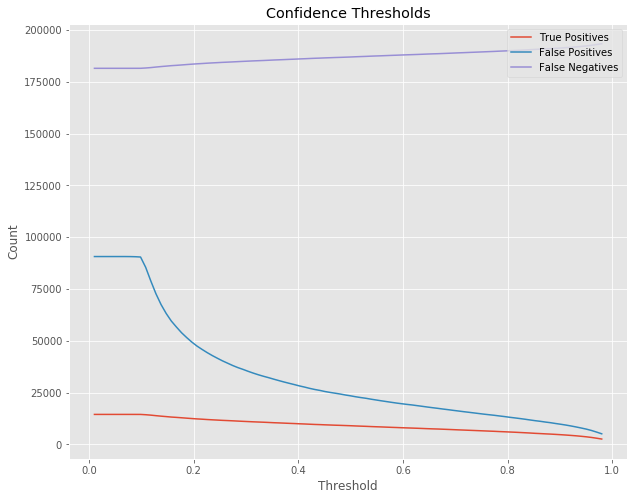

In [41]:

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))
ax0.set(title='Confidence Thresholds', xlabel='Threshold', ylabel='Count')
ax0.plot(thresholds_confidence, threshold_confidence_results[:,0], "-", label="%s" % ('True Positives', ))
ax0.plot(thresholds_confidence, threshold_confidence_results[:,1], "-", label="%s" % ('False Positives', ))
ax0.plot(thresholds_confidence, threshold_confidence_results[:,2], "-", label="%s" % ('False Negatives', ))
ax0.legend(loc="upper right")

fig.savefig('thresholds_conf_kitti_time.pdf')

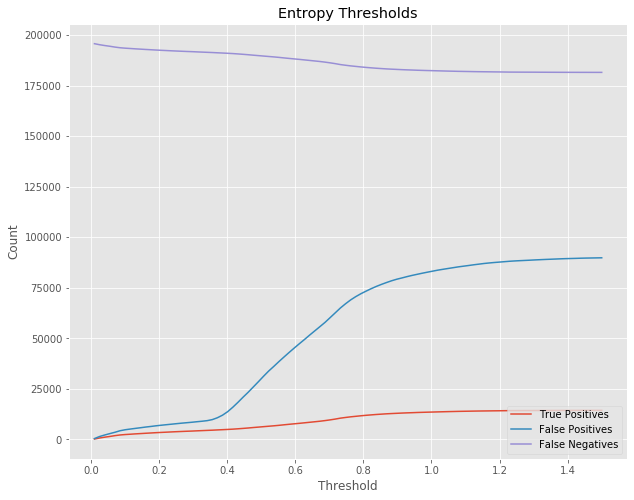

In [38]:
fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))
ax0.set(title='Entropy Thresholds', xlabel='Threshold', ylabel='Count')
ax0.plot(thresholds_entropy, threshold_entropy_results[:,0], "-", label="%s" % ('True Positives', ))
ax0.plot(thresholds_entropy, threshold_entropy_results[:,1], "-", label="%s" % ('False Positives', ))
ax0.plot(thresholds_entropy, threshold_entropy_results[:,2], "-", label="%s" % ('False Negatives', ))
ax0.legend(loc="lower right")

fig.savefig('thresholds_entropy_kitti_time.pdf')

In [39]:
def getbestF1(threshold_results):
    f1_scores = []
    for i in threshold_results:
        tp, fp, fn = i[0], i[1], i[2]
        f1 = (2 * tp)/(2*tp + fp + fn)
        f1_scores.append(f1)
    return np.max(f1_scores)

In [40]:
print('Best Entropy F1: %f' % getbestF1(threshold_entropy_results))
print('Best Conf F1: %f' % getbestF1(threshold_confidence_results))

Best Entropy F1: 0.095923
Best Conf F1: 0.098258


### Precision and recall

In [ ]:
precision_conf = []
recall_conf = []
for i in threshold_confidence_results:
    prec = i[0] / (i[0] + i[1])
    precision_conf.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_conf.append(rec)
    
precision_ent = []
recall_ent = []
for i in threshold_entropy_results:
    prec = i[0] / (i[0] + i[1])
    precision_ent.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_ent.append(rec)

In [ ]:
plt.ion()

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))

ax0.set(title='Precision/Recall - Confidence Threshold', xlabel='Recall', ylabel='Precision')
ax0.plot(recall_conf, precision_conf, "-")

#fig.savefig('thresholds_conf.pdf')

In [ ]:
plt.ion()

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))

ax0.set(title='Precision/Recall - Entropy Threshold', xlabel='Recall', ylabel='Precision')
ax0.plot(recall_ent, precision_ent, "-")

#fig.savefig('thresholds_conf.pdf')

In [ ]:
plt.ion()

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))

ax0.set(title='Precision/Recall - Confidence Threshold', xlabel='Threshold', ylabel='Count')
ax0.plot(thresholds_confidence, precision_conf, "-", label="%s" % ('Precision', ))
ax0.plot(thresholds_confidence, recall_conf, "-", label="%s" % ('Recall', ))
ax0.legend(loc="upper right")

#fig.savefig('thresholds_conf.pdf')

### ROC Curve

In [ ]:
true_pos_rate_conf = []
false_positive_rate_conf = []
for i in threshold_confidence_results:
    tpr = i[0] / (i[0] + i[2])
    fpr = 1 - tnr
    
    prec = i[0] / (i[0] + i[1])
    precision_conf.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_conf.append(rec)
    
precision_ent = []
recall_ent = []
for i in threshold_entropy_results:
    prec = i[0] / (i[0] + i[1])
    precision_ent.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_ent.append(rec)